In [2]:
from PIL import Image
from PIL import ImageFilter
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_app.processing as proc
from math import ceil

In [3]:
from tensorflow.python.keras.datasets import mnist
(X_tr,y_tr),(X_ts,y_ts) = mnist.load_data()

In [4]:
images = os.popen("ls Kensanata/").read().split('\n')[:-1]
for i,img in enumerate(images):
    
    images[i]='Kensanata/'+img
# images[:10]

In [ ]:
file_arr = []
x_arr = []
y_arr = []
subset = images
# fig,axes = plt.subplots(len(subset),figsize=(5,5*len(subset)))
# for file,ax in list(zip(subset,axes.flatten())):
for file in subset:
    answer=file[-5:-4]
    binary_arr,label_arr, segments,orig = proc.label_segments(file,'',photo=False,marker=False)
    found = binary_arr==0
    try:
        x,y = np.where(found)
        xmin,xmax,ymin,ymax = np.min(x),np.max(x),np.min(y),np.max(y)
        xlen,ylen = found[xmin:xmax,ymin:ymax].shape
        diff = np.abs(ylen-xlen)
        change = ceil(diff/2)
        if diff!=0:
            if ylen>xlen:
                xmin-=change
                xmax+=change

            else:
                ymin-=change
                ymax+=change

            xlen,ylen = xmax-xmin,ymax-ymin
            diff=np.abs(ylen-xlen)
            if xlen>ylen: ymax+=diff
            elif ylen>xlen: xmax+=diff
        digit = 1-binary_arr[xmin:xmax,ymin:ymax]
        digit = np.pad(digit,int(len(digit)*.2),mode= 'constant', constant_values=(0,0))                  
        im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
        im.save('000.png')
        del im
        del digit
        img = cv2.resize(cv2.imread('000.png',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
        !rm 000.png
        file_arr.append(file)
        x_arr.append(img)
        y_arr.append(answer)
    except:
        pass
#     ax.imshow(img,cmap="gray")

In [475]:
X_JOINED = np.concatenate((x_arr,X_tr, X_ts), axis=0)
y_JOINED = np.concatenate((y_arr,y_tr, y_ts), axis=0)
# X_JOINED = np.concatenate((arrays,X_tr, X,X_ts), axis=0)
# y_JOINED = np.concatenate((labels,y_tr, y,y_ts), axis=0)

In [284]:
def get_prediction(y):
    order = np.array(['9', '7', '1', '6', '3', '5', '2', '.', '4', '8', '0', '+', '-'])
    return order[np.argmax(y)]

In [137]:
def make_pixel_array(df,invert=True):
    '''
    Converts image file to pixel array with MNIST properties
        - Black background, white object
        - Centered and padded
        - Thick object
        - Size: 28 x 28
    
    Input:  dataframe with image filepaths under column name 'path'
    Output: 28x28 pixel array 
    '''
    
    im = cv2.imread(df['path'],cv2.IMREAD_GRAYSCALE)
    
    '''The following transformations alter HASYv2 images to mimic MNIST'''
    
    ## 1. Pad objects
    if invert:
        im = np.pad(im,int(len(im)*.25),mode= 'constant', constant_values=(255,255))
    else:
        im = np.pad(im,int(len(im)*.25),mode= 'constant', constant_values=(0,0)  )
        
    ## 2. Thicken object via blurring
    im = cv2.blur(im, (4, 4))
    ## 3. Invert colors for black background
    im = 255-np.asarray(im)
    ## 4. Reshape image to 28 x 28 pixels
    resized = cv2.resize(im,(28,28),interpolation=cv2.INTER_CUBIC)
    return resized

def read_process_images(img_list,y,invert=False):
    nrows = 28
    ncolumns = 28
    channels = 1
#     img_list,y = shuffle(img_list,y)
    X=[]
    for path in img_list:
        image = path       ##can do color .IMREAD_COLOR
        X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_GRAYSCALE),(nrows,ncolumns),interpolation=cv2.INTER_CUBIC))
    if invert==True:
        return 255-np.array(X),np.array(y)
    return np.array(X),np.array(y)

In [54]:
file = 'hasy-data-labels.csv'
df = pd.read_csv(file)

In [62]:
df.head()

,path,symbol_id,latex,user_id
0,hasy-data/v2-00000.png,31,A,50
1,hasy-data/v2-00001.png,31,A,10
2,hasy-data/v2-00002.png,31,A,43
3,hasy-data/v2-00003.png,31,A,43
4,hasy-data/v2-00004.png,31,A,4435


In [ ]:

# digits 0-9, \cdot, \bullet, \neg, minus, plus
digits = df[((df['symbol_id']<=79) & (df['symbol_id']>=70)) ]# | (df['symbol_id']==184) | (df['symbol_id']==527) |(df['symbol_id']==195) | (df['symbol_id']==196)  ]

digits['pixels']=digits.apply(make_pixel_array,axis=1)

digits.to_csv('digits_somesymbols.csv',index=None)
X_HASYv2,y_HASYv2 = read_process_images(digits['path'],digits['latex'],invert=True)

In [477]:
len(set(list(y_HASYv2)))

10

In [206]:
y_HASYv2 = [y.replace('\\bullet','.') for y in y_HASYv2]
y_HASYv2 = [y.replace('\\cdot','.') for y in y_HASYv2]

In [488]:
y_JOINED = [int(y) for y in y_JOINED]
len(set(y_JOINED))

10

In [487]:
X_JOINED = np.concatenate((x_arr,X_tr, X_ts,X_HASYv2), axis=0)
y_JOINED = np.concatenate((y_arr,y_tr, y_ts,y_HASYv2), axis=0)
# X_JOINED = np.concatenate((x_arr,X_tr, X_ts,X_HASYv2_all), axis=0)
# y_JOINED = np.concatenate((y_arr,y_tr, y_ts,y_HASYv2_all), axis=0)

In [482]:

from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
# from keras.datasets import mnist
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [437]:
y_JOINED = [str(y) for y in y_JOINED]

In [489]:
X_train, X_test, y_train, y_test = train_test_split(X_JOINED, y_JOINED,train_size=.95)

In [494]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.BatchNormalization())
conv_model.add(layers.Dropout(0.4))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.BatchNormalization())
conv_model.add(layers.Dropout(0.4))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(256, activation = "relu"))
conv_model.add(layers.Dropout(0.4))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dropout(0.4))
conv_model.add(layers.Dense(10, activation='softmax'))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [491]:
set(list(y_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
x_train = X_train.astype('int32')
x_test = X_test.astype('int32')

# y_train = y_train.astype('int32')
# y_test = y_test.astype('int32')
x_train = np.array([x.reshape(28,28,1) for x in x_train])
x_test = np.array([x.reshape(28,28,1) for x in x_test])

# y_train = [y.replace('\\bullet','.') for y in y_train]
# y_train = [y.replace('\\cdot','.') for y in y_train]
# y_test = [y.replace('\\bullet','.') for y in y_test]
# y_test = [y.replace('\\cdot','.') for y in y_test]

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
# dummy_y_train = np_utils.to_categorical(y_train)#.astype('int32')
dummy_y_train = np_utils.to_categorical(pd.DataFrame(y_train)[0].factorize()[0])

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(pd.DataFrame(y_test)[0].factorize()[0])
# dummy_y_test = np_utils.to_categorical(y_test)#.astype('int32')
conv_model.fit(x_train, dummy_y_train, batch_size=64, epochs=15)

In [442]:
for i in set(y_JOINED):
    print(i,list(y_JOINED).count(i))

- 118
0 7040
7 7370
+ 90
9 7050
6 6978
3 7263
4 6887
. 7105
2 7116
1 7995
5 6393
8 6948


In [443]:
watup = pd.DataFrame([str(y) for y in dummy_y_train])
watup.columns = ['encoded']
watup['label'] = y_train
# watup
set(list(y_train))

{'+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [465]:
watup.label.unique()

array(['9', '8', '4', '5', '7', '.', '1', '6', '3', '2', '0', '-', '+'],
      dtype=object)

In [274]:
print(dummy_y_train)

TypeError: unhashable type: 'numpy.ndarray'

In [449]:
y_pred_prob = conv_model.predict(x_test.astype('float32'))

In [450]:
y_pred = np.array([get_prediction(y) for y in y_pred_prob])

In [447]:
y_pred

array(['4', '2', '4', ..., '0', '6', '0'], dtype='<U1')

In [451]:
results  = pd.DataFrame(y_test)
results.columns = ['actual']
# preds = encoder.inverse_transform(y_pred)
# preds = [str(y) for y in preds]
results['predict']=y_pred
results['match']=(results['actual']==results['predict'])*1
results['match'].value_counts()

0    3204
1     714
Name: match, dtype: int64

In [463]:
testimage = 'IMG_20191119_110133518.jpg'#'IMG_20191115_141413816.jpg'

In [382]:
def get_pred(y):
    order = np.array(['6', '1', '9', '7', '5', '3', '2', '0', '.', '8', '4', '+', '-'])
    return order[y]

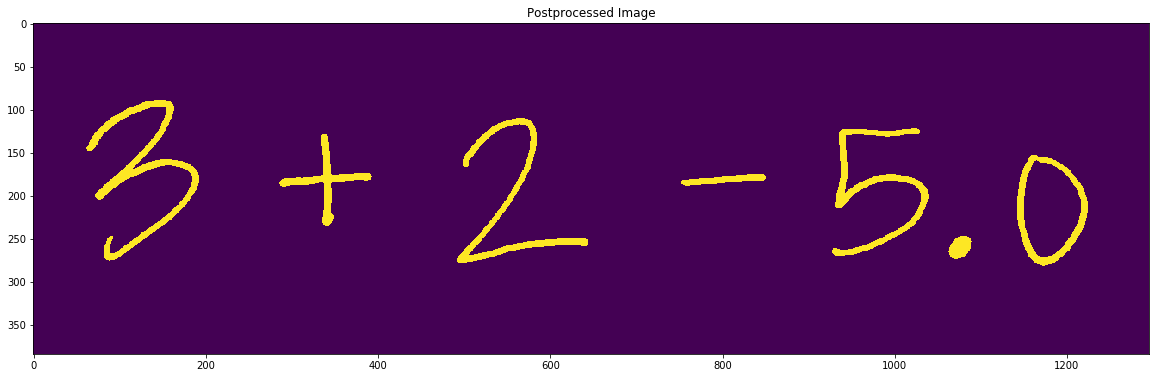

In [456]:
binary_arr,label_arr, segments,orig = proc.label_segments(testimage,'',photo=True,marker=False)

In [ ]:
predicted=[]
fig, axes = plt.subplots(len(segments), figsize=(6, 6*len(segments)))
matname = 'data/predictions__img'
for seg, ax in list(zip(segments, axes.flatten())):
    found = label_arr == seg
    x, y = np.where(found)
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    xlen, ylen = found[xmin:xmax, ymin:ymax].shape
    diff = np.abs(ylen-xlen)
    change = ceil(diff/2)
    if diff != 0:
        if ylen > xlen:
            xmin -= change
            xmax += change

        else:
            ymin -= change
            ymax += change

        xlen, ylen = xmax-xmin, ymax-ymin
        diff = np.abs(ylen-xlen)
        if xlen > ylen: 
            ymax += diff
        elif ylen > xlen: 
            xmax += diff
    digit = binary_arr[xmin:xmax, ymin:ymax]
    digit = np.pad(digit, int(len(digit)*.2), mode= 'constant', constant_values=(0,0))        
    if digit.shape[0]<10:
        ax.set_visible(False)       
        pass
    else:
        ax.imshow(digit,cmap='gray')
        im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
        im.save('000.jpg')
        img = cv2.resize(cv2.imread('000.jpg',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
        os.remove('000.jpg')
        p = get_pred(np.argmax(conv_model.predict(img.astype(float).flatten().reshape((1, 28, 28, 1)))))
        ax.set_title(p)
        im.save(matname+'___predicted____'+str(p)+'.jpg')
        predicted.append([ymin,p])

predicted.sort()    
predicted = [pr[1] for pr in predicted]


In [409]:
# from my_app.predict import predict_tf
from my_app.predict_withsymbols import predict_tf

In [467]:
testimage = 'testequation1.jpg'#'IMG_20191115_141413816.jpg'

processing  testequation1.jpg
['4', ' + ', '3', '.', '2', '1', '9']


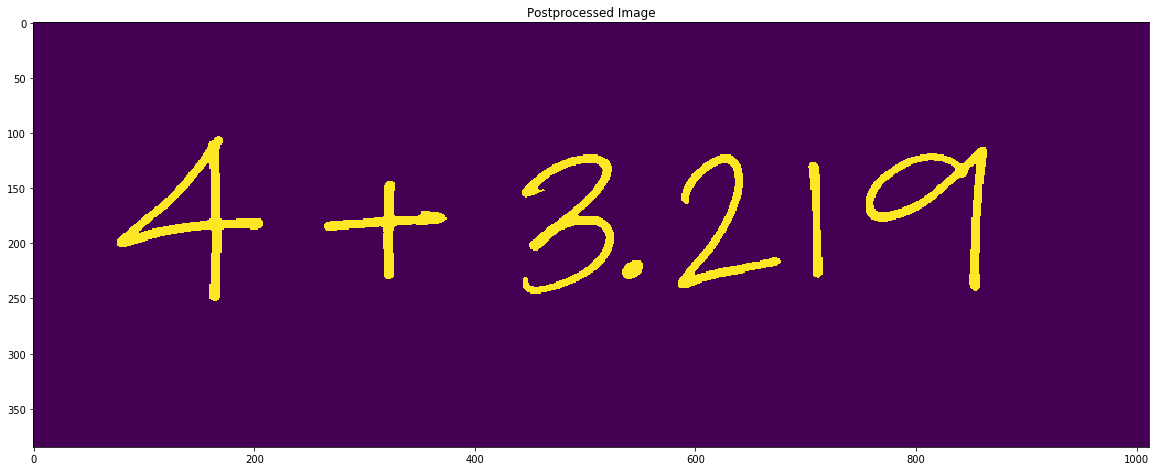

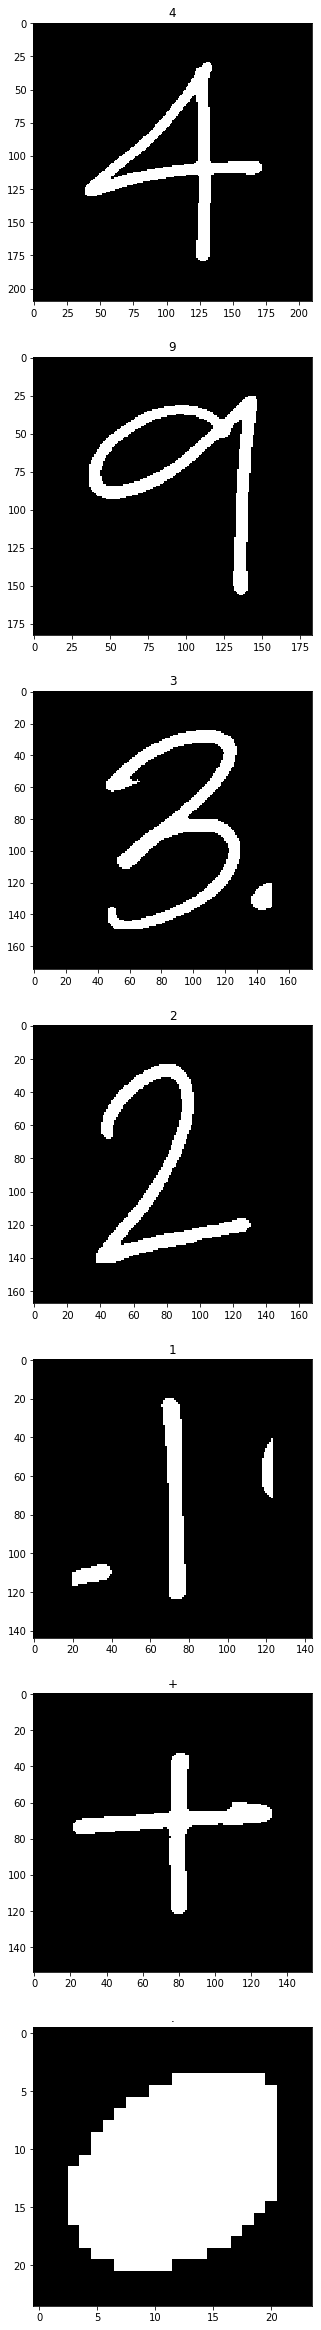

In [468]:
ypred = predict_tf(conv_model,testimage)

In [420]:
ypred

['7', '9', '1', '8', '0', '2', '2']

In [ ]:
def add_spaces(x):
    if x=='+' or x=='-':
        return ' '+x+' '
    else:
        return x

In [ ]:
watup

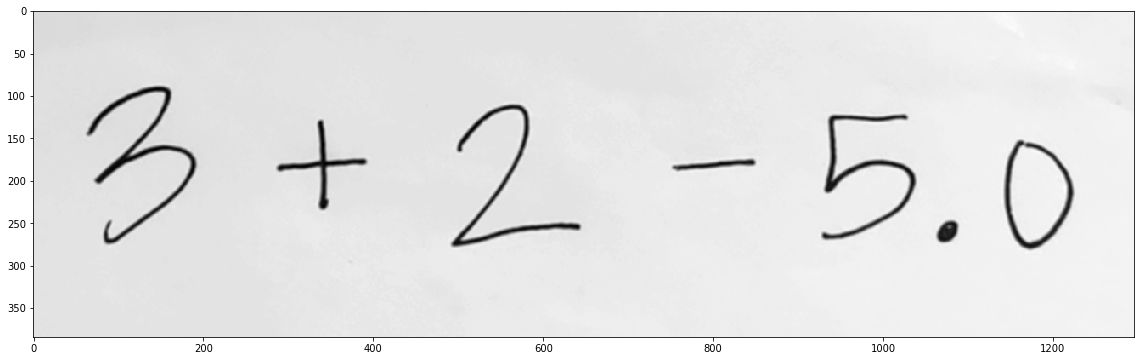

In [396]:
plt.imshow(orig,cmap='gray')
result = [add_spaces(x) for x in ypred]
cmd = ''.join(result)

In [397]:
cmd

'3 + 2 - 5.0'

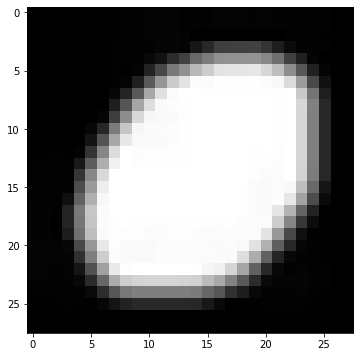

In [356]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABHUAAAFpCAYAAAASvhRqAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOy9SYxeWZYedv4YGRGMZAwcMjnkPFRnV5ZLqmz1xgJsSDZsw0B71bC8kQ0BvbH27p232howYLgXhqWFLQmaATU8QIDhjdzdQilRyondTBbJYHIIRjCCEcGYI34vyPvX5eEZ7/D+9wffBxCM/707j+d895z7ev1+Hzp06NChQ4cOHTp06NChQ4cOHTqMFsaGXYAOHTp06NChQ4cOHTp06NChQ4cOfnSkTocOHTp06NChQ4cOHTp06NChwwiiI3U6dOjQoUOHDh06dOjQoUOHDh1GEB2p06FDhw4dOnTo0KFDhw4dOnToMILoSJ0OHTp06NChQ4cOHTp06NChQ4cRREfqdOjQoUOHDh06dOjQoUOHDh06jCCqkTq9Xu8/6fV6N3u93q1er/eHtfLp0KFDhw4dOnTo0KFDhw4dOnR4E9Hr9/vlE+31xgHgzwHgPwKA+wDwZwDwN/r9/rfFM+vQoUOHDh06dOjQoUOHDh06dHgDUctS568AwK1+v3+73+8fAsDfB4Dfq5RXhw4dOnTo0KFDhw4dOnTo0KHDG4dapM41AFiJft9/+axDhw4dOnTo0KFDhw4dOnTo0KFDAUwMK+Ner/cHAPAHAACzs7O/+PDDD4dVlDcWvV4ParjfdaiHXq8HAGDqtxAWh4+fjypCfc5CXTp06JAOvAaM4p4mrevUPq2te1wbxPmUWjtx+Tx7VFOw1pXaV6xtpdWXSgPn1+Q+fdZkgraAmw8Afrmtgw0115yU9TcnL4C6a2fb1+oAa5m0tbqpvmsSX3311Vq/379EvatF6vwIADei39dfPhug3+//EQD8EQDAF1980f8n/+SfvJJAasOXFFZKYmzshVHU6enpa89PT09f+b8WUgVBK3DdAuI6UfWX4F10PMJbqfZoarxxY4gKh8dSHCd1jJWsp2WhDX0U95VVcPaGK725lVA0vcKgpQxSH+L33DiJ1ysMy9jyxKu9JnbQkdrPTQGXRVsf2whuPuEwVlj2YmlfxmGs+8f4+Pjg75OTE1tho7jeOJ60LYjzx3G09ZiKK6VHvafqby27tofFe2m/34eTk5PB+jo+Pu7es7zygJVEqj2fLeWoKSOF/PGcwnFTyuCRlySyAssCFmU5INSL60drvbS2lEhSDhJp7hnP1rC5fZqyJuL5guucSurEsjI1bizzypKPdb5LfWbZT6k4ePxLeVjkaSs0wh/ndeHChbtcWrVInT8DgE96vd4H8ILM+S8B4L+SIuAFJPUUoUlCx7MQcMqJV9nOUT5xm+LfnNCilZEjqih4yStvPbk+wcq7dTJa2tuyAJSCpmCdnp4OwsTtbCWEaiO0kffk1DoOUsOV7jtpQebCUO9LlskrJEnEIEC64IvXBy0drzDIpTEsImLUiSlqDIx6ndqG1HWZ6wdNMcbvNfJG27etxANGPLcl5SV3DbCQJ1QcTHZIFhhUuhS5I8HSjqFcGJa9Fe81cXta9xvPYUMc1moZjsdZioJmKRNXlpx1zXMA5a2XZQ545SUqvlU+40ieUC+qH63wWrVJadS0TJH01FTZLV4zuLke3lsQzzuJ4JGe4feSvu4BtSbk6phUeAuo/U1bsySPAet6F6fDwZNWFams3+8fA8DfBoD/EwC+A4B/2O/3v6mR17CQsngOW6GO86cmd/wvJU0A+4QshRS2Pift3PBjY2NJ9Y/JGfwvJR0rhmX1pp0wSe88pBHOs0Z9KUFCE/4swjn+VxoWZbFU2jEZeRYQ6nOW6gQAyetOk2hz2YYJTPBrwGNYilfLwiagiTHHWdJoclH8fHx8XFTC4nbKaTMuLt5jqH9hr5AskTCoQz+rta2UDoeSVmscUvdM67rOKXrYGtZ6qBHCW8JZkGtJENKgxkKtuYpJQks47X0tuS9Fn4rnJLWOxOOFW2csY0qah9Jzazyu3pY5QQHLHaXlqtR0qbKn9LsEb1rV7tTp9/t/DAB/XCv9UrBOaK5Rm1Z6JXNJCwIbycWjnksLhOe0Iee0jdvYPAuHtY1C2BqL/agpeRwRkQqP2Sp1IoDTkSxuPH1O5WFFigmrFpdra4sgw8X1zFWLa0YuLKexucJhCSufFHTEQnMYtTU1FdThSCyMlhhzTbiBA7xelyYtvyhrGsmSR7KMsYKz4gnPcPrSCb0GbZ+MLYu5PLQTfUl+lE6vtXKHOJrMGf6vMfe1scgdXIbncfty4PolfscdhmrWeW2xoixl8RTAWQZJYcIzyiraakWdU2aMnL7xWq/FYbyeBNpBJBWWi0eFL0V4lEDOOtKmegQMf+ZHiBmpmAHTrErieKkWJxo0pnpYsObPDVrqBMYLy+ltKeWKMo/jfueaBXoX9FGHpc5N1pPq23hNsJSlpCULN4csZbGYcGrPczZkCZwrBn7mPen3oka6bbcq6dBBg2XelRzjuS5OmgUKd0CjCdYxAZFrBRcsaqg7gCiipbYlElU+y7t4b/NYLafsR9b3uCyevZqDZ0ymyH25+wSO6zlArGFxexatRC2QDt85MoEiQTUrai4PqVwhLapfJAs/CfE6lpqGhNrW4AD5OoU2b6X0NVfG3LJ5LMa0+Wpt/1ZJuxYmti0WMxiSGaI26JpQOjDxgkmwGKkDGZtql1SouLRSTEg9cXD7DHucWeE1VZTMWlNO3FLHkEWgTBE6cxdnrQ05dxtLeTVhgPrbghzz8hge8/AOHTqUBTe/UhU3bq0qMY81YseyjmpplzggCq5QXDmDcoSJHSmOll9JhHJhiwLOHcBSrlwlpqQsSSGWZ0rvOU3uYZ52puTeJqxocw5Da6NkHiUOtWuCIrI947+th1pWXcxaX2qOhGfceClxvUCqO5m1PCloX2+/hEWRzmEPve41FjKJKo8mgOR0ZO7ippnIlWJna5/we9C2RdsCT7tpQoAX0ilgDdTKx+K2xIHaUCRfWikPbl5ZiZ0ccO5NOYJhR+jYFdWureqCumusDXtOKeSOHyo+FpqbHqNSmajfNdwpOcJFInBy78Mpeb8Otz9QaaaSUl7kEDxWi7SaxE4tS5ecQxqMeE5oyq+nPvGBL35OeUJgmcaiO0jvtbglLMlSIRFAnnyHIQu06UA6pY9SLhWvjTbqk9Xu1PEi1RyUW4C0dCimMEfx40xfe73eK4IIdzqWIqRYWM5U4QcTXpppbxMX21GQ3OJS4ljcuawsMz5Fo6Ap1djaplY7Uid+XuIzIA4f18/SHpa0U631uA2ZK1d4jhl/jrwJ77l5J60RVNi4XCGcxxyYQpxfLvlXekxaL4RsG/Acju8leVMInVoXGHqA23zY5WkKnruoLDJB7ryW4lPjhBs7uKwl1xspLc/XsThgNwhLmvgeHe6+HQrUviDF4wgfa3wv8N5r2bNGdT/wQJOJctYv6e4f61zyWhl75G6Pezkl+1DynMXFioNF5+HSiuVl6h2FWjK9df1qivxKhXXsS/sfblsuzTAnvH2Cw1s8HlKJXWvY1pA6KZAUHQCZVeXSw/Es4TlwVjsBpSYzRzJ40ucGHJc2rltKXTzCKAdPn5Xwj8xJgxJeKUUkDsv9romSLo5xvXLbj0Jqml5XPK3umqBEKfo4XUkgqXHKkqvwps75pu4GaRJWcvasoi3kSVvKMUzUml/WQyKKzLRYWEiHXnGYUuAIHZy/lqfls+VW6xjqgmR8iXMtUBdEU3mm7Ll4D+Nky/gQNEbOASWVP34X54/zBZDXd0+5UuuRIgNIVjs1UdqdiTv04p7l5J8qa2mGBxyhFcY7Xidz5zlH7ODDQqpMTUIiwyjEY1fqq5QxXmpvGbae2QpSp9/vq6fbXCVTLHy0SStNQi2vuLyahUYplBhE+G/L4uZVjDFyXT8opLL0ADbSglLCKcsHbvHhBJaAYSl/bXev4sZjChFrIVK0d3Ge2KKHgtVig5tTnBWZd+61wQSXW+tHnfiIy38W3X9GHTX2m2Ejxx2FI5pxurnlSolXwlrIekobw2J9o1nQlCBearlISV/cws/i+5Hi55Y9R7PMsSrqADRJqOXttQLR4J1buSRUjNgbofb+HZdbm4OlyRsN3j5sQjby6kCcy5Zk5Z36JTyrxU5AyUNXTS63tLW2t1EeAaXIVyusaVp1Dhw+pT9aQeoEUANaW8hSKu9dHGssWNqizwklTSkJnBmZx93Nglyz/dJjw4K4zJogormocaeTw1QGMVkVwzN3vEqUtBF4iEfu5A0LRznuc95FusRdAFS9PCRsG9CRHB2GibNG7MR7RYoJuWc+Wkjr3HXOc8DB1dO6n+LnFKERv8cKUs5nx6VyUIqYNx8pDWtasVJorau2V2L50UOoeMaTxbLWm2YpeOS72mSJZIkUl1GScawHqU1bgtQgnVIO/Ll0AJo7ZIv7N8VFzUv4pFiVWSxMNeImDuvNPzVujCa8BjS0itQpASsLFianpUFruI1oqKX8WBZnSqmX/Eg1WDYxfBoTM68SvMpsjUVUKiPFJnPxap3up/pPS2aaNU63as4zrm5x3lyZPM+4eaK1xbCVzY5s6XCWcZbHdwkiJDesVKac5xI4oib+m7Keo96lkjMWskM7LccKSyiP5U4dz+fXU0goyvUKIM2tBadBhaHeDXtv1GBRNANyyZyahzcp7VxDXuN0j5x615ItvRY6VlmaIpAB0tcp7DnAlW8Y6PV65n1Le5+yZ9VcWywWZJJVfsq4bQWpw3VqWCw9LlYaGRE3UupiYWGAuc0vjus1eS4hiFkntMXVwzrYLKRHv99/jdSwkiXac2//Wk9xUvprGG4nlvQtwkJNQSMIFJrLIncfTYyUsmChkzJ5pkg5PEa8izA+XefSwWsOfuc1Z6UgKYc1rMdy0hy2NVuH0QB1WFDCaq5JlFBqLVY2OKzXikeyqIjbnrNYjeNqhA0VRyqb9iz3a1ae5wHYnYuz1pHIGMnFwnLXTwrw/haXDx8MavG1vavf77/Wv7GlbarcUXree2V5bCETwmv1keQCDZS+E9oQu11JBChOj3pu3Z899dX6W2uXHIsIi44kIdSD06FiIwOu7VJdsDCwBwEuX2lXNm7cUflbkGoBii3PQjmaIo09XEEOydZqqThVaOcmN3ZZoMJzoJQqa8Nzpw/cKVIqrP7GkjJMtQ1X11xFvk3uIqE/cJ94Gd+mWd+mkCpIlAQmHSyWR/FGFf/T4nGI8+X62pOXdc6WQM7YrEWgpJapI3Q6aMBuSQC/WaNrr9WlYVnvvHMitEGuHBK3pdSmXJtTZDLlQhVDKjO1l8fwuiFxZeDg/Wy4pRzeL23VuFBZ2odwnTV50XoQIZUjZ1/0HEjWsFTjxrlHr5BQKp0Az3rp1UOoQ6qA1IPkWPbT0k9tp1LtG5cxEC7UPoXXgBL6I3V4XxLFiIoEXQzHx+WKyyOln7vOaGMsJr3wuojXOtPhbXJpWw7tNKDUBkPlizuS6lC8SHKn9RKkgastrNb6WpnxUQA3aS3CsiYoxuFqIW7v0gqJ5cSEmycl5k4q+y5BK7N33lvcHErOCe+JiSXvNimytedLhw4BZ3WcUfuSRpxI6ZQoD1cuLyTyLYecS3FDspBWOfCWJ2X/ygWlnHi+zOVV8CT52RLXYikkwWoJxsFCTHos6ChodZGUSty+lvwovYV7l1ouL6zp5OSXO98sh6Jxf1j7Jh5DFLldolwSONm6NKnIIcWq1ALNXS1GiTVYsr63eAbFaIX7VQlw7kHxc80kjDPpxGFLDFZs6khNWi0fbE4WTMkkpJisUvW2PksBd3LHmVHnnCDUFPa9rjgelC43NR9SwtQApbCUEq41k0gvvPG0NpXIaE5Q4ywDPW3WuTd1GGWMmouVFZJbknbgUAKUu4+mTFjWHqsLVam+zHFJ8tzb4HGl0L5WE9+r4ZHjan4GPSePYVn/evOi3K4B8sge636Mx5q055ciSIILUJwvVy78d9Pg5Cfr4VdOu0l6ovfwTTrAi4kdaj0ZGxsbxA9rAwerFVXOWNLqnjPXsbtieEYhR4b1xKtNXnnTP1NSu+dkW2JdcRzOJMpaFusgzhG8PB2vLYRam9Vwu+IUUQs8ljbU71poguHNgacvay5cqX1hdcGyvJNcpqzjKwclTjak/rQIYVaLtFHBWVLmO/iQ42I17LHvJV/x39bySy4i3LtUMgTvvfEza1wcnwrXJJlnJaqo9rS2Y3ClaoKYiRHcqbBbVa7MwtWb2v9MrgaCy4RH0dfC4HxS52hKfAkp8jh3yK3J/9i6xiInpNTT4h6Px4tF1qbqm2vNVTpunAbl8dHv9+Hk5AROT09fmZtSnvGc0/ortg6poecB5LcPNRdLzCfqALXk1QfUPwyN8LOUafQl9wrwkjYacEdhpt87IEu6wGBFtsSCpLm8hL8DQnuE99Rmga2S8DOrMjpMgX0YJtNSWeK/tXJJ/ZYLrzLiCWupUypKkB+5YyI1Xkd4dOhAY5hzwysTWJRNicTF78PpptUKxQJKgPXej+BVoq2EVW5f58S3EDulLznORSwfppRNIqcsVsIYHncfKR0qLKWAeQjJ2BrHQgBy7lml5awAy4FXHIfrH4s1DwXu4NvSR9wBvuRq5hkDmlxVijC0yn6Y5AmkzunpKRwdHQ1+c+XgvmLnLa8FXt3CUyYKKXqgBSUPslOMClJdFM+M+5V1UlnZQ80Ny+K2gcMFwiJAciuROpxbtKgyeJASz6I048XUYpVjMcfm2opLqwlCRxobcf2lDY3a4LApIZeP13TSM27w+1SBVjI9xooGNUc482eLawKOg9uLaw9qTFFpet2cQp7xXLHOw5T5mlK+UUWt+f4mtWGH4YNb5yTiggubqoBRkNZmqhySjKPNKZyW1SWXW6dTXF8wShwgccRInLdk3VID1ntyrNZDVoWd2ntLuYLE6WiyvQTLuAljOWVOpcqqVBtJc4YLT4XhZFUPqWu1qKasJbgwKbJukL2xyxond3FeG1K+1HuLDuQFJnhCupOTk6+1N2WtE/efhfCS6kU9w3KtVpcccHPO64JV0riBgsVSiloHPYRka0gdqTFzF3YJNd1KaqZtybcNFiExrKRBv993Ca4aNIGx5vjC+VieBcRlwr6ktcxGmxozWv96hZpUwRsgnRwBoBUor9Jfo82leg/LWi3Hx3mYwHMvftahHWiSuK+JkhYy3rDW/KU8OOKGIl6sZFUc12ohEcetMU9rjjNtLHsuJ9YQLo2miKPaX9CyEjzUs1gxt6TBHdpaDnM9KGlVY02rlOza1NoZ6kYRJhieg3gPrMSQdyxQ6ZbqH4l4it9pX8oL74chw0iEakCqPkbVJ9Wiv0ndmRsrnIGI1metIXU8qKkcUG4mKQgDzEqweMw6KcSdnmPGVmOSW8uDJ3LJkwCv5VMOJIJS6yMpLuWCRoW1LIopwksNsrCEy1XqnKHGu9W9jCJz2oIcxaxtdRkmOKvK+FlH7HRoEjXHXIm5jwkYq6wm1UmrM/c+t50k4r4mPHmkfMkrRhN39XAESok08bMAyqKitKKWagFmRarVPobHOoCar7j/UtrRa0EhWS9bZVccjlLcvXJwqjdDCfLQqjNobY1JXOmA2ErCckix0BmWMcQwIJGLqQRzq0kdrkLUYiC5owDQJmEUtPeY9LGGDyhFSOEFvyRbb3F9istQAxLjmsrG1obFEsfjWsMJQ5Y0rYtxbXNDCngOWFytKKT0ezx2c8avl0S05JVqEi7BOlfaMofaBKuLYIfhY5TGb7y2cevcMKzasKuS5KqF39UmOD1uY6F81jJJpM0ok90Wwkf72hZlxZP7pSsKFtJHCpOjEKUSTqXGu1ZWTj4q4f6H8+XiYKunEgSZVActfcqtjnqfU9aUeCnuYFr+ljRx/+A5qxE7cZ5UX3v03BoHylZY13xc3ia9FDxIKVerdyqP+ZplQ4jDcuE9BI0EamBhv9YclEwroLQAE9pZam8LKAHSYtmk9WXpSVyqvjjNGKXKbNk0qbzbuPClIIwh6ymyhQSSwmGrD6vA5V7QW6x8tLlsHtRy6ejwZsHiiiTFqQ3repebTiosd/B41nkKcdyaX6GqlTb3FSutHHFZarphxXtcKdk7gCJ6pPRrHnBhV/oU1JhHqXX1yrmxLhfHs9bJSuZ5kSPPeuSzENbqLig908rS7/cHXiIhPjXmwryWLIAkSxKcp6WsuA1ydQrNgtODUvPeU6caa01rpGwLQ1wagQWzTDgO1jhNKDRSHbyCDSZOKOEIP8fvJdPHEqDqQ13+xaEJ65QS5oVcv8YLqUVg8QguwyBvpIv9pLC5qEGQcvlIv0sgJpbaTDy0vXwdOtRCLtHApSnlZQWel9Tf0r6b60aO85Sg5VHSore2m5KVdPEgt8yY2Am/OZLIU35OyZfCl5DXpEMybKGQckhHEUlYRpNcvq1IPcykUFsO9hzOp8Bq1eOJr6WZoyvWlq0pUicGtydw4alyc3+X7mOr1wj1LI5bss1LH27HlkIl0m2N+5V1I/cOoNhMTyI8MBkQwpYyK47N3zg3C6/vNpUOVUfON7yUCaenjFLacVhrvphBtsZLWXy0sYfNFLEJaAqZg2GxMCtl1ll6DsSgxmJ4bu3D2i4KlJsE9z7+P65L/Bz/LaWtEZYl0JRrgaUd2ozariUd3lzUmgepBDK1pnrHfm6drLKJln8gqPC6o1n44Hw5VwXtHRU2oMlPlcf5YjmEKr/ktqV9DSukhcNZXMG88hHnnqzJN1aLAs7SR5PLKPmrlBJomReW+lF3XqW6oVmJMkk3CWFzXKW0vKzp5MSTSJHwNx4r4TmnF1rKisPido3nOJ6LnsNvyarHMj+8dczZAzTyNGW8lHKXo6CtV7FbsYTWkDpcA1ue54Lq/FqKrLSIaZ2lDRptYNa0FIgntSddKzEVI27HVKLEE49j8j0LuLTgpcKSlpQvJ7iE8S+Bmh85c8Ybt6YyVLocmBxqmtCg8pXuMcLPU+G9HLGt4Ei3jujpUBqpRKt3LHL5tGV+WstRgkCKQRFB2r0zNeEhjbj4GFiOxnmUsErCimNNSyePm1VqmvhdCSVwmMD7/tjY61+jCu9weC+CnGmRgbkDUAsx4imP9ZmF8PDI4amwWg5pngEnJyfVxqSF8NDee9tJGp9Y17aUwwJpbGLkEj0A/r29NaQOB4kxl+KUQs4plWT+W4JU8JTFm1eOJQs36LWNkvq7KWCmudQiUGJSp+YZgyNHPfWrJfCXJhNygRV2/HeqiwG24ElJQwMuO1dWi+sCZy3Uhj4aJt70+rcdo3q5bUmSkJM9cvNIcY0q7SprAZentSxtWudityfpmQWcXEORLikXJOeSUBxSrUhqoaY1TpNItZK2InbdwZbrlnjW5/F7aZx4rIhKjDfp8NeqY3jHFc4z9Gv8XOprr86Sq+PE8Tk9LA5LebZYx642b7mxiYlJKq7luYRSB62tJ3ViWM0mSyBVEElR+qyme5wbVZy3J18KFsJMChM2iZokTcn6ld6Ic0xItXS5ZzkMOZcXNca0BUZyV4qtRbi51QYhGps4cm5XlrJKYTj3My09yz0RtaxIOsuUF2iTwtfhBSzzaVT6rUYZJZIjJT+LG1NKPAs0d1VNPqLS4sjwUsCESCA/JHLGSqJooMigFJnM+vn0EsROyYO1YYGSBUuRqzWhyWkaJEWcAtZ/NBma0y24fKzXEaTAQuxZrPqlMnpJMMoDJCbXQpjQv7mEVo5+R1lgNXUQrrV3qi5XgtDBcy/ur5Fxv5KgMXbxs1qQhAbPIognF35HDWTJtCyeACUEEQvBZDk1kSaM5VlJWBcJrwULZwZa+xSHO22Q4BGQKCIRQxrzKae5bUCqIBMrRpQ1Ds6D+1vL23Kvjyc9qWze954TcEtelnSGOX7aLJS/icAuhpo5dhPwjnXPnPUqh3F4LMvUInZqINUCx/ve03da+1msYChwJIrVlYnKg0vTQth4Xai0NKn3peQk7m4fS5wA6x1AvR59Xyf1LGeuachNm7Pm1eZOrACXkuU5hdp69UQuIUiRCyXSosqopc25nllJh1hvo8KHdbyWNZxHX9HKYNWPc4Hb1qNnSWuB5OIY/rZY0UtoDakTVzqFIcvdDKxsKEeeWDomhSjQwuJ4FMPoZV25yW8pp2UDSEUJMz+rK5/Ufl7ypwSkTSHHYkcb9xo5IVnlWMK2DRZyRHJlslo1NaVElSQ/tLSaPFltGyGYglGYD6MEbV+u6T6qEZ4eYseaZyow+ZVC7ODwFgXQS2LnIscqwtMWWliKYKAuTaaIJIr4yLWYwfFDGI91TaplkRY+xdKCSzu3PrUgWTRb4kjvS+z3knxDAcuhFLj+i12DLOGt6XIyuke3onSFkpYbVLmsXhvWdC2Ix6CVoONINCsoVysvasuApb0uJH05zouy0pHSwGgNqYOBWUxqsNeyfogX23jgUH6KOEwqcBqWkyJLW6QSIDl+r1q6OA3rApG6IKdMzjiOFpdbBGsrt6XS97aPh0luw4l5KrArlge14miKKxXW4o6QkjfON8wBy0ZNmZuOyrgohY7QqY+aY0obs9h6qA2ISRwMTubg6oAPsjRYw1PlsLQjpSSXcvUt4VKE3aCslxPnEDuWskig8pXSrHU5Mif7pVgDxc9zraFS4CUMtfkgjXktL45EsBwu4znJkScaQUHNbak8peVqj3WF5iaVWj6u7ayEVEkLmxTLKykslRanW1nazlNXj5eG5EVitRrj6mkpMzW2vIQOQAtJHakRvIp67ZMaiXjxmO55FV8r0RPypcqgLbQlFk7JDSmXuNHyrZEuByv5Q2GUTuu9grBGArQdJZUxr1lliuDHxeHGmLd+lvKlzIFRGxcdRgulXP4wLIc6pQ58cueIJz61ljRJTnnkIc5iaBiQiBoLieK9/NhCCsVpcuWzEDXSJ909zzFquXxQZYjzspY7hTzTDlu9rn3U39TvFHjdnGJQREwsC5fs1xRvg5w8SlnB1CiDBIv7ksdjJHX9e7kAACAASURBVMWYgtIzpQNvr0udBu6AXXJbSxmrpceIRCzG0MramiOk+ITXE4dC6ul6QO5iickRL6FTGlZ3qhr5Su+4QdyE+0bIpyn3KQ61FY6SCCe8+KTXKoTnzss2gzv99sRvOyizbE2hPct93mE0MOpjcBTWBgtq1IOzIIpdyrwubVQ5NaIlKP74fyoMF4cLZ8k/dqHiwnqJmZx3VuQq/p4yxHnF7RS3S2k3LFUBi8andazWWMs8cjA3TzSrC+5gqUR9gv5ocQWLy8fpABb3Jy49D6g2q6WTeNOOw1uJIGu4lLxwf8W/qbjSeKx5yB/S9xCjJft8dCWdl4gbjlsgUi0MqEFqHXA1QQ1m/I5DaCMpDSrOm4Ra/SiNTa/AK50SW8zUY6TWtZRpe0hrlJWXuB/bWI9SwpOVrPP45Y+60j2K6Nq7Qwl41jpJeS01HnOtGSRiJwcxgVPLtUciJHLybfK+mRxoFkfh/5rETaoLvtfaDM+h3AOUUG7vHT9SesEiIleWxrpKTOBIyrPF20NTvptQ/imktllKebWxg/XEFPen1DCe9rF4mnAEHjcO4jpzYSzvpHlQWhZrhftVv993Xy6MzcO4MCF9L6gBQt3/EG4N19CURU5uGTwkQ6pZOBfP6pOa069SXkXZUqcrjBc5wie+GK1EOXLRFjeFWvnXUlqahHby7SET23bXyJuGNhKPbcYojNccd/MUlLycFSBt/ZbuFsFpW8Jgd5exsTHTfTrU5cM5X6kCoO/xsZSFyzeFzLAQJVKebYH1TiSL1RSFFMsOyUrb6jJNjVmcB2fNFp6XIi40QouySrDeHZqq5+G4JV1jvHFrE0Rxfp68rHcyYksXa5tYy5Myh7R0rC5NqelT76wEmNQuOXt5K0idXq/3ygIjueZQvzWBIqTPLZJ4YdFYvrjBx8fH2UUzziN+bhWAcDlyWF1chhLhcR2py08BXl8AuPS0yR+z9F5wk4wid2qSA9xJYkmBPOX01DMmpE0gtlRpWglqg6KaWmdrPI8ffg0iyXo3jyYoUOvFm4Aaijder5pW7kcJOfdWtQFc31In/U32v0euocqVWlbrekitO1J6uD7e+27isBZ3qph00C4b1u7q4fLFxIaXHIrTxXfteD8HnguKNMsls4ZFTGlzR3qHD/co2ZvaZy1pUmE98zSWrbHFQ3gep6sROxqwjC+521C6FY4fnnFltiLFskWyMtLKwN2F4wXX19LdNDiM131LK6/FhcraRxqJVMJoIP4dW5pheIwAVOMNZ1mrIcV9iTs15tKJzcziuPHfHhMpabErLQR6B5jXnDMXFnNM7ZnHH9YD7wJn2biktNriauJpT4/5blvqh/Pt8AKl+0BLy3sJa5zum9pvb2q9O6SjhIVcDqwyDnXvWtPAawtHJFFlxWGDy47FWkciWbjf3DMLtC8/paRrJY20/GuBKpOkN6SUsYSbluYaFL+T5gq2rJbqqs25Wu6FGJxynFr23PJar5vwWItocrXXNUyLg8Pk3huUippXjVD95HGlssJDEqbUlXPz8pYBwC8nt8JSB0C29CgBzJBZ3LdiBKscaiHWWObUepRiWVPNo7Vya0JT6FOvOSCA34RQArdQ56SvbU7e9vaQYh6zRyl8KWHfk04t64xRtkoYBdcOCzz++JpJ+FmA1bKtQ3MY5fGlWcxy+3HuGIvHqeXUfxjjmnOdosrOxaf+zoH361e1YHUFwxZCnjJTVkCc9VEJhPSwaw0n0+HPl3NkVY1PsmM9gysjnlvUPJLIgJAHJoHiNDVQe5Z3LnMKbSyPWtsAl4tCjhWN58A3RbH3WJN49NE4DpVmir5QCiUP5T3ETmxZVaNc1FihLL4s1kY1dNKALFKn1+vdAYBtADgBgON+v/9lr9dbAoB/AADvA8AdAPj9fr+/YUkv1QQxKg/7jpowXqug0ODWEyv8vATbHKfLuT9R8Jgga/CarQdiR4O2wJYY8JQQUGrRk9xQPOZ1FGoszJwSHcpECcrWdN5U95oUjEL7aASFdz3hCPxRJHaGTc5wLp0BJdb7NpBPnVuZDGrNTkGOGxV+3sR8TjlQs1oFUESZpT6phMCwXIA0ix/tuWbRk/JpcAkhPUom9Li9ceFK94Pm/sOB80QI6WnytSSTWvOV1hVpfmMllXNJkcrKAc/FXMKFUqixrhCXmwOlT+SQTlKZm4Jn35XqWluOwASQ1J8WctSClDtzauq3AGXcr/7Dfr//836//+XL338IAP+q3+9/AgD/6uXvtMIpk9xqUhfCloTHXQXHKQFK8CiRtmQ2rZk0p5qHDwulF0iP+WibXU8oFxmO/JHqobksdhg94BNtr9setYZgwXDYrhsp8CjCtVzQqH0gfqblRYVp43xN2XvbjNT61Ko/JmU4Za5EuXL7UYsr7Vsp+cdhuS9KcXfRaPBa9sTkRerXtWLLlZxPe1P5cu2Qa7Uk1bHX67HvQrzShA1Xn1SdgyLp43mY47qjgdKn8L6izRePe1AMj9smnrce5Rkr96X1AC5NjQxKyceSxjCIIApNyHQcoabF8biUeeZ1Snk4mK3tknPg8XsA8Hdf/v13AeC/yEksnrzexrekHf+vheN+N4G4vtrJbCo8int8sk5ZDOUoZjm+jJ54tfxCvaipoGiKd62xFOdvedYmtL18owiNTBhlpMyZWgKOVVnF68Ko9cGokX5NoVS75BKr3nGVOv6kAyiuTFqenFzIhecIldIuV7GsQhEkkuuQ576fVBJqWFYwFLQ8Ugkejvzy9DVFKmBlj5Oh4+fcHC2lxHPWFvH/oUxtANWO1rbAVjtWtyycp6Sf1tA1PMROKtkGYD/ozdWpSsgilMUOV+/UslripRKbuci9U6cPAP9Xr9frA8D/3O/3/wgArvT7/Ycv3z8CgCveRPGE8ja8Z8Fp+6kkgK3+2slZvAFYBP74fy9iMzvOzQLAdou7BXi8eM0jU0ERXZzpdnhPPY/Deya1pS6W8Y/HBXUHgWRhYbXYGhW0RUhpE+K+psa110pvFMk+CSlzoOQ4S7GOwPOXS6P0oYEnvTgOFc+7ZnLQ3ISk8T8seOtdqq1KwloeqezS+E11AbaEj12KUsgL6c4Z6l0s13AWNtJdOFZ3JEs8S36W+BKsinXcTtq9GrmQ+im+R4hzDQPwW2yknPZzV0XEoN5pbUjpEMNeU7h9IcBCzEiuOR6dIccax3InTtwvXouR1DkhraE5MoNFB6XS8VjTULphKf2vxjpjMTDR2jaX1Pn3+/3+j71e7zIA/N+9Xu/7+GW/3++/JHxeQ6/X+wMA+AMAgKtXr8bPyb9LwCLADhulBwon6MSTJqUtqEnHkQNxPl7BkhsDpfxUa8Oq3KX0QS4jHv+tncziMpaYP21SkCS0URlqGhzZF6AJVm8iUpRuHK+m4ByT95j0t5SvibLFvyWrjNwyWK11a4xpae6UJtRKtlVKOlz+3AGIJS4Gtz5Z+y7X2sb6dSjLPTMeYgjnzZXLewly6ftwSqOmO5WWNtc2KRdEW8iH0sBytHQwSsn6VtSU9bzrUeqFxJ5DaO4i5PBuGC5R3jtkAzx9XXou5u6D0qXEATlEzzD6UpVVchLv9/s/vvx/FQD+KQD8FQB43Ov13gEAePn/KhP3j/r9/pf9fv/LpaUlNa+YGZbMxqnfVNwYbVEusdtRCcKCU9bj55JAb7H08J7SW+G5J6nExPKkQbVTHD/HysnyLBcpGzRnCgzgN7cfJbzphE6At2+1dst18WgDvGPesm9RYaR4KXNOanvK6ogqCxU2DuPJU4tLvZOsIju8Csldg4JmtRQf0njLkZN/Tj/nKKVWlHS5srhQpVja5BJVcVlSv25V4pPhHDxyHCVne0g9yUKr5NezUuXbXFcbC6xzMmXOcTKnNpe1vFJckaTwlHWPRJDhq0TwGMSWJtQ77neOGxqGZ83ULPq4dJuA1J4Aefoj7j8tL2s6qUjeIXu93lyv15sPfwPAfwwAXwPAvwCAv/ky2N8EgH9uTC+5QrkKZZMCYS1/S+8CJZkqlwSlANQgAErcocO9wyQiR3zljF/pN2XymgsvAy5ZEXjQKWKjDWnueoQ7LCycBXKH+psLE35rbSaRJjnzp4m5Zzl08WLUx4kVeE6MwlqZQ9hYlYec/rdammLCQkIc1nJnTSoklyqLNQkVh7vY2ONKhi9plsJyZePqVuMSWy4fDI7Ysch4KcRbTWhf6KHu68TkSdPrLpW3ZV2g5BPqABunlULulCACOFInJoRwfqUIGwk5MtnY2JhIJNcaU3GfU/3Dzd1SZApH7Hhc9yx9WdP96goA/NOXBZ4AgP+t3+//H71e788A4B/2er2/BQB3AeD3LYlxJlCU2X/bXagwrD6x1ufSINFMAAOwwJhrrWRNA/ddqnmdhRirJRDE9ZROu7m24N5ZLBtKjPkSilWJE9NRmb8d7MDzwjNW2mIx6UFcZmvZKTcST90tliyaq1ITwjpl8aOhxB501hCPrxL146ydUsJzvzVLH5x+bP2TA6o+nnartQbFd+DESHFtiu9uidP2xPc894SzEjteFzALtDt48H0kmhJF3ZcTw9N3qX0VEMpb0t1Dmhepc4Cbf1R6HkU61Zo85G9Zl7S7dTiXKo8+Fn5zB7dUvlx6EoZ5LYXFu8O7zqbqiQA+F6kSd+5wLo2psOibMZJJnX6/fxsA/j3i+ToA/DVvelxDUuTDKCGX0MmB5d4Zr0IiQVM2SvWdllYJcoyDdcEKYaXFW0Pt8Z6Tdoow3+FswUpM4k0Jr0ujuK6nwCvIpJjBW5V0KVyJ/kiNL60juFw5loKx8DYqa1ZpQsfyXrM6Kz13a60DlsOm0tbDMbRLlVPSo/5OAXcvT+59PzVBESreO2koZc97ObMFJdqJO6yVCCwtjARJkeQObqwHnOF3qUtrtTXIc8AklamGjiaRmzn3hlL18LY3Di+1XUxaWwhbyzpL9RfV1xxhyBFq8bMA3NbUOuCdUyXHN4B9b8y9KLmDAq5jUxddyYQsZRGgFtxaaNrKpMSpBtU2KYJuLDSWJFOaSqMkIXeW8aYQFBysJ/RYoY43rrMwRrgTQ+2d9oxLjxN2NPKVE5C0PUET9C3lxuFzLHmscy5uk7A3t3HMxaeZKXWT4AnDWdZKZaDysfZtinVXnB81Dq39y+3v+DmltFgUGfz5a6/lhzdfzjqIKxeA7XDGSlLUvES0NFHCPfMSR1ScEogtiyQdwPPcYhlufe5NixtnsTKt6TFxGrlrRwytjzXijyNU4r+Pj48BAAb/a/lT5ILlEmBcHivRQKXLraN4neHWm9S1BefL7TEhbnjGXYacModwPKntcV9TZamJdkkyoAu3YQK3TQiTkOKDiX3yStwZw6G0EpqSXorFkCWs1TTS8pw6oeDKgseoxWInx6pn2Bi1OdmhPKzjtdfrseNlVMZQvA8F15HwjwsrpZWSf058T1zLnlyiLLVB7TFN3NmRAmqPscbJCcONYUyS5FpMUWlz+Upzi4PFMocKbyF0KJS4fDgQNFRacb7er3PF4T1t6K0TDq/NLe5uHwrUfRWWsCXCUQjl1u5eyr2vw+vCUeMeotz9KRXWekjkk/ZPgnWcUUq8hn6/Pxg71L05WlztffxPI5g87l6p6zFOw4N4LOE1wypDetYPLh6AT5f36O4WWOdUZ6nTAlCmYgE1hc5S5mE5wKeRHsafC2slwCzvJPIlPk19U0CdhL5J9e/AI2ccjNI8shA0pSy2LKdbJcH1A1efVEuKpoHzHR8fHynSHMDu7jgMeMZMSpqpB0UecsyiIJS+BwZb52gWP95LiGOXL0vZsQJlTd9bthRQipnmYoHjc5fNeu828oyDVBmeswpo8goHgGYtu3EdrDpKrXXQam3GWddwpBynx3D7I2VlknNPjNTO1DuuTJwFFoButZ0rC4Q1zUKuakixKvS6e4Z8cspl2VNbR+pwg6Jp4TYXOYNW8+ssRcRo5EX8rrQFTUpYD5o6gS1ZfqkPStwHVEJIjv/WxgyOc9ahKfttUcCGhbPSBhLxgX9brSdKzxOLpYLVmgFbMWhzu6QbkAVeC44m16bSfRuXfVhzyToO2roHlC6PpY9zP5OtgUs/5S6fGuRMXKaU9KlDT49LSgnEaVvrkFMWSZlOeVcaTa1BKToPdfhIIT5UxnM4hzyTwnh1Lez2k4IS+gOXpsVNz7rmclaKkospftdmGbM0cUShdaROQDwp2+baYVk4NSuOtpl9U4KaZIYtCXI1iRqPaW3K4tuE5VKbT1wlSIt3qkJ7VmB1Y3mT2oSC1Aa1LTlKtj9VVvxMystaltR11rNv4rLEaZfojyb37jbOsVLj2mKl2jRqEjol6tg0icdBInJqWolw4Uu0iafMFkshjazwgrJw4awRLHWR5Mncr1t5IV38WluG1Q73NKvO3HmN9QBKL8hx8SkJq54nWRWOjY2570vV9BotPc5zJH4WW71Z7z/iwN3/ZSGkLWuL1V0q/rttOroVrSB1wh0LnCmXxPhpbKAkaHs2/DidYXe2ZmKaAm0R9rhFlQA1HlJM12JoJqzW9CV2PwWWtvOaXKbmYwWeUxyxcxYhrVXhfXjmsY4qJfS0FRLRYFm7U+BZw7zQSG+NdMH/l6wrVb4SZHKqKb61z6m8tLHBrTsUCUL1S835FtaK2oRlE4jrwI0xgN+0cTznvHVPVcqodbh0u2MlohQxYrFm4ZQe6/MAXObSZARFVGl5WO/2oOQ0zcWk9pUGTbRfgMWCRJMXPbJ03LZYnvHsKfHzkCa1puB8cBniZ5b3nguXmwC3P1kOJKzWaXi8c8QLpROFsBoxJLkzUnmF+oWwJycnA92/hFur1Haa+xkGVy8rrPoaJaNp5LY2TkdayrBu/EG48CjPOfmVQOmNx3sZl3bKTD2r4UIgpevNT7q0Sur32pY1nnpIdRiGRVsbTkGbhEdRSCF0wt9nrT1T5kspwnQYJJklT4kY1FBjfDRJyloJnZT4mnm7hewqiVGaz5b9NpXYS3nflhP3gNzPklvjeZScUvf84HTCPRXU8xixPFL6ziEKVhkWx7Eglq/ii06HffekFyltxEGSN8P/KbJ4gHeP9vaFtx2ofdmjQ0rgxlIK6U0RD55Lj/EYwb9xWaWw1jKHdON0pDbFrqRNwtOWpWGxoOLQCksdClbmUoM1jZgxppiylBO3UgIGx5rmmthpkAQtiehIPZWsfZoHYPeHle4b8riBWduixFi35OUZE5xpbZwffnbWkbIuaZaGkhJ1Vqx2zlJdNHjmA24X63ohWVZS6Q4blnpplrPW9QYTrxqJ06Z2GhasY9ZCtnnlBul9qhxRay+13IejfWLc+/UqKn0LOVRDCaI+y07JVE25IQVwX7dJkYG9ClsNVw3vJdVepOoGw1wruTLH+0JsURSexwTEsA/tuXEi7edx/ShZIZdwbIPnieWgBX/xKo6DP2deG9qcz71LS3N5k9AKUkdi62oSO5KyJaGmKbVnglImdlQaNSZtKQGMMpEPaVEm9iWYcgDZnNfSBymXt2koVUcJnjJzc6ZtCmPTsJ46x2NXsx54E4ixNtTRMnZLju94vgy7/hopQq3Fkmm8dMhBtSFnak/l74FGcJXK5yxDGhup45br6xqHAXgcasQd995jiUlBuzsHgP88OQcss9QidCSyKeUeH6mcuaREDEmm8bpdaS491jJ4rkgoLZ+XbNsawO5c3vU4xMdKLkdylCTdSq5ZUt2t1pLYGEFz+/HeLaNBmyNYJw111vokXo9T3FI90Fw7hwGqbaxjuBWkDob1tEc72ZPSD2lZ46YSQKnIHWhNsK9eYZpC3BdYWeDClxDKcydvCjnisfBKccXgXAtS2ys1bhsU2LYST9xY8FghtLFeNTAsS7ASp/wYkrKs9SllHaflW3uMWKyLrOUujWGvPWcJWh96LW/we2taFmjElCRTUn83MY68F+w27YLQVmjyV8raEyvE0n0h1rRyFOsY3vuJPIROrjV/LaTKkKVkT6+1IdZftIMT694vlQnfS0QRXJ46cEhxBaJcvSzkD86XKivVXpbLkrl8hgWLLJdkqZpcokrwnpSMjdn9OSnLEvyM8hWMG7j0Rh8r4rmTp8RlurngTuU0WE6Pa6KkD3IMLFxIhBWOZ1HwLePRGganZ1U0YwybcKgxR4cBjqCL/+/gxzDGp3XO14ofkDM3uHUhTrN220qnl9T6Rb3vwINTVkqNPw0lreNqhklpk/Hx8cE/CpJCkiqbaHni/LFrVQpKfjadc0HQrG84C3LtbhyK4LBcNFxb3s6xurHeBxSPsdprpefqAg7UfTBxvDiu9c4ZC7g1Ev9NrQ8WC2Gt7eN33BURcRk4cDrn6empSEZ67mWlwoZ8Pf0Q16OURU4M7QJp/Lz0fMcylLcvMVphqWO50RmAn1ClFFsKlhPJOFyqpUoKIUOxocNGYJ5zNgXryXVJQbPGyY8U1ztuQ3hpPErtorUpZwGn1UMKMwwMm1SKQfUZfm95ZnnngeXkow0Y9ljS4LWawvPVa6mQar2XGl+Li+tiEUZT94YS+0pTaIrkKoFS1jEp77l9sWS5vOuvBd55b/0cr2a1w7khUIoOZ9nB5UEROl7rIXxaXuLeF4vFi3QHIiXTWNLkyBDNgr4NMniMnPKENqtx1UAAZ33ijetxaeOsQvA7nKYm/2LCAo9JTnHn0inxDq+nkv5gJcJSviRFtavWzxQZhMsdy9hxXSxWcto9XFpauQjltu6hVvmnFaROE8jZwGulLUE7Cchln6WJihel3EvVLGQYQDnf/bYI1SXqFsf3WD3htreeTHrHu3RyMSoKWM1xIrWVpOhSCv+wx3OHfDTdh95xQ5HEJfMpcbhSGjmEPYVRnKeU9VXJenj7vRSBl1sHrhxN7W25d+OkvJfKwpFB+G8vOKIlVvJzT8lLjGmqnHEZtQ+YtI30iRHK2ab1q3RZuPms9UtT871W21PkGfdek0djQwTpUl+McHfu2NiYGJeCRNziAwHrHPNY5nFxU5BjsGDZF1tP6miDPGWylVS2axM68e94EJbeHKhTETyRvIx9bUGOU5JrQJtkVvKEIlxy8rfmY8WwhdizDGmzbNIKwUP0deBRu/08Y0Ky4qvZ190YOntoai0a1thpeu2rcXFtKoHClUO71Dj+mwqbM2YkQqQWcvLSPqwhpR2/w+GGdX2CJtOXuji3LTKHZaxSbkmawh3qp5EPUrmahseKkdIH4/8twO3uMRiw6J9aWWquMSXnr0SqqTpmdu4VUeLEnzMbt5i6S6ZR+J2WptYRnlOInEHDmZVa7/Op4U9YChZTtlSE/qX+WcgTrmxWCxquPFqZPc+p9HE+1tP4FEKvFqTyNL2RehZnCrGiXnpd7DB8xOuEZ55qaVLxtLCWPbApUGtRibSsa2TJ/KV8mobUvyllSxmLXLxUC7Mm0vUihYSpYaWTAkuapdrJe6+k9c4YLb/S7kXcl2klC3uLDlDjouxa90mmlKMWwjpnXcOpsmj6RVNkuOdeG0taXqTu+2GuciQo9y+3vFz83LWDS1tLN3VfjWV/Ca211KHcDzhY2LeYZfWYiWusrBWpk93q/5mbpvcuH27QamZ8EkopqfHi3cRpem54rMThdsP1KGldFqftTbfkBjZs5WYYkManZC1VYlxr61uH5hD6kyP8MKmaQrJ65zi3RjQFqZxUeaQ24dZVCU3Vt63zLx4vKZaeOYS19aCDIt7a2p4A9i9dlbbCKQEt7bg/wt061vLg03rKYjx+77nvQ5KbahE6HCxWBFq4mn1c4+6cuO+0udnUvT2W/PF9TRaLEmk9Sr3CIi6PVA6q76Sw3G/PfUbUnhueSXorLrPlTp44jRLj1OP25UGqTp56GEKhNaQOXtA8G7TUkLnKovW0VEJpBtfjx0jFbQKa9QpFWnACoeS2IuVfktjxkIxWUP2Yas2Dw3MEQK4yPwzyJXf+tE3Q5xRsSQCliD4cJwUdudN+pJCuqadBqmmvk1CypmVJM4cwsEAig97k+ZFC7HjhjeOVB7yoOc5iwsNC4GhhNdepGq5fIc1A4MSETiq0u2kCtHtrOHD9OQx3DI8bS8rl1amoQexw6Wp5lZ7j2p7IkR3SlRTWtAHyXIykuJo1i+faDul9rq4yNjb22pyQXBElsgmTbhZY6l7SPatkWh55rjWkDlV5iQlMQWnF3Brfm491cHEnGlKY+LkUD4cpDa9Jf22B3osS5cCsM2flhOttOaX2KGdtRlyfUSgzR5Jw1hKc4GIhLT1lasu8OWso0bZW65s4nDQfJMs+bQxSa45l78XjPpWETDmx0iw2rP1DxcPm+m/CPKpBZqVY/khrqTVejsVQjf1G+2oVh1TFPg5bSslI+SqWFVZZtIZsmmIFYCErJAJHy4saI1ZLfan9MdnHXUbtbWfpfiEvEYf3sNQ9hLKEzZnbVD00gsPajin3G9WyOsF5xOM6hfyj5AiuT/r9vrruY2KHuq+KmytcW6SQRRxS2ztX12kNqVMbVnNyrUFLkEtWSJtwLhHDEUcpFyGXYNCtJtc107eg1kkGhtc1xwqsGHLvOrwObRx5XDtKEMpSX3rK9CYoqmcJGtHJER8S0ViiTF5CRiq/1UJWGvc5Cn0bcRbI2VoWP7X2Lildj7VNHF57pxE4qQRPLqHjdQvzlG1YlwRT5fC4yuQo2QByfTlSxkrmSPC4xmn3HFnri+tD6SCWax3ahlI6Qap3CkUall4Pc/REDFzH0H7xcy4//DzUs4RrY6l4lrbn3nMHaR5CvhWkTszKWU8fvbAKj00qZjVgXWCwP3HKZuo9cePicpO8BFLMuqU4NS/Ui8vAlcVCOFLpWdrBopTVGvNcGds4xzCoMsaki+fEWLIKoNo/l2Rqs7A0CqjRfnjs5OSHrWVSLcGslkRUeEt+cRjPnLdYD8Xpl5AjhjFnzgKhkwrNCiwOE4dLRdvbpinkFQAAIABJREFUObg8BTTpniMhLpelHFZCxGvd4gGVZkm3CQoccWTNE7vvWclCCZ76prYNHrcl0dRhq5Q/gH7Rt1TGFEInJ50UWK24UkkWyYiBkw/C83isay6NcbhS4ybMa0nfTdVnPHOu/RpTJQxDWSxpzhwjmJ7FwGaUwwQmcCRGNkY8MZusSyrRlwvtbigPoRPCxwSRlkZIZxhCbdsFaQ/wAp46fqj+yrFWw+mcpTb3osn13zPvrP2CzdEtRIsHNduHUsAlkr90vp66cURz0/JDk3N12GuDdLAXkGqFJfWddnrqBVaoT05OXvlnjUc9Hx8fb5zAie/Rwc+5dxih3sNUwAF+I1Ny5ZDIpRzEh6laG0h9HI8h/LcH2liMwcnhkpyOf0tWRzkWTjUuzi21DjathzW1P+F+9xKDXpI2xOHkJEv+cVmtxI9Wxngul1rXJNlOG5MjR+p4TxglNCmYeReHFCKD8+Pl0qf+LgGOqeQmobZRcMBhSpA/VD/lnuxax1l8t07cXhqZU9KFQsIoWM1YkVKXmoqOpNDjMeQJJ72Pn79pqNmX1v5KSUtaT1KIHaubkxXWsBaS2kNyeWFdl61hhkH0nFWUsCrFYS0HNVK+3DikFGIPyRFbXFBpUQq7lRzyKOwasAVOqCNVP4vliCanSf2bqjxKaXFh4nLEMrV1/FHpe9eJoDSG/HH7hrFp6WscxkIMWuRqisyh4nDjlrsIl4NXedYOtSi3HupvDVS9LQq/tY0lXSmg5L6ppWO1tJGQQgppaWnPMakqkTzx/LOQsRSsB3tcHMkKGqMV7ldWpJpT55o+aeXwwuLGgs3TPK4vFsJGM31NYdCp8lnNTKUJHZvXSX64TblseRhmKq2SJn/UpPfEtcar6Xo1LJQ4meVIlGG0l8fFi7ImepMtd0oi9H1qm3otCai8c9GE5QyAffxhocZaJu3ek9LjvptHZZAzB2oinl/cmMIuMVa3E8oCJk7T8i7knXJJsadsFFLcwCyyEGc1k3rnDX5ukT2tz7l8vGXVZGTvfU4xKIKuKXB5UXJ9E4jnc6xz4XXcqrNp+hYnr5cYHwEl9qAcGWZYHiKxTBuvD1J5tHtlOS8Y/Fsbu9whLP6Nx1lKP7aC1On1ekmbtWZO7WkQ690yOa4UnkUiLkdsoi4RJynIsdihBmH87PT09LXFjMPp6elrmxZWPCkmldrcawt+3CRPJWpS43uUIA4WUuisETo5RBiVDpWW5WSYA0dCW/OTFHJpk+4U0nLIaUdJkdDGkWaJRRF6Wv5cHG6N8ZLFIY42NqXfHIKSi++giJWhXCGKK2s3l9KRa11mTasWKGKHCmMlX6h7dPBnxeN3cZrcIViKJbikAEl1kK4HwEoRvjRVS4sDt55IJ/ZNwDIeuUPXuI36/X41ss0Kaixx40orh8VSReurFFnXYokSj0nrgTyF1LXIaymFy6jNeW1/9xwYxnGGoTeEfL3rW4gXt1UYc1r7acYX1NjzEsbWPmgFqVMatSZODnIEi5InrylpUe0ikTWY7MECf0AsaFNmfngiBH9KKgyFWiew1ATNEQysLK/l9NLaPl6h+awROwA+5UtSOK2WgnGeFkhtjstu7R/K4uGs9etZRqk1jRvP0ngLa7RlvFjIn9rKttc1BMDnlmMh2M4SsVOiPrXaJHcd0/aC0mtk7c+Zx4RO+N97hwQn96W6WODySO+5+PjvOM5Zm28UQvvjA1DreEqx4LLEsYyLlK+hUc9yLd1zx4l2uK6VL6X8ufPROmfbJA+mXCJuBWU0weXFuXSlkONWuStnfI4kqZM68CTluCmTsTZvPKUEo3DqSpE2VB6Y0IlPbWOrn5qwKPhc21ACinaxFg6fg7iNmiK5RhWlTxI0oocjNKlyleif1BOV8KzN61MHGSmkHn5u6Xtu3kgWZph89JyWWvLGkBQIrCRrClFnefMCTa5PbUorxTJobGzMpUBLrlwWSJY8MSQXe83aQrLSodJIASc7WdK2rinDcPMBSN/j8fpDKZOcO1atr00FxP0V2jX+P4Th5oJXcW+636ixWOpgnAM3TlKIHetYTz3gw2W1HGAOkziiDjUBXrW0sSCUv/R4LLGnjSSp40FbBLJhlwNPImowamb24Vlwl5uYmHjlfcDx8fHg/5OTEzg8PISdnR04OTkZ5IsF616vB5OTkzA+Pg6zs7MwNTX1ipIZC0kxTk9PSeGlxIlinI7H0kk7baI25dyTBw2l2mOUwc1BakPTBETNooGLxyG1f7DC7Alfqgwd2o1URUKyAkslZSxhNVNlq1BosXCorfR0aBYlDqZKroPeu09S70rhwluVDo9yoh1Y5Sg6KRYMTeTjgedKAGqts4aVyB0A/hLv8M5j9SWNxxJEXgyu7U5PT195V/sAypo+pRvgMeAhr6Q8Pe5ulrxwnqnrp3RQE/efJ+0ciyyLvnZ6+uqVHx4dL64L1V8WmUlDav1HktRJOTkpAYslxKgov16rDs7iIFjTnJycwNHRERwdHcHe3h4cHh7C8fExHBwcwPPnz+Hp06dweHgIh4eHAPA6oTE9PQ0zMzNw/vx5mJ+fh0uXLsHMzMzgPoTg1ygttLF1T0p74Lpx4Ur2sWfS4lNu7qS9tIvDWXHT8ZzGWtuQ6w8uf2mhL9m+0oYz6v1YG6M+1i3ll8asxwXJCq8Azo1bXDeP6wFAWRLHska8aZZvw6wvRW57BfRhIR7HKZ+n1pR5jNx7GLnLiyV4rJe5MJaDMG5e5iiJnnGdItNp4y+uO64ftowJ0C7M9hI7HlBlwe85txYOWh945nDOITu1d1LEhWR1lotapKT1sNISJwCvr15ipxRw+SlCJ77iQ9rfKSsfgFfvXpLyi8Nb4Ll3tRWkTmjIlI2VOhmQBNVY6ffkZxEYLOm1SciztPnY2G8ujjo5ORkQNXt7e/D48WPY29uD58+fw/b2NmxubsKzZ89gfX0dDg4OYH9/H/b29mB3dxeePn0KR0dHg00m7oOJiQmYmJiAc+fOwdzcHCwuLsKnn34KV65cgcuXL8PVq1dheXkZFhcXyfLF/1PvuD7jGFYqLBfGkmdACR9Rq/Jgtdqgwkub1lmCxqRbFeP4d2xdxqWVsv54Ic3ttqw/bUQ4vSmt6DV1qmhREGJoa2BImwubmgcF6/4ZI7j2avFLkDmpZFdq++W2+zDQRFmpPZp7ZpVxqLTjZykKI4Bt3HGETM6lttJXhiRY7i2JLxAtCUua2sEegDwGtTw0mUiLx4XTyiuNL+pepPBbsoI4PaWt2GNYP3GOw4X8uAuPpftGtAu3MaSDKeu85PYIjwwYK/HYYij+O2e9GMZan5OnVtfQVpKc4WkrfJerpK95DvhDv8X9yvV37E7occ/T1qUY+AJ3DwnaClInXpxicAMmHgxWf8E4nhfSQi0tqp60UspBDWLrIhX+lwZl6JejoyM4PDx8hbzZ2NiAO3fuwNbWFuzs7MDOzg5sbW3Bs2fPYGNjAw4ODl6x3Nnd3X2F0Al5TExMDKxxxsfHYWpqCubm5uDZs2dw9epVuHbtGuzu7sLx8THMz8+zm46l7lz4GgupJnjkfsEhRqp1ToiXelpxFomeGF7B0UsCUe9Ltim34bWJWO7wZsNClHiUcuqz0DVdrDx7jmXeWQ8nOvBoWztRY5CyzMHwWFLgtFPAuYtwoC4/Tj2s0lxINMsgq6UPBS8JyMXX0vbGBfDJidQzypogIIxBi8sfDsMROqHMFvLQY33QFErJX7Xl47hvc10eS5WT2t80AjV1zkl5WoDby5oGdYkyRgnrrxzSvBWkjgcliRms1HoEtJTycCf7qaCUco2siOtKfTUAkz0nJyewsbEBGxsbsLq6Cqurq7C2tgarq6vw61//Gra3t2F3dxd2dnZescwJJ95xmUKaYTOIN4bDw0Po9/uwu7s7IHGePn0Km5ubcHBwAAAAV69ehdnZWXawWwTmFGsWHM4y4ai0JSGEe2clFmoIspRyxY21Nx3UCZDXWionb45kkoTJtik/Gpoqcw0hM6fcFqU+vEs5/dJgOdSwIIWc8KRPETrhf+5+iZKET+p+YoWVFKLkmlGb61ZQY7DEybd24u6ZZ5z1jWX8WYmdUl+KSVEmqMtyrfG4ZxLBxMlW0gGl54DGO2as1mCSVYEFFoUyB5ZxZl0zOUsdyvqAQ4o+lgPrHNLmh2a5wqWRo0vWuvw71eq39kFEvP6W2N+kwyUvue51s4rXLmywcubu1JFOrVLSkkiO8Ld0oq0pSSllyLXwSRnMmGUPEyOkFy433t/fh/39ffiLv/gLePjwIdy/fx9WV1fhyZMn8PTpU3jw4AHs7e3B3t4enJycDC5CDtY309PTMDk5CdPT03D+/HmYmJgYLD6xr29w69rf34fd3V04OjoakDnHx8fQ6/VgdnYWfvazn8G5c+dgcnIyqe45DGqJ8BbTYg+aEtal8TnKxE6q0oM3LK7+UjhrftbNkRMa4+ej3FdNQVPm2oxh9LVkIYnHIBeWmxfe8gfhK/4fg7OQSL2gNoa2jlDvvWuCdAhFhX0TII0ZiZRJlS8tc4vrI6wgaFY8Vgzja04cOAXT6l41qigti+G2kFyarGmFuHgd9CitnvHpJRsse1jKuuaNY73WIxdamlbFvvT8t9Y1t008snfK2oDTl774JwHPESkuN58ksgeTfZyRhQWtJHU8AqnnxCTFFNIqJGhoglBIiRcznaenp7C9vT1ws9ra2oKNjQ346quv4MGDB/D48WNYX18fWOdsb28PFveJiQmYmZmB6elpuHz5MkxPT8Ps7CzMzMzA7OwsLC4uDgZ6bMUT/AT39/fh+fPnA8Lo8ePHsLu7C6urqzAxMQELCwsDF67JycnXWHVucmh1l9pLasfUE62AEsJLyqktFw6nhzdXrRyjrECkWtTk1Fk7hco96cg9fWwjmqpD28Zym/suRQmOx3bptsaEDfWpZy1uDiwElWRZx6VDkTmWdDrQyJH1PLImBY3Y4T5LbbXYaRPBg1GqbNY7WWqsnR4ruBJrnEdu1EhjfKgKYB9XMcLHS3D5wm+rRY7FCiug1iFmfF8J177WOmh6AXcXjyW8B5InQC4kqxZL2JQw0vzmDk9L7IMxCUo996ajPacuXQ5WO1aopE6v1/tfAOA/B4DVfr//05fPlgDgHwDA+wBwBwB+v9/vb/RetPz/AAD/GQDsAsB/3e/3f2kuzUtonYFvgm9S6E1ZpK3WPlT40hgbG3vtgrWjo6OBlcy9e/dgfX0d1tfXYWNjA9bW1uDbb7+FtbU12NzcHFjSBIuccLnx7OwsvPXWW3DhwgW4ceMGzM7OwtzcHJw/fx7m5uZgeXl5sBGEBTRYBfX7fdjb24ONjQ24d+8e3LlzB9bX12Fvbw9OT08H7l/BrQtflhXgnWjDUpZKmUpbxpJnrHLWHtJJ6KgTOk3A2wel842VQgvJ16H9kBT6puZkjtIbwmnWsTFS62V1c6mJnD6hSBwLsaPJHSkWimd13cidL3H/SuONU6Clr1flmv7H6Ur3oOA0sJxIhfWUIfWOIApYya5xcbMHtYmdGBzBwHkiUHl7LXU0wiOEkcpsgWa52KSsqVlKWevkua6hxBo7zHkwjD3CI9N626bX6xVbs7z5BnjXD4ulzv8KAP8jAPy96NkfAsC/6vf7f6fX6/3hy9//HQD8pwDwyct/vwsA/9PL/4uipFmcFNcqXGqNzinLtUDdkB8PkpOTE3jw4AFsbW3B6uoqbGxsDCxkvv3228FdNsEi5/DwEMbGxmBmZgbm5+dhfn5+8IWqxcVFWFxchKWlJVhcXISFhQV4++23YWpqCiYnJ2FycnJwCXIoG8dWb29vww8//AD/9t/+W7h79y4cHx/D4eHhK/f0xHFi4SdeaLnNJcX6gSIxSrHnuchxGYrTqDV/Rhk1rAmktCxmx1ra2rOY2KHy7TBawHM6jBtu7Hj2IM4CtsQaqr2rcfJW8v4ca1pc3bR1IIDqA87CT8qLSzdl3muntJ5T3BqQrKMsZUld73Eczp0vhdiwxskJx8lMpfvOY3WkQSJ2vFbR3nXNQprG6eIwlnEW6pP7UQ38LKQ3MTExyId6T72Lw3BrUQ7idtH0JksbWttOu0Qb52tJJ5Rfs84p0W5et8bUw+SUg5wS1oMaMabtg1RYrWxUPEs9MEEvrXWSqxZH7GjjRSV1+v3+/9vr9d5Hj38PAP6Dl3//XQD4f+AFqfN7APD3+i9q/v/1er2FXq/3Tr/ff6jl0zRqKFEpsAja0qJLLeT4/fj4+MAq5vDwELa3t+H777+HBw8eDC4/Xl9fh6dPn8LKygrs7e3BwcHBoF2WlpZgdnYWFhYWYHl5GS5evAhXrlyBzz77DJaXl2F+fh7eeustOH/+PExNTcH8/Dx5CXOoR3yDftz209PTA6ufcG9Or9eDyclJmJiYgLGxscFGRCG+rC/kV8rNqZbyGy8qwzpt8ggyXNyzRO6k1EVrB0qR4hTmEmtRaSuukmiS4H7TYCUOS6QnxYnzTEXpsZF6b07pk/aSViEl8iulnHHrWW66qflzYTTFN3dPk+7IsV5Gi9OzxJc+R43HfklyxYOm8vPcP5OzvmmWzVw8a56cTMjVz6r4YZI3xepJW4ewRUvK/uM9EIiRegcLwOt1i9tbOtDnDiKottLWoZoHbilES+p6aMknh/hJIWRjYP2UApW2dq+OFR5ix4LUO3WuRETNIwC48vLvawCwEoW7//JZq0gdigmmFlxNQaulkFgns1RObDp7cHAAOzs78PTpU3j48CH8yZ/8CTx8+HDgVhWscvb29mBsbAzOnTsH586dg5mZGbh27RosLi7CxYsX4dKlS3DlyhW4ePEifPTRR6+QMMG9CrerdAoUEzvB1C0M8PA7EFNTU1OvxPUKt1R4iykltUCPAkpsEFKcUWmHVFhOdS3PLGO09JpCWWQNG20ow1mBNi+1k2ROyKyhmJcmRTywWi94CR/NWqdEna2novFvqlyUxZ6Wb2nli2uPUmuCVqdhjsEYOWRKKiESfwUuLgOFmodKpQkd6TJmj4JY8tBOSkOaB6WRI6vi+3AkcOmnkEReWT4lXkreFt0gjDmcDvecypPbf5sidlJkUIvMkFoe61qkyTWe/AOodsHA49pK8OD71Eoj+6Lkfr/f7/V6boqt1+v9AQD8AQDAtWvXcotBIrWDtcFtVdI8J0feRSWQIFrZTk9PB/fjPH78GB48eAArKyvwy1/+Ep4+fQrb29uwv78/GKCXLl2C8+fPw/nz5wcWOB9++OGA1FleXoaFhQV46623YGFh4ZVLi8NdOUdHR2x5w/9hoMd1j7+CFe7aCYRO+HJWiBMmUByfuqANQ7JqklBrYbWY/tVUhrnNP5UwKyW0DNMCyCIwePqkIzNeoA1K1ZsCC6lHKTPx/C3VX29Kv8eESqizpkhjEsZLLuG2rXU3UM6JeQgjEd6aMhyjbespZVkj/Q7PNLN8CTkn25Z7dThYlMzUOwNz3NqlwzmNVKAOeakwnEwSDhgpDHusWuXI0Ib4vkqJEPbUjWrj1LRSCR1LnbywXAhNkScWkqdpaOtsCZ2EWxus60SNg3WqXnE546tDrHlLd6SVvFuMQiqp8zi4VfV6vXcAYPXl8x8B4EYU7vrLZ6+h3+//EQD8EQDAz372s9d6VNu0NOWxBHvHmdYB5A3wXOsHTGKE/3GZgqvVzZs34cGDB3D//n24f/8+PHz4EG7fvg17e3twfHw8+HLVW2+9Bb/1W78Fy8vLsLi4OCBu3nvvvYF71dzcHMzMzAw+Wx5gGfDxwh4uSo7Le3JyAru7u7C/vw+Hh4dwenoK4+PjA/er+MZ9nCYALxR4LzZrAk1/oaKE0KGdaA1bgMmF51Sk9AmKdS3DYbUySBt1U6a+Etpygj6qoIQcj+ATC9jYarUksVr6ZFWD5qbCKdoUKOKklFBW2w1GWyss80863EpR7OKycOuTxfJHKh81B3LWmpJ3MrUBeNx5ZCNPv0tyfEl5jLrUlnJNsuyX8aFhfJAYYJ0zKbIVVf5SbvmlLQel+Rx+U2W3WKh4ysEhtd2o+4Lwe2s6FDRZL6WfUskO650yEnHpySsgVf+pLS96LD4pAwGuXt79I2e+p5I6/wIA/iYA/J2X///z6Pnf7vV6fx9eXJD8zHOfDra6kJCiBKWYt8WLlXcw5Shc1rSpMgUy5+nTp/Do0SP4sz/7M3j06NHgs+QbGxuws7MDk5OTMDs7C/Pz87C0tARvv/02fPnll3Dx4sWBNc758+fh4sWLLJGTSgrEC2eYDEdHRwM3sYODAzg5OYGpqSk4d+4cnD9//pWL3WLFg7PUyQEnOFL1TclXW+BqKtgen2numXbyelbAbSJW8lULxxHHnLIeb65Wi8E4vvU0simctfEyLOS2I57XpU7EQlqYNCrd79RnoaU7RizPtHzC35LAFt57hbrU+38kUPM7h9Ch0sRrmbefc8JTxKQXUv7WPqlBAOV+UjclPU0ZtwCTIynlTnHJCGEtbhS5xCQXBusdnnVVqnOtuxexlU7423PQHNIpbVHhHT+clT6uG/Ue58Hl6TksziE0LDJbbbmtxH7tGbc5Y0iSj70Wjr3oovLgORJIX8nCR8sj52BIS9vySfP/HV5cinyx1+vdB4D/Hl6QOf+w1+v9LQC4CwC//zL4H8OLz5nfghefNP9vvAXOFfg0axpJafKWy3uCjhd7T/44X+x+1O/3YXV1FR4/fgwrKytw69YtuHv3Ljx69Ahu374Nu7u7sLu7C/1+H6ampuCzzz6Dy5cvwzvvvANXrlyBq1evwpUrV+AnP/kJnD9//hWrGI7IwcK6tMjh04+xsde/yLW5uQmrq6uwtrYGe3t7MD4+DhcuXIDr16/DBx98ABcuXBhc+ozzohZNj28wBesY0dKWLrpOLZsX8YJa6vJo6XnpU6EmQM3nFALEKhR5haX4d85GTpWJUuqbJnhKWoacNVgsLqiwKSfGOD1pT6YOTKSyeGEdE01YUXAm1fjyWQzKvYoKjwU9yoqnVD0lolpSfixjQcrDE1Yat5bxSKHEmkYRiFoYCpgQxHctWElKLS0P4viYWPDuCxJRFFz18TsLuWRFDrHA5WnZ86mDFO6dli5WEr3khrR+Uu+CXKGt2xTRRL3HZA8VB6cv9bdX1rbAutdZ5HYv6RhDKru2lnqJyTi85rJIeWFY9wQ8pz1We5oOnSIvUroh1mm58sT6MDZowO0R1zvo0mF9priIkpa6lq9f/Q3m1V8jwvYB4L/NKVApQqdWHnFemH1PgWfjicPGgy589vvmzZtw584d+OGHH+D27duDz5U/e/ZssFnPzc3BwsICfPHFF3Djxg24evUqvPPOOwN3q/n5+cGXpzBZw5Uztr6Jw2qbVuw+Flvp7OzsQL/fh4mJiYGl0KVLl+DcuXOvTGbOTJK7cMvDFHsJuw6vQiJBpflS4xQ/FZSCSynM2qZa+tQKl8OatifMMMZ4W/q9zeDIOC6cRQnR0rIo8VyYnPlsFbY5UF/94UAJVRwZUwqxEm4lBjiyIOcz6/E7bt22rnHDQAoBTcXh6iDdmSN9utwCD3EjQYrnOZ3m0gmyUyqhEytTpV3PNYuJJg4ouINOXI5UeORW7tBGWqNzy4jdxcIzfFePloYHJeUuiy6XajEWh5fu3NHcvkrAmr50V1BKGiXA6WDa2MbEIkVAWvudi4Pn0Onpqbiepx5gWtbO7IuSS6L0gNYW1pyFnrK6we+tC2uqQBLuoNna2oLV1VX40z/9U7hz5w7cu3cPVldXYXt7Gw4ODmBychKmp6fh/PnzsLS0BNevX4df/OIX8O6778Lly5dhfn4ezp07NzATx2ROLHjgiYrLTjH0XNwYR0dHsL29DVtbW7C1tQWnp6eDz6hfvHgRFhcXB2STllaN+2qaVHJrCCE1rYEsc8pbn2GTO1aBgDo54BZsrl9zLGNCXI0oG0WUEDbPClKsbQB0QgZf7uuxAOPmqHSKhp/Xvqskdn8Kv1PTaQs4QbFmW2IhGkCXgXDZAIbjukQhdU3kiL4237lTSh7iyBPOMppT5nOsGTzhPARUSfkoZWxxcwiXLfdaCsqykgvDgXONoRRmrbzc3UGaTInXnviglwrLyV1UmhZ47+nUrPVTkSJXx7DInTljjkIKeRcjde2mPBVyXBvjsUuN13jPi610UstvXcdbReo0gRJEj3Ux0NL1WhaFwXZ8fAy7u7uwvb0NT548gUePHsGdO3fgl7/8JTx48ACePn0Ku7u7gztpFhcXB1+vunHjBrz33nvw27/923Dx4sWBZU4YoKenpywjHUxmw7McZRFvMPv7+/Ds2bPB59XHx8dhZmYGFhYWBl/coj6ZHpcNgzO1s07aFEWbMluMoVkNcZtVm2E9yZUInxQWviY85JRG1lC/KcXbQgxp5aPACXJtG1sSGdbBj7GxMZiamhr8DUCPuyB8hLWf+wRn/MVCS94Shk3acpC+UiW9l+J443FptAlN9J137ePkstx1rvb9OG0lgzjEFtbW8AEe96EUuS33fsNcxHuYZumL40nETkoZtHecPGCxIpDykKw8qHBa+1vWGm2uS1almJgCoMcRp2Pkjrcah9AeWA0NUqxKahwmW2QLC6Txp61TljGL7947Pj5+pXy19tDWkjq1K54KTnCwbnKUAmxhcWMy49mzZ7C2tgY//vgj3L17F+7evQv379+HW7duDT5RPjY2BjMzMzA/Pw8fffQRXLt2beBudePGDXjnnXdgbm7ulc+1YUKHKoOGFCLk5OQEnj9/Dpubm7CxsQGbm5swMTEBFy5ceOUz6rEVkXbiIMG72HjYbI8/MFWOHGVHOkmrfW+Ph7TUBJ82wdL3FkGilMJhIY88ZWwLuHkdn2y0bS8YFqQxSVlPhPDHx8dwfHwMp6cvvoyI4wTEvuNjY7/x96asESSFxdJvkkIYEJm4AAAgAElEQVSL65lyskqRItrdODisRenWwjVFzuRajNSaYynuSAA+tzLrHoTX3hJ1llz1PP0Rm+yn3JHT1DizKLic5YZXFqHcerwXCXtlo1J3+zRtbWoZ7zi8Rp7i994+tLhg4TJy5bISIp62tnoVlHYd9Fr7UKhh1Y/T4/rPYoUVx8fxSpB5pcHdm+S5wzX+gEKMHCudkP7IuV8FpFbcO8A103FPXvjeGavrhSWfmNA5PDyEu3fvwu3bt+H27dtw9+5dePDgAaytrcH6+jqcnp7C1NQUnD9/HhYWFuDtt9+Gv/yX/zLcuHEDrl+/DpcuXYKFhQWYn59/xToH1wEgb7GhTLS5DSe4Xm1sbMD6+jrs7u4O7tK5fPkyXLx4Eebm5pLLglGD4Bi2+a5WhiaInVooQeTlIIWAoQgdzYzUawGRs9ZppEDTJBBnnROfeJT8lPSog9u7MPb39+Ho6AgODw9hd3cX9vf3YW9vD7a3t19RGGOz96mpKZiYmICpqSmYnZ2FixcvDp5NTEwM9omjoyNVMba6A6QglzQCkC1wPJY2pS1xLBYNJZWMFMKsNjgyUSsbljXi3xTZWbKsJycnrxE83KXHlvWsjeudNDYpYsebBk4Lh609J7j4uZe8auudZz3kZGmN8JfmuWc+eFzrrIRO/DdVDookqEG0aAezJYjKOC18B1FI0wNL31Fta7XellwALXX3uBDGyJUR4rgeAheDI7QwWRX6EF80H3B0dPRa+WL5y1IOrbytIHViYkEyk/MiRUHJJYW8eWimqaETnz9/Do8fP4bbt2/DP/7H/xju3LkDjx8/ht3dXTg+PoZerwdXrlwZuFi9++67A4uczz//HObm5mBqauoV4SNu91CfeHB5zfICE0m5aIUNJ0av14Pnz5/DysoKfPfdd/CrX/1qYG305Zdfwpdffgm/+MUvBl++ShWctU2ac+nKta6wmJ42gXjzaJrYoQRqyTonhKcsDtoG7sQ3zANMaOINykL8Spuat22k9qbC1DgFCnl4yh6vKWGuvgnghPDgLhvQ77+4aH5jYwN2dnZga2sLnj17BltbW3D//n3Y3t6G58+fDy6hf/78+SukzsTExMAqJ/ybnp6G2dlZuHTpEvzO7/wOXL9+HS5evAhvvfUWTE9Pw9TU1GvjPZQvPJOIJ20NSG2fGvBY66SAOw0Mf3uVTA+o8UWtVVS82vNQ+1w8BqegSuQfVweN0ONIGfyFEyo96VnIj7qPwTq+al/wrd2to1nRUM8BaNI+RX7yHG6lKpsp4ORHSja2phXAWQFQeVrl+lKwEjra87jvUskPDl4ipxQk0pMiT6hyYFlZWtMlePSagJR2oerMEU4poPRMCtI6RcXHaxflhhqe4b0oyG1TU1ODvTN2Z6eINQ9xGqMVpA5GKWHNMohTLWqouLmm4gFxp4X7c1ZXV+HWrVvw9ddfw/fffz+waAGAwYnqRx99BO+//z58/PHH8O677w6+arW4uEgSNqenpyyjSNU3jucFbq9Qlq2tLXj48CGsrKzA6uoqPHv2DHq9Hly9ehWuXr0Kly5dgvn5+Vdcr3LKAUAvRClkniVOaRLFuhBJ8YdlsWM9SQhhNaWCi1sLkrUZhVRzZ5yXxSLBomR55oxmYdckMNH3JkAiNYMwcHx8DEdHR7C/vw87Oztw584d2NjYgLW1NXj69Clsbm7Cjz/+CHt7e/D8+XPY39+H/f39gdVOQCyEhFOjiYkJmJychIWFBej1erC+vg4ffvghXLt2DZaXl2FycvKVu3i48pcGZ9FVGjU+Iz4KSJnrNdsq15WMWzdKrCcWwiRuz9QLri1tMIwxanG3wpBkj7D21FCgY0WspEW6B6V1GquVTW6+0lwp4UJEgRsH2uFkylzXyj7sO2+8c6zEnmiV+0r3O2dVCdC8hX5Abv+H+gQ5K9Sh1+vByckJW6fUtm0lqUPB06GSORk+SbSan1Hv4riaVYdlgsSdHaxonj17Bo8ePYIffvgB/t2/+3dw8+ZNWF1dhYODAwAAOHfuHCwsLMClS5fgyy+/hA8++ABu3LgBb7/9NszPzw+sc6jNLC4j5bcct5FW5xQirN/vw9raGqysrMDKygo8fvwY9vf3YXZ2Fi5fvgzvvPMOLCwswNTU1Gsml6H83g3L6xcqQSL1asM74Tm/2JrgiAGt36ynxRbkpiGRmRqx6y1TDsEspcuhTcSNhLAZNmml05Y2GRsbe0XpOz4+hv39/YEr1dbWFmxubsL6+jp89913sL6+Duvr67C5uQnPnj2DJ0+ewNHR0cAyE+BFewZSJjb97ff7A/eRQPpsb2/DuXPnYHNzc3D5/vj4+OAgIcDbVpoS4rGq0IBJB87CIryP/6feS3fypFhGxFZolNJS+lTaAgtBHMDdg9OWL0JRSoJUP28feu+9kfLkxl0qKKuflJN2axwvKWO1SKDkP4x43nCHX9R7SS7yzGnLYR8nR8TxOXDxYnhJFqvMwB3KeqxwPHuENoa06y6kcnDppbrAlJCpPWu8Nsc4Y4XwjnpOYVgyELYskg64SsJK9nLhqHuDpHRiD5E4fG67t5rUoQgXKwETgMNTREROA0onQZayhQ6NF8nw/OTkBO7duzew0Ll16xbcu3cPDg4OoNfrwezsLCwtLcGNGzfg/fffh7/0l/4SXLt2DZaWll67BBmXKd6oqEFExeHqhn9zAkBMFI2NjcHh4SGsrq7Cjz/+CA8ePIBnz57B6ekpzMzMwNLSEiwsLMDMzMxrVjqcux4HbXJaFvQ2WQkMy9KGAtd2Hiub+HmKsse9SyU7uPQt+eZY+lny45BSPw+BXRLe07Sm596w5jq2zgp32AC8WK8PDg5gb28PVlZWYGNjA54+fTq4S21tbQ1u3bo1+Hrg7u7uwH97fHwc5ubmYHJyEs6dOwfnzp2DpaUlmJychMnJSQCAgctIIIzCvTu7u7vw61//GnZ2duDw8BDGxl6YEc/MzLyyx4QyU7CQNLXGm6SQWQkH/Olq7l18n0qOMm41yef2WavlTM05Ll2u7QXe6yXFBB8eUBaPOI4VKZcVx3lSBEENyxTqDp8Yw7Y8iOElgCzvqTtPtPhcOSx9HmQgi5zRlFUjJZdR1yJwZQrhAfh7cgLwOkSFlw7AKVhJjlzZjlpDJQLTQmZZ8pRIRy8xh9PD7Wwls7m1kotLpa/1bcqe35SFTupajMc89Tv+H+eJ+8tLDmG0mtTRoC0SJU8PY+BO8+SD2e7YWiju4IODA9jc3IRvvvkGvv32W7h58yY8fPhw8GWomZkZuHjxIrz//vvwySefDP5duHBhYNkSyhoPFm6x5OqeYt3BnTTGlkinp6dwcHAADx8+hIcPH8La2hrs7+/D+Pg4vPXWW7C8vAxzc3MDpSZOp5QgMIwT0FxY/UNxX3v6UDNv9c4ra3gLOSoRP22wrBgGcja8NlmktAWl2sNDPON8wz03AC+sc/b29mBzcxPW1tbgq6++gidPnsCTJ0/g6dOnA+uctbW1wfyYmpqCubk5WFxchPPnzw9ImPD3xYsXYXp6+rULXgORs7GxAaurq/D48WN48OABHB8fD9Kdnp6GmZkZWFxcfGWvCXXgTgklpFi2piImHAIsFyF7CCIruUMJkqn3FEjxtM/Sp64DmEDAX2wqReiEvy0WRJjMz1njPCQdFVYrbw1CJ/yf2/bxmMcHj5Ki4oF0ACilbTlVx/1B3YHBxYnjUWmlQjt44pRprPBZ5NoYcX9xeXndmjTE8zXl4Asg3/LLSwg0cWCqKepWN0ZtDqb0GdU30mGb1yotpxypSHUR5IjRAIqcS9FNQ7xYBgr1TyGaWkvqSIKhR0nUTnlw+pbBlDvxYzPrkFd4Fkzpf/jhB/j+++/hj//4j2F1dXVg+j41NQUffvghfPDBB/CTn/wEPvvsM3j//fdheXl5YA4fTl2pyYgtcLh2sZi4xulJg7/f7w/MfkP7Hh8fw+rqKvzqV7+Cb775Bp48eQKTk5Nw48YN+PnPfw6ffvrp4O4Gax9y5ZXqE96luiZRGyRVTkuYGJa6SoINx/5b6ymduHB5SuGs9bWET1nsvQp2SvqSmShXjxwTZQkei6G2Ie6rpk5pSiNHmAF4QeTs7OzA7du3B8T3gwcP4MGDB/D1118PLj8GeKFonD9/Hr744gu4dOkSXL58GRYXF2FhYQEuX74M8/PzMDs7CzMzM3Du3DmYmpoa3FMWW4sGt6ujoyPY3NyEx48fw507d+Bf/st/CSsrK3Dv3j1YW1uDO3fuwJ07d+D8+fNw48YNOHfunHi/DtU2XN+mmIlLoBRbr5sUpxxb0tEureUEc86NhDrFw6fH2GoHf5EJ4PX1gSLPQzgOmByj8in1iXXNqtCyv1gIIu7iYwC6v7nxlQLOukYjE4MbJQYm8kreWaNZb8TPuLD4eYpbGFeWGHH9NWIn5Wt4ExMTrKyNyybJM2EdxmWO48S6QwxOycf6hSYHh8PluA7hHU6bS4OqG0D6fi71V1xeKgx+j/OnCBaOwMTvcDyuDLVQ61DaulaGsJbfNSzUuHGh9Qenw1Lg0vfoldw7AHhNborXp3jue/q4daRObeUrBZqCJG1cAK92PEUCBIH6+fPn8PDhQ7h16xZ8++238N1338HDhw8H9+fMzs7CW2+9Bb/1W78FH3/8MXz88cfw3nvvDQgdTrGkhGiPyWgMaUGzot/vw87ODqyvr8OjR49ge3sbxsbGYGlpCT744AP4+OOPB3fpxBtdDiwbGgfObFs6VdbGsab8WE1UU0yLLW0RCw6pFj+5c9jSBk24cGjAp23cewuktYZTXjDDj9+3kbiRQJHxowZuHEikRaj3ycnJ4D6cf/Nv/g2srKzAo0ePYG1tbXAJMgDA/Pw8zM3Nwfz8PFy5cgV+9rOfwZUrV2B5eXlA5iwtLcHU1BRMTk4O8ghKYCjD8fHxoExTU1MAAHDhwgVYWlqCCxcuwJ//+Z/D4eEh/Pjjj7C9vQ0rKyswOzsLq6urA4ufXq/nvnsiZW0sNS5S7r/BXyKSFMAcWKwxLc8DapVTg2bd4CkPtyZQVjk5kAi88H/qhcdxOikWH6nkYvzOI0txX6IqYc2gpWElMKW0pTaJSQ7qYCW2EI/TohS1sKaGuNR+HED1IXbBCApdCGuV8fD9SQDwSj3i9gjrNZbpMKmDy8xZFlrGRK3D2Pi3BKqvqbiUjiOVJ/VAOMTl0uXCcuWN0ypN9OQerlFrtnSgaVnLtTpy41TqX/w8JV/PoTm2JsVkYmxlaJ0/rSB1YgsOCZZTmDYoAdIkD4svLm/4ZPnNmzfhV7/6FXz33Xdw79492N3dhfHx8YHJ/LVr1+CLL76ADz74AK5fvw4LCwswOzs7GATx5MNmXXHbYKKpJCgW9PT0dKBInJycwNbWFjx+/BhWV1fh6OgILly4AO+99x58+umn8PHHH8P8/Pwgfs2+TTXza4uizAkZUvk8G5C02WkoZcYZx6VOlK3ptmFtkJBiWUNtjG2vp4a2zK3SkMbp9PQ0AADs7u7C+vo6rKyswA8//AD/+l//6wGh8/z5czg5OYFLly7BhQsXBhfkLy0tweXLl+GLL76AxcVFuHDhAszNzcG5c+cG6QZgawr8+eXg9jU9PT24f+enP/3p4MtZe3t7g7V7fX0ddnZ2BhfyA7xYIwJJ5IH1NNA7tnG6lOWFh1yQPm9tjc9Ze+BLbAMkIT31cmYNlnbWrBmoMDmkBnXSPyyLRI+FDjU+pHaIiUP8XMtLQoqyhxVaKT73niIOtP6QrJCtoPSKQFpgnSFWjC1WhzEpHs/bQJQA/IZQwZb5kiIfW04CyBZb1CeR8biJ64sVWkrpxc9z5o10AJUqd1tQg9QI6dbOOyeuRPR4kSJDWvPU0rbmTZFZGpq0pKJAjQ+8p3FWYlZLt1aQOh4WKoZF2KPMwShrGcvpIAeLuVcIh82sAh4/fgzfffcdfPXVV/DNN9/AysoKbG5uDi63vHLlCrz//ovPlX/xxRdw8eJFuHDhApw7d+4Vlg8z7fGJRAqjnMNCx/mHtE5PTweKS7gceXJyEi5fvgyffPIJfPrpp3D9+vXBpomJKo+Sbj09KLXBcMImpYhbnsVp5pSvxMlaCXhMMLl+9hBAWh6loZ084Gc4rNfqyFpPLMBax96wMAxSSjpJqtE2eIM+OTmBg4MDWF1dhR9++AFu3rwJN2/ehG+//Ra2trbg8PAQpqamYGFhAX7605/CO++8AxcvXoTl5WVYXl6GixcvwvXr1+HcuXMwOTn5yp08gbiJ66ERL+ELV/Pz8/DRRx/B5uYmbG1twdbWFjx79gy2t7dhY2MDtre34dKlS6+RRyXbKQVBMcaETvwOwKYce5RpidRItZSRBFEPORLX22peXws5VkMUsdMkUssukTve9LFFhoXcSyF04v+p9CwWM4HQyJFDvIqbRiIF2fLw8PC1fZr6Qlj4bRl3gTzhLEO0g5ler0cSzvjrZXiNCyRSTORQdYkPlmPy6Pj4GI6OjuD4+BiOj48H+c3NzcHU1NSAuKdIMgs061UKHLmHXdC0g/QS4PJoWr7mvCWGQViUrDsnP5da3y1WVt42xPEt44MKE88p7P4Xw9IWrSB1coCVcqnSKS4JeEGn4kkDAS+AsQlY2IT39/fh9u3b8P3338P3338Pv/71r2FzcxNOTk5gcXERrly5Ah999BF8/vnn8Nlnn8G7774Ls7Ozgy+XxOnjUwjOZC/FbUcDVoKwSRkADC7jfPz4Mdy/fx/29/dhYWEBrl+/Du+99x7cuHEDlpeXB/nnuJF4Tnusyq7FmsyjnHOkowe4XqWUUG3BxmNIIjUk5JZXim9ZBJtQaiykcYlyWMgwiSBtE7kzbNRui7GxsYEgvrOzA48ePYIffvgBvvnmG7h58ybcvn0bHj9+DAAvXG+vXLkC7733Hvzu7/4uvPPOO7C8vAzz8/Pw1ltvwezs7OBOtZgo4ohlrjwBJycnMDExAZOTk4N8Hz16BA8fPoSdnR04ODiA7e1t2N/fh6OjI3Kv8FiwlJ5/KYo35aYkuQ5pbk2WMkhKW6qQTlmBxObcQRGsYQFLtUtcnlJ37OTGb3qdS7nAmLqAGlvxUFY9uS5e1OXIGNLhJUZsqRIfbEqwWv1Yy4DXtuPjYzg8PIT19XXY399/xV0pvv8R4Df7cnxoGgiTGCFu+Be+XhjuLuMsc0J9YzlqYmLilbUb6yFx++D2jIma/f39gXX84eEhHBwcwMnJCezt7b1G7oQ71eJw4+PjcOPGDbh06RLMzc3B7OzsazIq1yexPGM9dJfAuc1YrxPQ0pXGHJU/fq+hBPHEERNS+FpuWd6ySKBkX2lsUHskRbBoxB83pihYCaAc7wYpjrVtW0fqSB1pOdWn3lEmmJa41ny4TsALH2VNc3h4CE+ePIFvvvkGvv76a7h79+4rn/a+evUqfPjhh/CTn/wEPv/8c3j//ffhwoULrwzqkE94RhE6HKSFxmsySy3i2GJld3cXnjx5AisrK7CysgK9Xg+Wlpbg+vXrcP36dVhaWoLp6enXTpZPT0/NX5XwMq+acCsxyNqpC/c8xI3TsmxwHEkX3pVizi19T5FJXqGbs97RiBruvTX/WkqNF17S0Ju21lYlCaVRRkmLPQ2hnQMpf3BwAPfu3YNbt27B119/Dd9++y3cvXsX1tfX4eTkBJaWluDq1avw2WefwSeffAK/+MUvYHFxceD2FF/UeXp6muT+RAnfYa1ZXl6GK1euwLVr12BlZQVWV1dhf38ftra2YGdnB46Pj9k9J0eJb3I8xnuL9Q4ai9VOiiVGimAcC6OcMk+d8NcY71L9mr7XJ2BY1psAZV3kUl0FS+WvWe8ME5QCRx1k7O7uwtbWFjx9+hRu3boF29vbcHh4OAgXSBlcx/Clv5i4AXiVRJuenh5YtYSvC4bngegJZQm/x8fHBxaWXN5UnfCh5+Hh4YCsCmT78+fP4eDgAPb29mBvb29A2jx//nxA9hwfHw9Inb29Pdjf34fDw0M4OjqCqakp+Pzzz+Gjjz6Cq1evwtjY2MBiB1vRB1jmWgm5gyNbYjlYW0tzrDRGBRLRwYX3tIW33bg+94yF2DgifkYd5ON1gYO2tmHyz0O+lFovLft1q0gdi5WNRshYn3kgMbVU52Lf2RA3Zvn39/fhyZMncOfOHfjqq6/gn/2zfwZra2twcnIC58+fhytXrsCNGzfgr//1vw4ffPABXL16FZaXl2F6enqwAFMDOBbULKax1rpqbSidwoQ+29zchFu3bsGf/umfwp/8yZ/AX/zFX8DVq1fhiy++gJ/97Gfw0UcfwfLyMoyPj7+imHhNrXG7SxM53uy9i02KFU+cL1aqcZlwObHVE4bXEksC5TJogTUsd2LKkYHWE1asXEpWRKmWRVrepZCy1nnCUO37JlvsNEXohDbe29uDjY0NuHPnDvyjf/SP4Ntvv4Uff/wRnj17Bv1+H2ZnZ+Gv/tW/Cp9//jn89m//Nnz66afw9ttvD+4bi5FC5MSISS18Cj0/Pw/vv/8+rK2twcrKCty/fx/u3bs3+OT5u+++CzMzMzA9PQ1HR0fZ5cBlot4FeBQCD0kjfVEIW0KUcLGK46co4JpgjeUUyj2tNkoTOrWJaCxzavcFUdAIQs46THPTkgibOE3qDikOvV4PJiYmXrH0oMJrSk/sbh+ea3IIRTB6ZRdNgTs8PISNjQ344Ycf4Ouvv4abN2/CV199BXt7e3B0dPTaYR0ld8ZETMgvEEITExMDkj2+nH5ychKmp6dhYmIC5ubmBnJ6HC58GGRmZgYmJiZgenp6QPqHssR7RyBvQt79fh+2t7dhb28PdnZ2YHd3Fw4ODmBzcxN2d3cHhE4gdeI0Q71CfYJVT3DB+uSTT+DnP/85/M7v/A789Kc/hbfffhtmZmbYNUeTZWPg9V0KL1lQcPj/2XuT2Ma2LFtskaLYU6QkSpQoKSSFonvRvCYzKyeJAj5qXPjOD1QB5akN2wMbntsTGzD+zM3EgIFv+MPwwDZyUEAVXAYKcBUKHpSBzJ8PL6NRhCKkUBfqRYkU+0akB/H2eYcnTnvvpUIvMzcgSLrN6e5p9l5n7X1sNqxd0uOfEfVtU3/1a9gHAQyo2CYuabu0qawtbex803OqtPmyiHVzXSO9PKfqEzK2lG1efNp8zC6V3CpQRycqQ5eXUSjlXgeSjAnAs3MuLi6ws7OD9fV1vHjxAicnJ+j1epiYmGDsnAcPHuDx48eYmZlhu7I8ZdIGaHAVL4uv+J6Mttput1EqlbCzs4Pt7W0cHx+j2WxidnYWxWKR1dG0y+ilLqp3XRRCPwqkF4aZbbqu7LGgxctur6gs2QAWowBMRjF+boPYfpObYqb8IYsKyKX5cHd3Fy9fvsSLFy9weHiIarUKAMjlcigUCvjZz37GdkoLhQJzsZKBoX6+pWws8C47FDQ5mUwiHo9jMPh4gmGtVmO7vrI669I3zalBAjquIhrErkCLLdtHlbcpT5OiqrvPf1e+fD9Gtp6LEeAnj3A47BmUkr3ndazKgCUV+CK7pupbMn3Bpc+r4kDYGMh+mLliGUTh24bcrfb39/H27Vu8efMGHz58GAKi+Y3XUCg0dGogMVREEJdcnIBhAIt3DSLAjMpC/xOwk0qlEIvFhpg+fKBl/n0edCGApt/vMzZOs9lEu91Gu91mZRNZ4RRIn2J2kosYtXW322XA0GAwYGnyjCab8TAqm8yVHRIEaKF7xqu+bTtWVECCy1hzaTNVG4/KrrDdTFStaypAWXxGBfTY1sv0HH0nGbAtK4eL0Humde5WgDo0ibqKVyUk6IlG5cvHgzm0SHQ6HVQqFRweHrKjy9+/f49er4dEIoGZmRmsrKzg6dOnePjwIRYWFhh6T+wfMdjhTSliNvmIz1DdaTHd3t7G/v4+qtUqIpEIc7vK5/Ms6DMfC0IU2e6tqlz8AJMNRhVbwwsIo1I8ZJOVjI1iEhtGixcxodOm+34AHd21oIQmT36sUJvRThRd9zoPjUr8GuniziOl6TKO/wj6eBfZmO/1emg2mzg5OWFx1NbX1xlLM5vNIpPJYG5uDnfv3sXPfvYz3LlzB9PT00gkEhgbG0O73b6xOtDYHx8fZ4ZGJBJBKBRiO8KNRsMYgFfFujHNt7r5zbT+ydJWsS1cTzMKWmzc1MR4J7L7lJYuNkSQZfQCXpnqqkvzpoCnIOY9L3F0AHcg0NQfZa6FMhH7hwossolNYboujmsvoC9fZlk+ImBZr9dxcXGB/f19HBwc4PT0FP1+H+l0GolEAqlUigWZj0ajjJVDfxPbhh+D/X6fzX+kT5A7arPZZHoG6e08yKKqh7jhRCwaypvYQRTQmN7l86H3CCBKJpPsdzwex+zsLBKJBJLJ5FAdqa+Sy1atVkMoFMLS0hJyuRxisdgnm9R+RLZ5p/rmQRjGoxA/ZTGBD/y1oPOhdFUSBNBhU2b+GVtd1ZZ9YyrvqEAqr6wtGZYgXjelfStAHa8ifvDbsvMsW7DoQzQaDRwfH+Pdu3dYX1/H5uYmTk9PMTY2hmw2i2KxiLW1Ndy/fx8rKytDVHuZy9VN1UcmKvcyElr8ut0uA7G2traGjjEn17JcLofx8fFPFjzKW3QHEt1FVKJDTAGz8mbaLeafsVFUvIqYdhDKrQtt1ZaaqBK/LKcgxjVfhnK5zIzSwWCAWCyGTCbDgnTzblyjMOK8iO38puunKnAwiHz/KHIR+x2dcPXq1Susr69jb28PoVAIs7OzmJ2dxczMDO7cuYO7d+/i3r17yGazjIo/ylgosjT5+BHRaBTxeJwZALQb3Ol0nAxRF4DR1F9NQLtJVECFjRuUKXbM52D3+BHb9rIVXX281jWINdUGSPQqtn3Hax5i2qb8gjR+TTvQMtGt3y6uOaY0ZYCUWO5Wq4XLy0uUSiVcXFygXq8jmUxienoa8/PzKFSslpYAACAASURBVBQKyGQyQ+wVChY/Pj7OQHXR9Yp++v2PMWroBCkCe2h+7PV6LAYZnTQ1GAwY0M+zb3q93lCQY2D46HSRsU/zM8/2icfj7ITcdDqNTCaDTCbDgu6TyywP6IyNjbH6kNvWYDDA5OQk5ufnkclkhjaYRRk1Q1xkQgDBAr2u48WLu44pDxULRfzbK/OGZ4+J7oqj/n46BpAI7Mi+qaqMtm3hx+Nj1GJjj9lsPN8KUIcQb78D83MYHjY7EfyO4+XlJfb39/H+/Xtsb2/j5OQEzWYTuVwOc3NzWFlZwd27d7G4uIhcLgdArvh8LlYBb+yqhC/X9fU16vU63r59i42NDXz48IEtpgsLC1heXkahUGC+xvzA/pwishz48thMfirA0YZqrCuP6dpNi5eFgG8HFyPNRXRIfrvdxvv373FwcIBSqYRwOIx8Po9isYjJycnA+l7Qxvfn+N4ujLA/sns+Fb79ut0udnZ2WEDkjY0N7O/vo9FoYHV1FcvLy1hcXMTCwgKKxSKKxSKmpqY+adeg2ldco0h4YL3f/yFAvRhPgowT2iEW5wETC1LF4nGtQ5AiniKkMpaDjg8jO9HI5p2bFK/xfnT18RNIO2gRN2R040zHWvK7CSCmbcvikuVNxr+pTDa76aprNvO+Sf/Rse506cqMRJ41SOkR+6RaraJerzOgJZPJoFAo4OHDh1hdXWVxK0V2juimxJet3W4zdg7Nh3SCFOVDoA7FtKEYPgQC1Wo1dLtdFt+Hghzzz/Jtyf9N8zKFaODBmlwuh2QyiUwmg1QqxcCdyclJFreH5nM+XQKmms0mer3ekItYOBxmNptYJhM73lVk31f838X4N4krAKpjwIwa9NIBPDabsqZ3dOLitmTqD7J24r9pEAyloDepbfKU5RvE8ya5FaCOCqCwYT2M0oDwapSJOwihUIhN7EdHR9je3sbOzg5OT09ZDIXZ2VksLS3h7t27WFpawuTkJJLJZCATg9cOrFOYqU66Z4iaenp6io2NDWxvb+Py8hJjY2OYnp7GysoKo3XyO9F8HkF3eBsx7Q7ryqFrDxOjh4wpE9DhxXi28cl1Fa8TrS3LCjDX0dQ/ZO1Zr9exsbGB169f4+zsDOPj41heXkYoFMKTJ08+YYd5lZsGN0zzlasLlqux/UcwZ1iIRh8Oh9HpdFAul/Hy5Uu8evUKb968YTF04vE4Hjx4gC+++AKrq6uYm5vD1NTU0K7oqNrWZo2j9ZkAHfrNn3plKyZXKr/ilykpGsC6eCWioS2OF1ewQpa36pnbAoSQ2AQEtg3YK3snCLEBpW36z6iZmypmk2v7ydLwmr/tRpbOncYGsJGBO6o5iq6Lxi3fVvyaR+5RdLoTHUoyPz+Pe/fu4csvv8TMzAwDOggwAcDcTomNzrt186wZyo/AGrpO+j8fgJiuE9hDbB0Cd3hWD71PZaH6h0IhNien02nmZkUhGwjoSSaTzN1qfHycbaLKdGyKBcTXje6Z7DACfPwI32dMsVNus/gFt2zfs3W1DZq15/V5F6aNjRuTi8eBqQw3ZWOKc1qQ+d4KUEcmqsneJF6BGNWCZPMe/yx1DP76YDBggTH/+Z//Gb/73e+wtbWFcrnMaPe/+MUv8NOf/hQPHz7E7OwsYrEYA07EvGTixTfS1ghUiche4Xdi2u02zs/PsbW1hefPn+Of/umfUKlUkMlksLa2hq+//ho/+clPsLKyMhTlXyyXrOwiisuXQSW6xUDXdq7uWWJ/MFGI/VxXfT9bn3eXicTvguDiEuQyudoomjQew+GPp84dHR3hH//xH/HixQucn58jl8vh6uoKmUwG19fXLDiiyGL43OwxG+HLrVOMVcaLX6NYVx7xuizP3wehvgYMn7jy6tUr/OpXv8LBwQGLKTY7O4tHjx7hl7/8Je7du4fJyUmmtAP+T7XSiU2788/QjrW4W82PQR112iSmfsgbTa7zJ0kQDBjV/SDnBxVI4iVOi+6kJJeyuOTjJR2qk21watVcZ/O8F6F+raonD7aIbe4HoNKBezbvUZ1tv6NNgG5eTG1qYhnLxr1pzVBd4+vKtznFyiE3JapjNptFPp/HnTt3sLKygmw2CwDSU/xIlwA+jZvJB0CmZ0n3J+HtAlFvlelAIqiiaxMCdmTtoYrPInOn44Xi96h0PxMI6nVDVuW54YVF45eh4cJI8ZOejjVjsmtk30e0d/h+ayoH/4wLu8ZGbNuTBxdN4pcVdRMAodiWtoCODHA1rSO3FtThxdYA8KNU+WFDyAAd/jfRMcvlMj58+ICTkxPUajUAQDqdRj6fx71797C0tITp6WnE43GWnlgev8Y1P6i8gFaiyMojBoPe2NjA1dUVIpEI8vk8lpeXGSNpbGxMuvC41kcUcVHg/Uh173kRHWAxqrRVebgora5Krmyh8bvYyZSZINKXjR3aGWu324xezJdD9OlVlfW2gzs6AMer+EnD1J6/T0KADsWcKZVK2N7exosXL/C73/0Oh4eHaDQaDNBZXV3F48ePsbCwgImJiVsHdnnZeTWND7/A4U2Pv5tkxXh1sxGf8ROfR5eerXiJvePlfde+4IehaANYUlvpYjXdhNhuBsqeV7V9EDvZNixkHZtP9r5s84LKyYMtFHOGQB3S0fnjx/mNVJr3xDFn4/bCX6cyqlyW+L91RrZKdzXpSqJ9IuZpuzEoE5u+5bXPiN/WBITIRKyHl7J4deMKiqGjs/mC8uSwKYdtmXRiYs7cJFvmpsVL3Ww250W51aAOTdA66mVQeXi9zws/+fKTUbfbRbVaxenpKXO56vf7zOd1cXERKysrmJmZGQJ0xHzFXQLxum0ZeeOVxEtbiosNpVetVnF4eIiNjQ12ulc4HMb09DSWl5dx//593LlzB5OTk9KJwWbnx7SYyO7bLJCuYsN0MimDrsCN6Vnbb+ln/Ixq4vWbrmrilDFv6G+iOzebzU9cCj8XuCP7ji7f1kvZdMq0V6F+r9tlvQ3gxShEBHTevn2Ler2OaDSKyclJrK2t4cmTJ3j69Cny+TxisRiA29Uepj7hBZDXzYOye/x1U7/mDWeTK9PnFN16YAvIBAncjFJMoBD/vT53nWz0QVvxUxcV44f/X9auOvc3m/xkIubjR/eWgTBe0rBJkwd3CGin06Ci0ejQukTsQ35TSWxLG0CV9A9VGXm9XkxfBewQ2CRj1ZgAGxkARM/x7+qEL7Pt9/Kjx42CHTJqFyhX0dXFj01iAwLIgEgTGyhoNovOfnX5Xi7l4m0+WwaQX/ELUvHv2867txrUsTF2/SrArtRRfsGwmeB6vR7q9TpOT0+xt7eH8/NzNJtNhMNhpFIpFAoFLCwsYHZ2FplMhi0YLvXy2nGoDraMHRtEv9/v4/j4mB3X/vbtW5ydnWF6ehpra2t49OgR7t69i9nZWSSTycDdPbxIUOiwykiVgQm2dR1Fm9y0MR0U5dWmr+ry4Rl04+PjLOgf+bq3Wi1pUMLbZGTrRLWTafuuzbVRyI+pjXVC/Qr4GIx7d3cXr169wosXL/Du3TscHR0hFosxtuJXX32Fp0+f4v79+wzMv63tQOANv8lCf/PXVAC2Sz80ATs6sTFq+Wds0w1aTHnyBqTplC0v112ZNzL2jw1QoyvPbYwNNIrxpwIaAXOMpM/RRq7MgCDFVR+X3ecBYPo/FAoNnRBFrlgE9ohp0/OAeiypGDsy/YXXuUQGEDD8nan96X1d7ErVhvf19bUnAz8IMYEytgwgWle8zM+3gfnhCjjoGDNBghBBM3l0Lnq6Mnj9Nnw/4tPxQnS4ib4RFEhnuzbdOlDH1pVFZYSMevdcVwa+c9Hk3Wg0cH5+jr29PWxvb+Pi4gK9Xg+xWIydeLW8vIxcLsd2D0TqrM3k5jJAvBjLqvu8m9lgMEC9Xh863eX4+Bjdbherq6t49OgRHj16hMXFRWSzWeazy5fJixHq55sHNahdy/C5jAk+f1fx4+oVhLuWn91B4AfXmFgshng8zmKX9Ho9tNttdtqEVzpykGCZ37ry5RlVXn7kc/f/oIUAnVAohE6ng2q1ivX1dbx8+RLv3r3D4eEh6vU65ufnGUPn66+/xtraGubm5gDcXkCHhHa46Kff/yHQp8h+A7zPy66gqk1f0hnGt70v+jXsZcapjOVhagc/QaRlJzqJZbsNAI9rP3Blg6nAHV06MlBIFWspiDYUjRC+bF7Wb3EM6/pZkMx5ep6E4urw8XVoDhN1bl6Hp/Y3xRpyNd50bm78bwBDgA9fTll78Kwgek6Vh63oxgVfd9FYlxncMl1KZweI/UX8X8e6d2F8BGUL6NJS3TN9j1GEjZClr7sfdN6yPG3cs0hs3MbEvmiTl+meVwmyf+nk9moy34urIWnD7lG5A9iKLg+eqtjtdlEul3F4eIj379/j/fv3aLVaCIVCSCaTmJmZYUfYJpPJz7JjrUL6Vfd5pZ7akTorxQ3a2NjA27dvcXR0hFarhUwmgy+++AJPnz7F3bt32bGRNmX5MYhNX9L1O7G9xd3vUZQniDRvgorrV8Q2DIVCiMViSCQS7ISI6+trNJtNVKtVNBqNoSCJ9P7vq5/vTQrfr/26fqrkJoxzfiyL45oAnQ8fPuD169fY3NxkgE4kEsHq6iqePn2Kr7/+Gg8ePECxWGQsHRI/Y3+UQuUiEGcwGLCTWVTP+hF+x932u/IuPCQ6Q9evLjAK0ZVX56LkEpvG6/HbfoIhe3WHk31TmYx6zJjK4QKs2DCZbEQEG2zbyov4iY0iu6aaI1S6hq0LppgHn4YYUJhi69FJVSpRxdNRsQPEtqKy2BrvMiEAnQfVVZs4fudf2zg0quf4tnExpm2BAy91s3W7UYnLprksL1V73EaRlZ+YMTclLvnpwB5VXXT5/pjlVjB1ZPFjSHgDwGUX2tWlSDUhuhgfvO9bOBxGvV7H/v4+nj9/jm+//RYbGxvo9/vMFYlOgHr48CFisdhQx3PxO5Yxb2zKq/L/FUXlTkQsnV6vh3K5jJ2dHXz33Xf4+7//e5TLZcTjcTx8+BDPnj3Dn//5n2NhYQGJRALADztzVAben9iFRicDwnT0fZPvKC+26L1qZ5rffdC5t4jvqYBMr8wL3U6Z7Tgx3bMdGzbiOqnK+oDKB318fByZTAb5fB65XA6xWAz1eh1XV1c4OTnB6ekpcrncJ0FrbWTURoVr+rcJGFDNIaPOJ0gRjQrKa3x8HNfX1wzMefPmDX7729/iH/7hH1AqlTAYDDAxMYHV1VX81V/9FR49eoT5+Xk2F952ofHYbrfRbrfZ3C0zIMfGPh51HgRoZ8ugoWdUYE6QsXX8MiJsmcgkLsa/CeSxOU3KJCbWAn+P/36qE5xsxPRckGNe1ldcgz6rXM34NPm/xd/i37IymNhbo3TbCmKzScf8pg1Dek4F8ujKQfcoNg4FRiZQh9qzUqng4uIC5XIZjUaDhUBQATAio0QHFMjYySa3E95lTCwDH9xZJbJ7KlaMTmx0cBkDx/SciaHDtydvT/Gi0rPFazbuZ2IZ/Rj0MsaSLH9XUMf2eS/uRzZpqlycvOalclvUPS+rm+5dP8DZKNoxSDGV6VaAOjZiY5TaKCXiImH7jk5kVEAAbPe/XC6jWq2i3W4jFothcnISxWIRi4uLKBQKSKfTn7hd2YoX0APQd3qXRZuCQO/v72N9fR3r6+uoVquIxWKYm5tjDJ3Z2VkpoMPnKQNd+InWK2XXVmwnAlV+OmBBJ0G5ksmEN0RHbfB+LhDBRNcWnxkfH0cikUA8HmcuM91uF41GgzF1eEDoNk7sf5SbExNblE5UOzk5wfv375nrablcBgBMTExgeXkZjx8/xv3791EoFJBIJD7rmHEVmrPpJEfg4xHnkUiExajgDRISv/WTrfV+5kiVG5DL2uvHWFa1jW3dXIx1MQ5OEOAWD0DwAI8sBtBNMaB048hPn/EC0KgkSIBFBvTZsrS8xlQC7FyoRYOIXz95sMLmfZO4sIcJ0CFQh+arVqvFwGqKp2fTNjrjVgZMiHFAbOplA1zZ9GsbXd/L+LA1yPnfumfobzFdsYx8P9KVOwiXf1l6MvHiSuRX/LpkuYJOrtddy6LaVLcBC4PIb9RyU3neOlBHpvSYjDYZ4ONHseTTdHmX/2C0c1sqldguQLfbRaFQwOLiIu7cucOOMCdXJELhbWiaYn5ey6zzbxXz4MtIA6pareLg4ADr6+t48eIFNjc3EYlEMDMzg4cPH+LJkye4d+8eMpkMA65M6XsZqKYFMEgFUwWSuUzsrhJE+b32kSCMKeBmJ1JxQRDZOuR+NT4+zmI7dToddDqdWxHb4fdJfizABfDpPKJbR2id6XQ6KJVK2N3dxdu3b7GxsYHd3V0AwNTUFIrFIp49e4ZvvvkGxWIRqVSKpSfL6za5AxHQ3u122fgg9yv+iGCKT0XvkIzi25uUeVuj14vchrnBJbDuKAPw2jBMbkJUG36A21hyPVp9VG5OvFB9TAGV/YA1JF6MRF3MCj5NEpUuEQR4wQs/j/ObgvzpV2NjY+h2uwzU6XQ6zGtA1QaydrZhhNjqPSZdy4VhbZsX/a1ivQdltPMi6mYmYEcs8yjWFRVbx4bpZOtWZxojYv4mNkpQzCKdmFhWruICtvlpV9lzP3axafPboz1yYusPKntOh94H5T8vS4fvNL1ejx3rfXJygnK5jFarhVgshoWFBayurmJtbQ2FQgGZTGZIIabdBKJa6sSVBeJVqL70Q6cG1Go1HB8f4+3bt1hfX8fm5ibOz8+Rz+fx4MEDPH78GA8ePMDCwgKjtMrKw7enbsCb+gW/4Jl27oIWl0nDi4IiE6qn+MN/K/E527xH4ffrZWIdRTnGxsYQi8VYwERSXHq9HvNZd6WI+pFRGvG3CSD4sYgrKFEul7G/v4+NjQ2sr69jd3cXl5eXSKfTKBaLePr0Kb766is8fvwYqVRqaL6X5XlbhJ9DROOn3++zE+QSiYTVeuUifgB6l3gxNxmgVwXiqf7XiSsAAXxa1yDjr4wylgsvo3Lj9BtbyCWOk6tQHb3E6iGhsen1G9kwLkQxMUT4H524jAtxfPHl5Vk6tJlzfX3NAGsxro5sbhhFH5fVTwR3ZDaH3zVD1OttysWXzUZE1hLPVHKJa3ITGx6yDUD6X+dmR+Jl/ZO94+L+Y2LPmMqtY47x3ysoQEeXJ9/Osj5jKqtOVKwkUzmDEBt2XpA2xq1j6thOGDr3l5tWkMlYJuSTAiTv7+/j9PQU9Xod0WgUk5OTuHfvHu7du4c7d+5gamqKnXjFG9y8K5aJfsaXYRSio+idnJzg7du3ePHiBd68eYOTkxP0ej3cvXsXjx8/xqNHj7C0tIRsNst2P8QJS/WtvHZyG8aOyd2J/xZeJgPbcor5BfkNxTRdxoRqcTMJn9/ndFuS7dLRDhyBktFolIE6NMYo6Ott2I0PSn5MLBkbGbXLko1bJZUjHP4YT+zg4IAB29vb2yyOzurqKp48ecIAnWKxiEgk8qP5JjRW+v0+A3XIXeH6+hrj4+OMpaPbWQ7SBcuGoaMLlnwTwAPlI84jKsPJBWyXsY6CCnbsJ14QH2PJ9X2XfFWGrY6tc5tEV1eZe5yX8SPrIy5ruSqGBb+WejHMvbrDmHQZnY5D12gjklg64+PjbP4ml1JyvxoMBk7zhZcYHDLWtOxb265HrqJK4ybHzSh1xKAAFt2zMvDHT7p+xqjX9FTsJJu0vI5nV7vCaz8R24hn798m5o6Ksea1fW8dqONKzRJdkFTidbKydQfjF552u41yuYzj42O0Wi3Mzc1hbW0Ns7Oz+LM/+zMsLi4il8uxHdvr62u2mIzShUdcjG0mIf57UP2urq5wdnaGv/7rv8bLly+xs7ODRqOBiYkJPHr0CL/85S9x9+5dFAoFRKNRAB/ZS17Epu6ulGs/94MAefjyjpJOGoSogEMTDVjWLi7U4aD8ofk8eaZZMplkP7whQu4lsrExKreS2/rtP6fojBmVgu+lHb24W1F/aTabODg4wN/+7d/iu+++w97eHiqVCmKxGO7evYu//Mu/xLNnzzA/P4+JiQlEIpFPjv8W8wxCgqToAx/HxNXVFS4uLnB5eYlarYbr62ukUilkMhkkk0lEIhEG2st2mV3LYto55tdbXfuNkkFhystWTOX3E69Fd1KWLLaQ+I4pDg//rN84PX7E6waGWAZdf5Hdk7Wbzfuy76pqBxmIYVNHUcdzcUPUucfQNf5Z/rdtefh0TO/azh+ydiHdNRqNIh6PM7fRWCyGVqvFTr+ik7AoL9PJcV5E991sWWiiTiP+rUtXNieb5mcX/VpnV+hipKj6gQuDiC+Dq6gAAFk5Zf3d5CZFz8vyUb0jaysvABGfjq2bm64MYvoy9znVs7rrKjCZf1blGufiEqfLR3xf9s1s0jSlqxITYG7z/W8dqOMiqgoGoTTb7KrJGBak+NOR5cTEmZqawtzcHBYXFzExMcHADp7ZYLNw+dn5VA0IW+n3+2g2mzg7O8P79+/x+vVr7O/vo9FoIJ1O486dO3j06BGWl5cxPT2NaDSKUCgkVVaoDW19IoOggo5CvOzSAMG5xZl2cugZfgG37UO6+tgY3LbvuOatE9mOvmw+4GOBUF79fp8BrP3+DwETZYyy27oT/PsiNn0oiG+gYuGY+mq73cb5+TmbBz98+IBqtYqxsTFMTU1heXkZDx48wPz8PHK5HEvz+vqa9bfP1Ydsx3+/32fMok6nwwKJdzodjI2NIZPJIJ1Os7UMGDZMg2ToiNf5ugQtfk+48io2oIStQWkCY2ziDtm6r/2+iq6NCJQxASUqUC6oYNtexBWUsN3Fd3FpCNLdwLY9xsbGGLuQmPUktnOVrPxBbLrK5mSRzaPbYPbbJ4LSr72yR24TcwKwZ7D4SdskOi8Jmzxs0uSvm1zBxP9lHg18u7mANrqymUQHpriAPTZpeymXrjyj6F9GUCcUCv1bAH8O4HQwGDz9/tp/DeA/AnD2/WP/5WAw+L+/v/dfAPgPAVwD+M8Hg8HfW+TBJrAgKzkqpVmk+vISCoUQj8eRy+WwtrbGFOBcLseOSuaVYFvxA+aodm5NaL2IVLZaLZydnWF7exsvXrzA7u4uqtUqEokEisUi7t+/j0ePHmF6ehrJZBKAvfIiTgZiPzDtzI9a0efLqJNRLAQy44Znnpj6hYzqS9f59Ej8lP+mQTax/rb580Few+EwA1XphB9bkPWP8vsjNJ74/2Xjpd1u4+LiAjs7O3jz5g329/dxdXWFfr+PXC6HhYUFrKysYG5ujgWIv+m+FGR+/Mlw7XYbg8EAiUQC2WxWukGhMlBk5dLtMLteJ7lpVytV/q4itpuf8ott4MIi+UOWUYBUPAAkXpNJkO5jtgYkYGYnBK3b3IQhL9vIFI8Gp3VfPMRD5cZmu3vvV1zmShWLml/TaLPKtPGmWwODFlPfch0LXvuU7Fv6dce6LUJlswU4/G6027zrMpeIrEG+jOJ9Fbtl1GCiCyvIhrkkA7xsy2rD1PlfAfyPAP434fr/MBgM/lv+QigUegzgrwA8AVAE8P+EQqEHg8HA90qpo9cGwcxx6ciq3V2e5jkxMYG1tTV0u13G3KHTdniD0XYi8OqmY9sWsnSpPjygs7W1hZcvX+Lly5eoVCpIJBKYn5/Ho0eP8PTpUzx48ACpVCqQgSRDNW0m+SCVIlFGDey47Ly49AXTmHGRUbkh6fJTjTnZfZ5Rp6I0E6BDbDJSeChY4vX1tTSg7R/ldkrQ/VDV5ygI/sHBATY2NvD69WuUSiV0Oh2k02nMzMxgZWUFq6uryOVyLJYDz5aj9EclurYQmWymdhsMfjgVrt1uo9FoAABSqRSmp6eRzWYRj8fZs7oyeaHS/z6KDZClAllMoIPN6VdewRzXeDmjXIdlchN5qdrT1I4mN0CeHeZaD9V3Ecej16O6bUVlIHoFBkRDzcbVSJYGr7PxDHG6zscL44EdVXv51e9s20Onv7jmZ5uGDjQaxfiydd1zkaBZVLr0b+I9UbwASDYsHHrOleXj1Z6zvUd5qIAbHrDSpcP3tSAAaltbUJa/qax++orRahkMBv9vKBRasUzv3wPwfw4GgzaA7VAotAng5wD+P9sC2biU2Fy3laCokyRUnmg0ikKhwCZDFeLvtRwuFHpRKG8ZsMSXg+pVrVYZQ+fly5d49eoVtre3EY1GMTs7ywCde/fuYW5uboj5wC/E/MDjF2rxnu0CojNMxLx1NH7XxUpFGxT9TGXPfk5x2fmRie7ZUQM9pv7OAzlieYBPJ0n+WNNwOMyAHDJeVW0VFN35j+JfvPQzl3lTBGF6vR6azSaOjo6wubmJjY0NbG9vo91uI5FIYHp6GsvLy1hbW8Py8jLi8fhnYenIxAQiyEBRkna7jVqthkajgW63i1AohHQ6jenpaWQyGcTjcba+2e4mBylBukupYsvYigwwsYl545qPzJAXXYNU5ZLlbSOu7StbE/hrn8PNTTd/f6653RS7xWvgaZmYXBNU4sUIGoXu4xUcEnVc+ul0Omg2m2g2m4yJmMlkrNL0u3Fnugb4Z8rcVF/2AzSY6ugK4on/3yYdfNSi+g46dpkMPOW/h4xp4peZFCRDRnT9UuUjllvWN1zrZWIR2ZRfBmzasntk4mfE/2ehUOh5KBT6t6FQaPL7awsA9rlnPnx/7RMJhUL/cSgU+nehUOjfXVxcfCyMYeBSxUjhvkllWZeninUTjUaRTCYRj8fZEYq8fC66nqwjikIU1X6/j6OjI7x79w7fffcdnj9/jvfv3+Py8hIzMzO4f/8+vvjiC9y/fx8LCwtIp9OMzqoT/luK35X/m//hn+PFC6slCOXgNgnRbEUXklGK3/Fn256ycafafZKNU1kedLwpjcvBYMBOwSDGjvj+bTDO/9Ak6D5tYsvI+g/l32q1cHR0hK2tLbx+/Rqbm5s4OztDNBpFNpvF4uIifErXrwAAIABJREFU7t27h9XVVQZui3UZtdi2laqesr/r9Tqurq5Qq9VQr9cRDoeRTqeRy+WQyWSGAv5T2qMuPy9BnlhHafE/Lu/aiKp+rgCPeMqXrsz0LP/jIvy39aJ/iXX+nICO+LfuOZ24tKGJPaV6x/ZZGzc7VVqu38DVIPM6H4isAVM6PFgjE9pcpdg6kUiEBbyvVqssXphMxDa6CaDAq40j6tE2z+tkFDrlKNtPten6Ocqiy1P24/d9kQVC7ob0Dcmu46+J71B/ULGoTCCEjZDur7MBbFzidCCOSsRye92Ad7UHVWUV28Km3jrx6l/wPwH4bwAMvv/93wH4D1wSGAwG/wbAvwGAL7/80rel7HXSUX0UFU1SFxtATFd03+j3+0rUTZeXmL6MjaCbmEUkU9dBaJAPBgM0Gg0cHR0NnXJ1eXmJsbEx5PN5/PKXv8SXX36JlZUVdprXYPDDcZB8nXQdWnzGtgPzO2uy78Lfp4VOZbgEJeL39bpTYOpfImtEZoTKxKsblsp1wgtYFsRuiiwfsTz84sT3s3D4Y6DkRCLBXCKBH2KH1Ot11odVC5cq/z+Km9js0gWRh0ua/P1IJIKxsTF0u128fPkS3333HX7729/izZs3OD09RbvdxrNnz/Ds2TP85Cc/wZMnT1AsFpFKpaT5jDp2iUvdZCIqf71eDx8+fMD79++xt7fHYqgtLCxgaWlp6FQvPg+vYyEItoRrG3s5hjsoIdcdnZuUazwcm5hCXuIOmRgGpm/G3/8c7S3qCDasMl2ddECNC1sqyLbQ9YsgTnPSGTGqPqVa33XuFCZ9QPbtbPTHWCyGTCbDTu27vr5GuVxGpVJBuVxGtVoFAKa7865YNjqKK7NG7JNe9TOd2GyI6XRJG7E1bnWAm40e4NfOUwEUNy06VybbtpR5WIi2B7mLn5ycoF6vo9vtYmxsDIlEAul0GnNzc+ywEMpbxcxRfR9etybh3Rxt666rown0Mn1Hm3dVjB+e4WNKR+X14uIeZsOm0oknUGcwGJxwBfmfAfxf3/97AGCJe3Tx+2uBiKrRTBOjTEyKJw+ceJlYeUNSB27w5ebz87rLq6MVU7lM5QaAVquFUqmE7e1tbGxsYG9vD1dXVwzQuXfvHh4+fIilpaUhQEcGbqny0AE6OvRWnGB039LUHl6EH9yq+gUB7JDo+qANjZzaJ0i2Q9DKh66NTBMlXZOxc2R0y36/z5g6ZMACYLt2nU6H+dbrvvMfIojjdT40gdZ+xRbgtt2t5+X6+hqNRgM7OzvY2trC/v4+KpUKO9b7/v37ePLkCR48eIC5uTmkUinmrnVb+ohNm/DjOhT6IRZGuVzGxcXFUJ3JKAqHw9J5/3OJV9BMxpLh20N3NLjsOl0jZoDOcLc5stwvGCiuSaaYPTrWkLiu+AHxvIqfPF3mMK/52DKtVNdtQCIvfcLGoPLT31RsdHF9N+lDfnUmcd3mwZlIJMJcr+keuV4TOyoajX6iN9v0Gxs9TbchdRNjSZWHSpe8ifLclMj61W3wmHAVG/YRATqlUgnPnz9HuVxGs9lEKBRCNptFsVhEMplEJpNhoCW1D7F5ZPmKjB5d/xDb2099gwTgdECyDlRxSdelzLbP2aTpCdQJhULzg8Hg6Pt//xWAl9///bcA/vdQKPTf42Og5PsAfm1TUNuBLauQjC3gsmskkyB2j22AHDK2VbtgrhOq7TuydqRr7XYbZ2dn2NnZwevXr7G7u4tKpYJIJIKpqSncu3cPz549w8rKCiYnJ4cAHb7TiYAWT/UTRdwJIQVGZEeQESGmIwOHXIAeV3GZnPxORl4ViSB2vWXv+0mPR715cUHSxb9V74gLEN93SLEbHx8fMlLa7Tb7IfCHT4+XoI2aoL7XqCToct2UMsd/H5NiLqtjp9PB1dUVdnZ2sL+/j1KphF6vh0QigUKhgC+++ILFE6PTrmR5/9ik3//ohlgqlVAul1Gr1QAAiUQCuVwOiUQC4fDHeFS265ctsBcUE052CpRtsGFTfkEEGTaxcHTX+HumegVhuKjWgc8B6PC/veRvyzw1lcNv3V1csbzc98ICMsXkUfWloMILeGHt8t9Btk6TPhgKhdix5sTQJTCFt0NkIE5Q6xWvb4g6hMiaCSIv3dxsw9y8TWIaczq7xtVYDxpIsMnbVB7xf75uvFtUv99Ho9FgG/O//e1vUSqV0Gw2MRgMkMvlsLq6ikKhwA7z4e23eDw+dDosL5QPhS3gRfZtZMwf8W+d+GHo2IgI/OrSdO0TXlhXunuBMHVCodD/AeBfAMiHQqEPAP4rAP8iFAp9jY/uVzsA/pPvM38VCoV+BWAdQA/AfzoI+OQrL/dHLSYUXkZntGEJuZbBVdkRO8vY2Bg6nQ5KpRJ2dnawvr6OjY0NXF1dYXx8HIVCAaurq3j8+DGePHmC6elpRKPRIUCHJl0Ze0JWP55tpdpdMYkK+NHJqIwtmzK7UOlkYstKCEKCaiMTIGNi4/D/81RMAm50bSkyEcLhMIulE41GEYlE0O/3h4ImdrtdaxApqDa6bQqUKH76mm53UiciC3MUZePzEa8R0FcqlXB4eIjz83O02212+tO9e/fw6NEjLC0tIZvNMtq+jdJsWzc/4mdtHAw+nnp4eXmJy8tLdDodjI2NIZPJIJfLIRaLAcCQ65WYt+raTazXKncQGQAiY7KI7jWyIMp8PkGVUQfQuMSicWVc6FyyPpeLmo7FLGOY3aTY5mlyrxOfFd/RsXSCYHHJyiXmSQbcTbqreNGTTCz3cDjMXGpNDAPTHCXTWVRllunkIogj25wOQnTAju75UenHsu/pFfyXpa8Sv33X5EUgPjtqBpCKcRQKhdDtdlGtVnF4eIh3797h1atXqFQqaDQa6PV6yOVyuL6+xsOHD1GtVtFsNtFut9Hr9RAKhTA1NYVkMolUKoV0Oo1YLIZ0Oj3E4CE93KZvyWw+l7qpxI8t5WpfjnLus2Ez2fY/m9Ov/n3J5f9F8/y/BvCvTem6iM3kJqLdQYtturqdRxW90eaaq9gCOvwOBgBcXl7i4OAAm5ubePPmDXZ2doZcrh4/fozHjx9jZWWFne5Crip8uWnyFun8Khqr+L+McaNyv+OPoeSf1bWHbhExtV0QdEKXCUKku9s86yVtGwmib5raz9SmMraPC/MHAMbHxxGLxZh7xGDww9GmRMO2lR8zG+NzigtjxmVeF/u0zbeRsQrpeq1Ww8nJCU5OTlCr1RCNRjE3N4e7d+8yxiIdX26qh5inrvy6Z2zE71rY7XZRr9dxeXmJSqWCTqeDVCqFbDaLXC73iYuCa9lGITasFcAu3ozquu5dWwPeFiRRgUf0vg4MsjH2+XnUljV0kxLE5peLgXgT87gOEJSBNDZuVyb3QC/lk6V5k64qXgxjl+9H9aONHh2721Q+HYviNojNWuCiA3sVVZuMSocKwoXPz/u2zHQv40oXroBYOvv7+9je3sbp6SlqtRpj1Y6NjaFWq+Hg4ADn5+c4Pz9HpVJhGzS5XA6pVApTU1MsBtXCwgKSySSLRUksHtFGE8vCAz+yzXvZtx+F65KtqPLmv6VpbtJ9X1XaNuWyEa+Bkj+bqAABEQEfVd5iGXRAjapMusnVq5LsivKLDJlw+OPpLsTQef78Oba2tnBxcYGZmRmsra3hyy+/xBdffIHV1VVMT08PtYMI2vDpU3mIzQN8VBTIgO50OkO7vXQ6QTg8fFpBNBr9pMz0P5+2X5F9P76PiVRHEtnEzbsA+SnPTe5wA97BIRJVOVXt5bqo+90tEaP/07PX19fo9XpDO2gq4IlfrEalEN2EonXbRWWUBUEdFxmO9A4fKJiAjYuLC1xfX2NychKrq6t4+vQpnj17hunpaQZwByFBjXGb9lE9Mxh8DLJYq9VwcXGBarWKfr/PXK94EEvWR2XjOUi3Ap14ASJkY1xlKLsEGfYSHFcXgJcHrfgdU1kdbFgcpnnUBny6qe9KeehAGhsAxysLQEzDltHgCrTZxliydefzKrQmimmq1lUXJoOtS4GtwWZaJ/lrvA5KefDsXUrPZofe1sjjy3mT6/jn9GAIUlzbzdRvRsWk0YEB9Df/m94xMb1cxkuv18PV1RVOT09xeHiI4+NjNJtNFiA5Ho9jenoas7OzqFQqqNVq2NnZQalUQqvVQr/fZ0AOsXInJiZY/NRcLofJyUlMTk4ilUqxGIJ8Pfh5WjeOxP7p+l1c5w6+LLo2Fsc07wEigrmmb86XRZaHjbi0y48O1BEHN/+/686Nnx2bz73bY8pTxXwBPnYQ8icGPgZFphg6v/rVr7C5uQk6Zj6fz+Nf/st/iYcPH2JlZQWFQoHR7geDAcuXj6vT6XTQ7XbRarXQarVYjJ5Wq4VarYZms4lGo4FGo8Fo/b1ej0VmD4fDzOc5FoshHo+ziYiQ4mQyiWg0yuiBFACPZ2DwwI/IItK1FX9d1bd0A9IvcmzDZNI956X/2VB0vbAOSHQT6CgUHdkEKNsloOsEIIrlFQMmB11OL2ySPwRRtUsQTDVdmiJ4W61W8eHDBwZwZzIZfPHFF/jFL36Br7/+GisrK4jFYkMgIF/+2yy6Mna7XVxdXeHg4AD7+/uoVqtIJpNYWFgYWgfa7ba1cSvm69qXXfu/KTYIL7yypnLXEkEeV9cXFavGFATX1ngPhUKfnEQWhJjiEXmdk7wCf+KaPopNMpPY6pym/mG6r+pjrqeX2egkKraJ6Tq/ecVvkJjKozKM/LJcVPOEuBFHuqZo4NF1241C2QafqXyuogPRgpIgdQsvTBQbJpEXFq5MvLje2PRpWdom4171rM11EaQIh8M4ODjAy5cv8fz5czx//hz7+/uYmprC0tISlpeXsbKygmKxiOnpaezv72NrawvAx9iBrVYLnU4H5XIZwEfXasqDDkfI5XKYmZnB1NQU5ubm8LOf/QwzMzOYnp5GOp1mB5AAw99JtwHOf1tZXW3aX+cOaSM69r8ICvNj3pbZ4yp8HVxcwG41qGMyNGUGu+vurCrNUYof49gksvfFjk1GbL/fZ4DO1tYW1tfXsbm5ibOzM0QiEeZy9eTJEywvLyOfzzO2jMzditxXzs7OUK1WUalUUK1W2ZF6tVqNgTnNZhOtVguVSoX5cvLKaCQSQSwWw/j4OOLxOBKJBKamppBOp5FOp5m/J00y0WiUAT5EHcxms0pwR1ywZYPF1BdsUVpegtwhsAGjXES1C6raiQ9KVGUNGsQg2in9zbsN8oui7eLjMtHalA34w2Xj2IqfPmHzLs2NwEfDqdVqoV6vM/ejWCyGiYkJtmNFADefR5Biw0IYheHa7/fRbDZRLpfRarUQDoeRzWYxPT2N6elp5HI5ZTlH2YdV39AEkoiimqNHsYPrhT0hKz/VXTT0xbrw9Q8yro6YtqsExageFVAjrnNe5xoe/PNydLwsLdvrfsRkiMsMJRfjXTfmbkr4DRzKl3QB2ozkNxc/Nzjv2p5+ALFRbhq56skmoW+jKnNQupnr+ypWt22aruOJf4/WhrOzMxweHuLg4AClUgnX19dYXFzEo0eP8ODBAywvL2NmZgaZTIbFlxofH0exWES9XmfjgXSfWq2GWq2Gq6sr1Go1nJ+f4/DwEMlkErOzs7i+vsby8jKWlpYwNzeHyclJpNNpJbAq2yS1YfXYigkY4wFoVflU/5P4cQ/jwW9VWn7qf6tBHRXbhK+wOPHaTkyuO8AyGRWFj8TLTqZOaOCPjY0xQOf4+Bjv37/Hq1evsL6+jrOzM4yNjWFmZgYPHjzA06dPsba2NmTAkJsK7z7VaDRQrVZRLpexs7ODcrnMJoFqtYrT01O0Wi00Gg10Oh20220GAvExcQhsobJSINtIJIJMJsPAm2QyiVgshlQqhYmJCSQSCaRSKeRyOUxPTyOfz2NxcRGpVIpFcicEWYwBxINcXttetZsltj//2yVtE+hkAni8jgvdtZtQroN6X0ab7HQ6n6DxoZD8KEdZ+n4VIBVgzX8vP8bF74vIAFnZmA1KeNcrmrMajQY7EYlcQUX3Iz/uTq4SRH+Q9Sse7L+6ukK5XEa73UYikUA+n0exWEShUEAmkxkqh4zVqKqrbTvoNnXEcgcRS4QX3druEqyYF78nFFGdVUfN6vINEgRQATt+1k9ZWqMELWX5yf5XAal+xaQ7yu770Te9GtCmMgaZns19mejmE7ouxs/hmbnkYksbjRQsNgjdXmZ4i2Xzm/4oQbHbtNmkWqtui3jpL6ZvJwMZKC/eHqa2abfb2N/fx97eHo6OjlCtVjE2Noa1tTU8fvwYa2trmJubY4c69Pt9tjFOa32/30ev10On00G9Xke5XEalUsHe3h7bpCedqFKpIBwOs5iDKysrWFxcxMOHDxGJRD4BcWRuZzbt5sKYM90TmYXidbHMqrlYVj6bsWgDcPqZe241qCOKrDE+96AOGtjxM3mqJjkeFaW/m80mTk5OsLW1hVevXuH169fY3t4G8NHlam1tDU+fPh065Qr4qCCSa9Xp6SkDb8rlMsrlMi4uLvD+/XvG0qnX64zORwFoedAmFosxdyneJYwUUf6bV6tVAECpVEI4/MMpBtFoFPF4nE1Os7OzmJmZweXlJdtRz+VyyGQymJiYGGobAnfEnRlbQ9rPt1ctyOI3dGURqYxgr6JjxvF5msaiqxKrUoCCUDCIFSYujqFQyMlY87MrZronMzRug3J1G0TVFq7XRRGZWkRJJvAZkBvVNuuQjAlAf9ukcxPfnnY/G40GLi4u2E7fxMQEisUilpaWkM/nkUqlpGWzmZdMz4nvfO41HtAHp5W5a9mm5woM2YIzXtI3PSuygcR3g+ifpk0F6p+qZ72Iaj2T3RfnEd28ovpWOmOBRLfjz79n0j/5OcsVAHB1BeHLY6sXBwVIqOZTMS9eZ6STCmlzkRjknU5nKF1gNHaGzdwmM4Zlp5LRs37b0xZM1fV7vwwGFwlqDhCNcq92nUu/98oA4fsND+j0ej2Uy2Xs7e3hw4cPODs7Q71eRz6fZ25XCwsLyGQyLGbp1NQU84JoNBpsU52Ya81mE1dXV6hUKigWizg/P8fR0RHOz89RKpXQaDTw9u1blEolHB8f4+TkBOfn5ywWTyqV+oRVSuWm39QWQei3tqwXG1Bd9b/MHcqm3/Ibyl7mYT5fndwKUIc6Jr9LzYtux0587ibF9HE+hxGmaj9gOE7I4eEhtra28PLlS7x9+xZbW1u4vLxEPp/HysoKHj9+jEePHuHOnTsM0CEwp16v4+rqCi9evGCDmNDcq6srHB4esiPyKF7O9fU1QqEQc6ciBk0+n2eR1KPR6CcAVCgUYjvHFxcXLE4PGVq821YkEkEqlcLBwQEmJydRKpUwOTmJ2dlZLCwsYHFxEfF43FoxDvr7yZBhr3JTfUtUaHViUlJclNigd7R4qjX//cn1iv+fJk+ePSYa+1Q+FwVWJrfFaL2tolPUXdrNdqzwTEGiIdP8RX2CV6p5I1PMR8dUEfPkQREb5mkQ419lQFM8HZrbAWB6ehpzc3PMFz8ej2tdhPyKLTjkVXS7Yn4Ve5nYHmltk47XOD5BviMzNk3i9buZWKhe0nKZD3T5ytIxHUfvV/g2t21/vt8Eye6g+crrWPHrLuRyneyM8fFxxrakchN7nBjk/NrvR8R2CWJ+HIXrHS+iKwx/TXzOpS46toONwTtKnVfFvLB9R+ayE9T6IdM7+XEHfGybWq2Gs7Mz7O/v4/z8HLVaDYPBAMlkEjMzM5iZmWFuUaTnhMNhFsZCrAcxdprNJprNJhYXF1nw5Q8fPuDg4ABnZ2fY3d3FwcEByuUyO0krl8th5fvYexMTExgfHx8qq2iT8nWTia5fiCC3rO1EtpC4fnlhDOn6jGl9NM17qvLayK0AdUhsFTmbiTYoKpNJdGnbTEBBTFSioiLuWvBoLh1T+/btW6yvr7Njyy8vLwEAKysrzPdycXERuVwO/X4f7XYbtVqNsXGOjo7w7bff4ujoCKVSCVdXVywAMp2UQvlHIhHkcjkkk0lkMhkkEglks1lMTExgcXGRHZFHuygE/vAgFDGDrq6ucHV1xVhAjUYD5XIZzWYT19fXqNfraLVauLy8RLlcRi6XQ6FQwPn5OarVKou1Q0i1zqXDD3osIrijpMmqqOOqZ13qYws6uCg/LmUwpatjEYkLq0h/5t/j06NYCP1+fyjom0rEOcCGVeS6A/hH4Ge0wvdz3gCKRCJIJpMsnkwul2NzFWBnWJjGkKl/mUAjfkNE9o5OZP2/1WoNKWixWAy5XA7z8/OYnZ1FJpNBLBZDt9u13oC5rSIzkP3M0yKby6/L1ajFBDbpYvfoxE/sHVF0/dqv/qRjtbqMYRvRAXJeQDIxbV7E4NY8oEO/Td9SZ8CQyNpEt3sdhC7uhz1DbB06VIOYLjxDYdRj06bcru0UpG4psoJENhAvo9hYNwE7QeVjUw5Arsvr3rEdy6o6yt4zsea63S4qlQpOTk5wenqKSqWCbreL8fFxZDIZTE1NIZVKYXx8/JM5QMbwovaNxWJIJBIYDAZIpVJsc3xpaQkHBwfY29tDv99HqVRih+BUq1XkcjmUSiWsra2xU7OSyeQn8x9fBt36awJAbO7pwHDbtZ8vp9dNekqDr7tJXOaDWwXq2IiJwu66OAa5G+dFggJ0xL8pbd6QrVarODo6wubmJn71q1/hw4cPqFarCIVCmJmZwcrKCv7iL/4Cq6urmJqaQiwWQ6vVwsuXL3F6eor9/X3s7+/j8PAQp6en2N7eZrEmQqEQotEoEokEVlZWMDExgXQ6jUwmg1QqhZWVFUxOTmJqamrouLzJyUmMj48zIwn4+E3IHYrqdX19jWq1OsTUIRDp9PSUBWYul8solUo4PT3F1tYWDg4O8ObNG6TTaczNzWFvbw937tzB4uIi8vk8crkcO45YBHMAsPhDrt8qSFaOSlyUThfwYNQLpil9ExACyGnwopho4hQXhcBE8iFut9toNptsUZQZ1aQEinmpXEx4FqKqfnyfGSXt+zaIDEyweUelRKrmQRUbRQeEEvMvHA5jfn4eADA7O4uvvvoK2WwWhUIBCwsLbHdLBIdl5ePL6ccwNTFWvY7fcPhjjIlarYbDw0NsbGzg5cuX2NzcRDabZYrc7Ows0un0yJRuakvVmAsiD8BdP1BtEokAiK3rlR/D0TX4rikv00lbvIhzHrWLyj1NTC9oEIb/2yZdvn+p5mpVnn7KLXNBAPQ7yzJxiR1FfVf1jAnYkfV9nfhh68jSULWT7VohPk+/I5EIO9qZXP4p5iJ/ciqlY8pP1kZ+d/3F6zauIi5ggKocoshAQVl+4vzoCoC46sc2G2e6MtqI6ZuqgAAXtx6dyNLhxz+NlXa7jePjY7x9+xbPnz/H3t4earUa4vE45ubmcO/ePRSLxU/YOPw3ktWNvjltgMfjcQDAwsICnj17xmKo/vznP8fBwQF2d3exv7+P4+Nj/N3f/R3btF9dXcXa2hqWl5fx9OlTdnKxeNqsrL6ysaVjSKnazZbkIdsI1qVF/7vMfa4sMJvrvNxKUMeVScCLl0XF7y6JSm4CVRbBCBJxUarX6wzQefny5RCgMz09jZWVFTx58gQrKyvIZrPodrtst/bbb79ldLuTkxPGzKnVagiHw0gmk0in08jlcpicnMTq6ipj4tDvpaUlBvSIcXT4AUHKFg9G0XNkYNOOCsW5oMBdNMmcnJzg+PgY0WgUFxcXqFar6HQ6ODw8xLfffsvcxVa+9zGdnp5GNpuVti0vLt8zaBDHpFyZmAC2hp/KCDbloRLVbod431VsgBFeRJYOv1tHbBzqVxT7iZR/G6VN9oyKRSS2o2wHQfbMqGnXPzYRjTId4GECAFVjJJFIYH5+HplMBgsLCyxQezqdRjQaHcnc7pUVoOpfNu8AH+dZOumrVCrh4uIC9Xodc3NzjE3Jxz1zYQSq2lxXHq9CRogK/FAxUVSsSpkSR+PUz8lWXuPquIqu/qr8berFz+0qHSpIYEcsk18gWFcWHQOP10v8fjsb0MRrHrbAgmqXvt/vB67HAMG7pwDDZVZ9Tx6cI31AZE8RW5vu2YjN7j4vLkada/vI5jbTBor4HUQD2Mscp+vXOraDF7H55qMUfh40fS8dyOQCNgBgfZTi3x0eHuLk5ATtdhsAkEqlkM/nMTc390lsG5u6yNiLAJgtRiwgACgUCigUCigWi9je3savf/1rXF1dsfiqtNEej8dRKBQwOTnJwB2vrBlVG4nC2x4uc6IIdnllC/Hv+gG9bct/K0EdP+K18UbB1hn1hGL6yNQWIqDz5s0blMtljI2NIZPJYGlpCffv38e9e/cQi8VQqVSYi9Xh4SG+++47HB8f4/z8HJVKBbVaDdfX14hGowzMoVNRCoUCHjx4wMCcVCrFjhlPJpNSdxZSHgaDAVtw6Tov4k5oIpEAAExMTDDfz3q9jmKxiNPTU4yNjeHg4ABHR0c4Pj5GpVLB5uYmqwMFxOMnJ56lIxPbb2parFwXM78Ln4zVppOgF0TVRG3qwyZWhYvwbBkKlkgAI9WVjjXladiimwv9bRJ+V1hWR1Mbi+/clJJyE2IDLKra2sadydRHTIAblY9O3UskEpiZmWHv8GUiZk+Q8rncmCh22enpKS4vL9HtdhmrkujTtnFdTP3Vtj+79nsZiOFimIzCkJUBADqjcZQbQipmjtc2UhmNIvAVRDBlvrxBjRHbuYL/37UefB8UdVTZ2qhaF0WGQtCnvlEeXr+TrU5qEq8MC56xL1s/eZcHnoXNb+Lo2O9+xdXOcAG+bFhXgHy82uQTFAh3U54Rrn1YBuZ7+V6Ulumeqw1AIAP/Dh//7vT0lIE6Y2NjyGazKBaLKBaLSCQSWlaUiZUn2/Aie2xhYYGdOlwoFDA7O8sCNl9eXuL4+BjVahXn5+dIJBK4f/8+VlY+xtuxYbeaWDMurBrxHZ0s2oLKAAAgAElEQVS4Ygm652XsKFtx1Ud+70Adm4Gi2ymwWZS8soGCnMxMHZhXpA4PD1kMndevX+PDhw8AgGQyiXw+j9nZWeTzeUSjUezv7+Pk5ASHh4fsZ2trC1dXVyzw8djYGJLJJObm5jAzM4P5+XksLi5icXERs7OzWFlZYYGQyW+ZdnhFVwURRCHGBN2na/z/vPCTC8W/ILeusbExFItFvH//HslkEru7uzg+Pka320Wv12O77rlcDgsLC0b3GC/fRzbh3NSiJoofBhx/3UXRCaLeNkY8oN5Z5K8RoEP9hU7BIAWPQJ1er8cWURXVlweJXHd7geGYTSKzTiy3mLcsvc8F+HhlXJjYGzrWmGmsmpg7tuUBhsFknmVBhkAQchsAO/LLPz09ZT7yAIZiCdE8bruLTfXyw/aTvReUK4ytuO6WyfJyYeb4qZ+re5atmBR+0U1JB+54ERmgI5svRmmUB52u6lvxfUzVbrp53was88r8lYnoSmNygaB3ZOnI3nHVO0xMWt6wJnYuBUo2sXRtRAXc6Z7V3Ve9z/cfAqrEcaLKn99IdWFl8cCYKPyY9ONmMgoxfUvbsvi15UwAilgWVV/u9z+eUkknTx0fH6NcLgP4uOGdz+cxPz+P+fl5xGIxaVq6eukY6jQWx8bGmNdFPB5np16VSiVks1ns7Ozg9PQU9XodOzs7iMfjqFQqLAbq4uKikkVksp10IJVMVHOL7J4osjxs2Whe7vuRHx2oY6Ps+KHA0TVVGqNE2l1EBXzw9SHXpNevX+PVq1fY2NjA/v4+qtUqY89ks1kWO+fDhw+MoUORzS8uLnBxccGYOclkEqlUCrlcDo8fP0axWMTi4iJj6pALFm+o8qIDdETh6yS6mVG7igY3gTzxeByRSASzs7PIZrNIJBIIh8PMWAmFQtjd3WUI89raGmKx2BBLiACmIBaeoNJxlSANRVlaqnqpdh+DyNvkTqYqE2900OkX5EJD9/jTjlQMIRGYFNvF686aaBTpyk9569rhpiVIA8qLEa9j9Li0jQ3wI7a9l7Rkz97U95Pl0+v1cHR0hJOTE1xcXKDT6SCRSKBQKDAXNFImXb910Ma1CmgF1MF//ewIis/cZhmVm6ZX9sSoxMTi9Ask0rt+wXTe0PbK3g2FPgb4JRCCL5sqnlG321WW7aa/nx/3AyA4MFh2fzAYoNfrsZNau90uu29jgOvE5j0bAIxvP9GmoDpGIhEG7PD3VH2AT8MLaKbTsW5abNbOIPu8zK5zsTu9Cl/PXq+Her2O8/NznJ6eMk8KAMhms+y0ynw+/0nbmOxSE+AqbniGQh9jVOZyOYyPj+Prr79GNptFOp3G9vY2Dg8PUalU8P79e3a63Pj4OGPJp1Ipq/lUV25XWzsIBhw/DmRjwjR/2OgcrvKjAXVGofCaDFKSIIAZv+/zZeDbQgQ+AKDZbKJcLuPg4ADv3r3D3/zN3+Dg4ABXV1cYDAYM9ACASqWCSqWCb7/9Fo1Gg9H32u02+v0+otEolpeXkc/n2bF4RLF78uQJcrkci6rOB5gT60zBlMU6yb6pLaWOH0zigjQ+Ps6YRMViEQ8fPsTTp08xNjbGmEd7e3totVqoVCrs2PNsNjsUpNllsJl2ovxQik0LLr9zGbQSqxt7OiXUVWx28qg8MjExuvg8eFCH+m44HGZKncxVgpQlkV0jlp3v17KxqqqHifEiAzDHx8eZDzUZ258TGJDd030PnVEmu+5aNy9toSq7CYAOAriwTcPUvrZpUIB6mvt//etf43e/+x0+fPiATCaDtbU1/Omf/ilWVj4Gv3etp8isEst+W8SkdHkV0/HWOvcZV0aLSk/RsTb8uqXx67QOaBPzdKmb7nke1CD3Lj+sLj4tkWUmig4wFoPtqnQdHYtGpYOQvkNtIs6lXnQXEi/zioyNolvLRVc0k3Fpw9aRzS3i3M0H+yVwjH43Gg00Gg3UajW0221pmfyAhLyuqhvzfF1l//NCdVLNq2L/5L8J7zJsawOZxGWcjWKz26T7mAxoW3ZVkKCCqDfqGFXAcL8ol8vY2dnB69ev2Yb9xcUF5ubm8PDhQ3z99dd48uQJO+yBZ4bryiBeVwGysvYMh8PIZDL46U9/ii+++AJ/8id/gt3dXbx58wabm5v4zW9+g42NDZycnLCfb775Bs+ePWOgtaw/60BNsTy68slErJ8LY0tVBlkfsgFvVfdcynZrQB3TgAhCERQ7tA5hE5/xKkFNXCKqDnzaGbvdLlqtFkqlEvb397G5uYmNjQ0WFJmUnlAohE6nw44o73a7aDQan7hXkWsSTQwE5kxOTmJychLFYpFFMbehmY5ip09n+NOuRSaTYYvf/fv30e12sbu7i1qthvPzc2xvb2Nvb48Z+KlUSsk04svuBen10h9sQQyZASWmYRpHsvtexp44plSTku3CaWpzG0WLFGViYMneExco/mhr/j7fP2TAKp8GCSlSFK+Hgn3zi63YZmRcUHuOj48jHo8jHo8PuZH1er0bN5a9Akgi64rS8pNOEKIyGoJm5NjmayNe243v2xSP7OTkBHt7eyiVSgiHw5iensby8jIKhQKbE/k8vba/rt+4Gm4u5fESEFinl5gCMYvHStvkZysyQ9BWgiyLOF+KTFwbo0UUsX+YACAx9hmVxa+IfVEGuKmYMrQW0G+RPSHmI3ufF3Et6Ha7LB1yf9AxFW2v24gXHYb/9mJ72fQLHTisYquqgGTa/CAd0RXQtZmvqe/zZZSxrEhkAKDYLjJmL7+RJ97n9XI+TVtAlZ8nggRgdPqwaUPXJDZrgcze0wE1pmds79uWRVUGvl1CoRBqtRpKpRLK5TLK5TJarRYGgwFyuRwLqZHNZhGNRpX56uqnAlB0OjvPGpuYmBg6jCQej2N/fx+np6dotVrY399n8fpWV1eRyWSYbiKOLxX4FKRQXWW2iyk/0zP8t7PtJ7L2t3n31oA6LqIy8HTXB4OBEtCRvcOLSLEKWmQfWpefzHjs9/uoVqsolUrY3d3F27dvsbm5ia2tLZTLZTbp00RdrVYBfJy4u90uOp0O+v0+C3Ccy+VY5PRvvvkGhUIB+XyeBcyMxWKIx+OfoLlimb0CICLgxg9y3S6KTAikmpmZwYMHDxj4RUdXHx0dYXd3F9lslgV05lkZsvKpyq0ro1cJyuhzUXRNBrtuR083pmwXRnFxVi04Ynlk/U01XminTlVOKoPYF3ilmsAZHpQR87q+vkaz2WQsoH6/z3yKCWwVy0pKJ8X3ub6+RiKRQCqVwszMDKamppDNZtkiGBRTJChRKdfiPRIbcMePocYrwKZ8VO+OSrykHVR5BoMBOp0OLi8vcXR0hKOjI9RqNRZn7O7du4xS7UVU84juukpM398PS02mQJl2KmXCj2X6W3ZNZJ/YHgmuelZXNj/sHBIVeMOL7JrtOih71zUGjwgq0TVVXiadgf8NDK8jOlBNp+Dzxj25+vJlEo1wACzmS61WQ6/XYyxqYrxMTU0hk8kgFoshGo0yPc91LIjjR/WdTUZ5EEJjUbaeiiJb23VrD9/+/Ps64E1MXycq/Uemr8hOdAuHw0MAnqyfUPq87kEnetLfoj7C58nrN/w9Pg9VYG9du9j0Od34EA1Yr/3JhrWjswG92Hs6g11lH5jyka1JdO3q6ooBOtVqFa1WC6FQiMVJnZqaQiKRUILOLuW3eY7XXen/VCrFYlZGo1Fsbm4iHA7j9PQU1WqVxdn56quvGMvHtHlk+2289B3VdzL1RVcQyKUsLkAQcItAHb7QLgNSJi6AjUu5ghbbDy9jYojS6/Wwt7eHnZ0dBubs7+/j/Pz8k4Wg0+mwk59oYaNTgNbW1tgpVvPz88jn88zNKplMMrctvlx8mfwyMURRTT6ydGR58wtUKpXC0tISOwKQAnZdXV3h7OwMl5eXaDab0l0Pvo66etmKy8C3UTBMiqqLAeWiRMl2zXSTkCpPUYEwjX+xPDbKH7/LWa1WUa1WUa/Xh6jIvV6PueRdXl6y9Pv9Pnq9HgNYiN1A/5OfMLFpKD8CcijQOLHh6Kderw/F7+F30yifTqeDwWCAVCrF2BOrq6tMeZPtxPgVFfhho7SpmBQmsemPJoNS7JtBAQd+GEW3Tfh2ob55enqKg4MDXFxcMMVwcXERS0tLLB4ZAY2Ad7e229x+tjuSOrF1n7I9dcqG5eMKNonpu2xIjPIb8n1Ll4fJfUsc96JLFZ8X5ceLbg3i1zYZaAd8XEMIdCHhjXPaRGu1Wuh0OkNx3EgInCF9rdls4vz8nD1Pm3Dj4+NYW1tjsTPIfVwsl6xONuulTlwBHRsWhu1uvJ+y07ossrDIJZsAETENXZoqfU7VF0noG/F9hoC7VquFbrfLNnaoj/BsH35OzmQy7ERPci2n0AixWGwI6BFdXfh6kIj1sQUvbdcIV2M1SBH72ajLIev3NvnKQAXa5K5WqwzUIV00EomwMBm5XI7FCSWQ12XdNn1/vox82QiUpLUlFothZmYGkUgEjx49Yn348vISJycniEQiePfuHWMbptPpobxoDKmYQ17Ehnlj85wpbdkY4QFrr+XTya0BdXjxsyPLi4nRI4oOTOLpauLEZ0JnVaim6Zps0pW91+l0UC6XsbGxgY2NDWxubuLo6IiBFCQ0mAaDAVu8otEo4vE4O5r82bNnWFhYwPz8PJsYCoUCc00iIQOZLxP9dlH8vXZeL2goxdkpl8uYnZ1lwaApBlG1WmW7YH7EZmGU0fxIbA1IlcFtMsRlCq0X4132HE8Flo0TlaIsGuNiu4gsO7HvqXbmKD4OKUikSB8eHjIf5Gq1yvJstVo4OzvD7u4uxsbGkMvlAOATIKfVarG0SOGiMvHMHlLiCUCkMhALp9VqDSmYfP/ggSQAiMfjmJmZQavVQiwWw8TEBDKZDCKRiK8+qzOixO/iwuDSia0BJ0tXxxJTveO1f6t2r23LcNul1+uhXC7j+PgYe3t76Ha7yGazWFhYwJ07d1AoFIb6l5e1Wdw5p2suzBrbZ72ydbwcDU3gguuR6aZyBMGsUYlrPBvADmjXvSfbXKNymMqjqjv/PgnPvAiHw8yoEDecyFXV5DZFwpebABWa02n+54Ee/jQl4Ie+ToxNutdsNtFoNNj8z28u8GAbbQaUSiW0223G9uz3+4hEIqjX6yyvaDSKdDo91B6yegalY9uKiQmvE9kcLLuuEv57DgaDoYMQeD2Cfmw2EXQiswlEPYs2a+jbUhgEYpDXajVUq1XWv+i786wd0g1Id8lms4jH40gkEoxNPzU1hVQqhUQigUQigXg8zvpIKDQcVJln8vB1pn4k01dl11zazGSk6/R8Uz58/7CxFWTzlYuNYQM2yGxRE1ghA0263S7K5TLTX8n1KpVKYXZ2FrOzs0w3BOTxaWzqJgM3bBn4dC0cDiMej2N6ehoPHz5kOnGv18PFxQX29/fx4sULxugJh8NIJpNDdbcZ636AmFEKjx2Q2IJKXuRWgjoq4T+sF1qcqSFtFzrXTmODLnotW6vVwuXlJfb29vDdd99hc3MTx8fHuLq6GvK7Bn6YnKPRKKanp5HNZpnL0eTkJKampvDVV1+xuDnpdJodS65D5Ed12oZJZDurJsCOTu7K5XJs0iNli184SWwWKFvmkO49Pj+VeDFSbVkTQe7Auipd/Du21yl9/m/a1aRYNcRCoCCI1WoVtVqNxQ85OzvDwcEBarUa28mo1+s4Pj5GOBzGxcUFU5AJfCGlnE4eIAWeV8hlQEi9Xh/aeeN3eWkXlxe6ztcxGo2i0WhgYmICxWIR9Xod3W7XiakzSmXelRWjui8DGvm+JIKSruCAq5iYkqq8bcDTmxSxPfv9j26AdOLh6ekpxsbGMD09jYWFBRSLRbbDJu5se8nbq2GmylcFNLn0B1eAQ5eO1yDHQYBCNmnIXIqA4OjiKlHpP2J5xG8msoj4PjMYDD55n89HBHToPqWjY/HxjM5+vz+0pnQ6HbaWHB0dMVCG/97EwuRZljTnkxFP60ij0WAAgwgy8Gw6YnXygfwHgwEz2oiJTHqbCrTyIqJu4KJ7m/QK27S8grX0LhmLPCuK5rRw+Ad3Jeo3fPtTHXTjRAc8iPphu91GvV7H5eUlrq6ucHFxgePjYzQaDTSbTdTrdTSbTdRqNQYg8mAi31eIJUy6LYE3iUQCsVgM+XyeuW2TPp9OpzE/P49UKoVkMslYPRT/hAd7ZLoJXdeJV0aIChwwMYJU+oEpDVkZ+HnE69xo855o7NvYC9RHyXWf9Ntut4tQKIR0Oo3Z2VnG0vEyZmTztQgs8df590h4O52+TTQaxcrKCpvDaF4rl8t4/fr10MEl1BdNm0mqsorlGYX4YQ2Ncs29FaAO/+F1oruvayAvA1TWcV0ndRUqK7snpsPf59FmmsDq9TrOzs7w/v17vH37Fq9fv8ZvfvMb1Gq1IUomSSQSweTkJGZnZ1EsFvHzn/+c+V6Sa1UymcTExMQnjJxerzcEjPGIvkxkihRfpyA6s6ydbL4BBX+emJhgx55fX1+jUqmgXC4zMIyURtE33ZSfl/6lUnzE67Idb5kEcc9lF0wmtDPZbrc/UXrFZwaDAVuYeJoxgKGFiRQZYrrwig7tnFLAb1KMzs7OUK/XUavVUKvVGMOGvjHPXovFYri6ukK1WsX29vbQAirSn2VjW7ajTeOFlEZKk8BS2jHj37m+vmYKPNUT+EivLhQKbPctFosZv4+tyPqaWBeV6PqKCZRTATiyd4MAJF2VHD8g2E3vhptEHN/1eh27u7t49eoVfve732FrawtLS0v4+uuv8c033+DevXvIZrPStYjScMnP9L3Fd3TXggDHdP1WFctG58Zk86zMNYZ/1/ZUIFP+rvdt2Mxe2pzGpkzh5/PhgWnKR6VviQYnAe4y4JGMXj72GRnWPBOS1gRiRzSbTcasrFarbI2p1+vMmDo5OWHrFt9+lAeVj68Pf5/qImOqUl2oDcg1iNLj3XA+fPiAhYUFXF5esnqRcS5je9uIanwCwcSqUIlOR7Sphwp8InCFWC/kft3vfzzhlXTfTCaD8fHxT+LtqNYYXifm9XMAnzCEG40Gdnd3cXZ2hsPDQxwfH+P4+BiXl5c4Pj5m/ZhARF73lOnRfD+iZ0Rbgdyu6ICFaDSKRCLBYq5MTU1hcnKSbXIuLCwgk8kglUohlUoxQ1vswyILzLTW6b4/32YqwMC0YUu/SceSiQ2ww/c/0VZz6feu/V18RwWq0LpCp1Wen5+jXC6j1+shmUwin89jeXkZs7OzjO0CDIMsYpqycruyeGi+E9Oh6/RtFhYWmPcH9cFXr17h+fPnOD4+xuHhIc7Pz/HVV1/hwYMHzE1QnMdovKnyVNXPVlztOLEcpj6js1W9kgRIbgWoE4TwFDYbgMc2PSA4xM8Lqscj/TQwSaF4//491tfX8e7dO3aaE3/CDtWBXKsWFhawsrKC1dVVfPPNNwzcSCaTTAmwMcLExUR8R9eR/dDKXIVXasTFkZ/8ieHBszBodwdQGx1eBhz/Hr2jU6BEcTG2b0JEoImMt263i5OTEwau8EANKa38rhlRSEkBp3ryLDFSkvlvREpau91mcWuIddVqtXBxccHiF9AuV7fbZWmLO5qUd6fTGRp7lDf/7fjTp4g6Sr75VFe6TqywWCzGdtGSySTS6fTQ7iCVoVKpoN1uszYKh8PI5XKYm5vD8vIyFhcXmQJqEpkhbguYmO55FZUiNiomy00yZXQgk1gO13EcRPnD4TB6vR6q1SqOj49xcnKCUqmEVquFfD7PYqlR36TxQvnbgmiyOvpl+/h53pZhpRMVWOPK1OHTkbFsbNdJ29g8n0tk30AGfvPP8yA6z0gQDUk6tZPcj8Sg88REozWCB334dYTcYIgNQ0wbWjOIkUmuMfRMpVJh6xdvdMn0ITr9hVze6Tf9TaA/Ce+WRWmQWwzP1AiFQlhcXGTBkmlNo/Z1ZaIFPT+a0rMxgLwIzzDhGV/EyiZWDPBx4yiVSiGTybC1mQdOKA0VY4ln+ND/BAbW63WUy2WUSiVcXl7i9evXODs7w9nZGTPIG40GKpXK0LeORCJIp9MMkCE9g89H3JQSAb9+v890I34uDoVCODk5GWKtZ7NZZDIZFItFTE5OIp/PY3p6GpOTkyz8Au+WpQu+66rjq/pIUPYCX3edfSjLy4Y946WMsrYSbU4ZsEPfVnTfBMDASQLyZGm4jDeXetm0A22UE6i4srKCq6srXF5e4t27dzg/P8fOzg7y+TwmJydx9+7dIXBabCNZGW5KVGCYCG6J92Tv8s/ZbK6Y5FaAOiYwwVaCBgxGSZHS5QmoWRndbhc7OzvY2tpigM7+/v7QokBCisOdO3ewtLSE1dVVrK2t4c6dO1hZWWFsAVXUf7ET8jRHGYPEpr38tKcKWfbyncS2EpVJAoNMu8i6spnE9R2+3W3L5VVc0hR34Mkl8NWrVyzKPbFrgB8AR9r97Pf7jCFFyjcJLU7AD4w+eoe+FTF8eHYLXaOA4FSncDjMTjfjGWeUJr8rSsHDiS3EKwe0OJFCTkoPvUvlpfQzmQyjPhMrLplMsjT4nYfr62tcXFyw9qF0aEdtdnYW09PTmJiYGFK0dKwpL2LbB0YFMNqyxVxEBzDcNPDj9T2X8oltSGOA3K4ODw9xeHiIcrmMcDiM+fl5FAoFdhQqD7DyabqI1/bk1xpbxhegdpOzLZ+KsejiJiUDf3RsHtu0Vbt4owZ0bNcq2+cIcKDNFAJOALB5jwAZAlnIoKH5lY89Uq/XGcjCM2XIvYk/4RP4YWOBgB1iUxBbguZhSo/frKD1i9gPtEYRqE/MTJ6Fk0wmGfuBZ0DQ+/w6B2AoVhvvnkV148Fw2qij3XnZZlGQ4joH8e8BwTB/SMS1j/qVbN7iN+9o4ycc/hjvg059nZiYYPMeIA8krioH9RkC/vb29nB+fo7T01PGqtjc3GQBbgkkvL6+ZnoDBTdOJBLs9CLSLwiw4w9i4PuEyHSmutIGF9W70WgwV9uzszPE43F2CEqhUMDk5CSmp6cxNzeHxcVFjI+PI5fLIR6Pf8IolomKQXFbxBbUMLF6+L9tGTcuImPA0LzVaDRQq9WGwGraNEwmk8wtUyfiXG1qF/55EYySlVuVVjj80VWQ4puenZ0hnU4zssLbt28xMTGBb775BlNTU0MbAary0KYoT+7wKmK7/P/svctvY0meLvaREiVKFCVKJPV+UO9K5auquqZ7MIOZ24CnZzDe3FnNzvA1DNyNvTDghS/8F9yVgbsyMIAXvoAB24ANeBZejMfTg4YXM5iuV2eWUkopUw/qSUkURYov8eVF1i8qGIqIE3HOIaWsrg9IJEWeEyciTjx+v+/3RYSKYJPlSfVsU9WZye9OeBSkji3EAssq3O9n2F7rpnHJJkreWOPXHxKhc3x8jHw+f2+pBu14T5sfLy4uYnFxEXNzc4jH42wDWP7ZKhUK73CKzq0MNgO6F0eKz4usI6gcAp7A4Sd/GhhE1pU3kmTScVUnVBk/Xgadx6LQkYH2nDk/P0c6ncY///M/I5PJIJ/PM6OcX35A5A1FQ8mY50+S4pU0VG/i0in+H4HqiSKhtEng0NAQI2zI2CFpdL1eRzgcZkYeHRtOexRQuoFAgG02SAY5rQMmwwxoV6GMjIwwZQ4ZUOFwmJ1OwPcDWn5Fhj2//IqIIJq4bQ1sG9UEn3+VmqzT5IStQ2+SHj2/031JpUSQXaNT9nh1zvj3yKs9T09PcXx8jPPzc9ze3mJwcJBtkh+NRrX50sFJBWZaJhk5Y9J+bduE7lrxN3EM00FHtFA64obBphHwbhA6tnOU6noxGEH5LZVKyOVyyGQyODw8ZNfwS2R4op/GfUqPotW3t7dsiS0RN/SPD9LwSlH6xwcYZEteaP4hpQTNJ+FwmO1bQcQMkTl0chXNFTT+0/gdiURYQI2i6qLCh8pNeeKX5VCd0jw0OTmJsbExTExM+LokVwVx/DcdI7pBlvOgvPH9lQjEYrGIUqnE9iLi91nkSRN+qZ8IXjlF74dX5rx+/RqZTAZXV1fs39nZWdvps6SuiMfjGBoawvDwMNvncmJigrUTaiP8vje8DcTbCrwCjZac0ymvt7e3uLm5wfn5ObN9KpUKcrkcI3mGhoYwOjqKZDKJs7MzDA0NYXJyEolEgu3BIyqGaMyl9i4LDgP+B3VFiGO/rs3ZKsRMrtcpOLyC0iJSp1AotC3/pHGpr6+PBdn5vNuW00/wSjngg39KBzJcX18jHo+jVCohn8/j4OAAQ0NDSKfTCIVCGB4elrYrMW363M3VIG7QaZLzoyF1RAkW/73JPbZwIwlVkUsqEkpGQvDgjTU60vLg4ABff/01dnZ2cHZ2hkKh0Lbkigb+aDSKeDyOubk5/OxnP8PCwgKmpqaYIcJHfFT5J+gkgbLrVH/rBhYnR0CWntP3MlDUjjbSJYOvt7eXTVjEctOELTLFfnVKN+mYOCwqp9s08m0LSqtWq+Hq6gr7+/vY3t7G119/zeTF/JInPjrNy4R5YkaWP9GIoM/0GxEqRNqEQiGMjY0xVUwkEsHIyAgikQh6e3txc3PDImlESNE98/PzmJ2dxeTkJEZHR9vWjvf09LRFRHh5NN9+eHk2kUmUNz6qy5eXjwhTOXlpv0ze30lyQmcU+fVcU6WRGyWSTMXBK/BkabohUlQqOtP8yZ7Jtw03jpQsPVKlEfGaTqeRyWTQbDYxNjbG1uPL1GlenDe3bVZVl6q6EdPuhNqLIKpxdHvo8ODHP9lvThsZP5TRaiPbN3G+yuUyTk9P2amddB8tGclms217stE/fp8zfo80CgwQ+GCU+Gz+d/o/FAoxp54fy2l5eigUYstzBgYG2pxccR4AwJxfIg5ow1pKg+YRWSS61WrdKzdtuszPBT09PWzJBeWDnP1ukyhUp7yd8RDpU/0A7Uqbu7s7tmceEZAUV2MAACAASURBVICkuI1Go4x00y1pFseWer3OSEUic87Pz3F+fo7Xr18jm83i5uYG+XyetdVAIMACTENDQxgZGcHc3BxisVjbHjdTU1Os3VHbIjUwlV9sH+Ky9tvbW3ZQxM3NDduc+ejoiOWb35yZToElBcXV1RUGBwexuLiI2dlZTE9PIxaLIRKJ3Auq8iQYwSuh44YUUY35/Pf8Z1naKhUGweQep2U4buqm1Wq1Lb0iMpraMe21aKqW8ou4N7kvEAi02TuDg4NIJpOYm5vD3NwcisUiLi8vkc1msbu7i+3tbYRCIczNzVkRO/zfDzFXyuacbpJNHw2pI4PM0TZRyJjItPxw3G3TEI0NAr8p8tbWFjY3N3FxccE29aP7iPUfGxtje28sLi7i6dOnSCQSbVEIftNAPq/iwKVSoPDXygYpp/qQseleVDsy8OnwEztFaWgtfiDwYd8h/jQAXblF6K41HYT8gpOKopOGFhlNp6enePfuHdLpNEqlEu7u7pihpXrHZKzwBmsgEGCRVHFC5tstr0ojRQ6pWWhvENr8j6JhwWCQreEFPigX8vk8BgcHMTk5ibW1NXzyySeYnZ3FyMhIm7ESDAaZYU95p++pHHx982ojmtD49GTGgJOzyqffDdgofNzCVDnkNm1ZnaqUfDxMxiWxfaqu75SzowI/DlGbq9frOD09xeHhIY6Pj1Eul9kmmdPT0xgeHr4n3+6ko0bpi3mmzzoVk3g9pdXJvJoulbJV0OiuV82xD6HScSJtxN9k74GWRuVyOZycnGB3d5e9N1LpXF5e3tsHh9ITlZz8vMGrJ8PhcFt5aD4h5QO/vw0tk+WXwvB7m9CpQhQkoJOF+GXsgUCgbTkt5Y+/hldn6pwP3mHmSRq+zPS3zuH0Smo62YEioW1LRnshjEWSnsDnl/pItVpl5AapHGjj4IGBAXY6FB2eIVsuSXmgPZYKhQL29/dxdXXFAkSnp6e4uLjAu3fv2HI+yms8HsfAwABTAicSCSQSCUbqRKNR9v/o6Oi9U7lIDUbgAz+80o3qhPaLIkVbLpdDLpfDzMwMI7fy+TwjfA4ODtqOWi8Wi+jv78fZ2RkWFxexsrKCVCrF5olgsH3fpk76UzbgyQOna5wga/8y39HUaffq4NNeYvxSURqnKHjIl6vTAQG+PDoBAP1N9d7b24vh4WFMTExgcXGR+bO5XA7n5+d49eoVU0Ly2yDo0CkyRZeO1+VSfqVBeHSkji6CKlasrpJ1vzvdr6tcJ/WNCVTkBv83TVZv377F7u4uXr16hTdv3uDg4ACZTKZtvTcADAwM4Pnz51heXsbKygoWFxcxPT3NNjtTkSj8ZCiqUvxQxqggm8RF1ZDTkiZTQ4CfnC8uLnB4eIh0Oo2LiwuUy2WEw2GkUiksLy9jamqKLbcRJaW8EWXigLqBrnPbPFPmiHZa0UFGBMl9G40Gk4RSJGxsbIxJzvm6jUajbACnSGYwGGzbT0E2YJNRFolEmMKAjDSSeNJ6dDLce3t7UavVcHp6img0inK5jLOzM2QyGUQiEczOzuKTTz7Bp59+irm5uTY5tq78BL6exc22qU3JjkDnDVRTRYKt86pTUZgoLFTfuUE3iCKTZziRBqrfVASREwkk5klmgKqcFx1kThT9I0eATrz6zW9+g83NTWSzWSSTSTx79gw///nPkUqlmJJT5ix5hUkbM1UhyaKuTmmIc5/btqzaoFin3FHts2O7mW03oDJi6XtZFNjJbuLvbTabiEQimJqaQrVaxcDAACNyrq6uUC6XMT4+zsZyCrRQGjTu015lvCqGV90S8U6OL7+BPSlySOVCpA4RLzwxxKfNHyrB/28bDZc55GJ7pHrjl9qqHDYRtm1bp3wR86O7T6eUUOXLNqDnRBbxgUciHm5ubnBycoJ0Os1Om+rv70c0GmV76pAKptFo3Ctno9FoWzK4v7+P/f19fPXVV7i6urq3zwntixOPx9lJP3Nzc+xZ8XicPTsajSoDPqLtKeaLX54OQLsEj/oA5ZGIqXw+j8vLSxYwPjs7w+npKc7OzvDb3/4WX3/9NYaHh7GwsID19XV89tln+NWvfsUOgKC0qZ74/PPjhVvfwaSd28xVur7hpPIwXblgA9VYy48rFOSkE/goKN3T04Ph4WEkk0nMzMwgEol48k9N86gSVfB5F+cKAo0Rg4ODWFhYwJ/92Z9hfHwcv/vd77C9vY2TkxP8wz/8A9LpNA4PD/Hzn/8cKysr93xZPm9+kSK6ujMlyJyUXibpu8WjI3VUMCFoVBIsGzjdI/td19htIBr1uVwOm5ubePXqFba3t3F8fIxcLtdmnFDHiMfjeP78OdbX1xmhQ8d2i5Men1/bDmJTNj87GsHWyRCdYv4kAjotgyInw8PDiEQibVERkehykwcbuK0vlcGkiqL5CUqX1r9OT08jm83i6OgI9XodfX19iMVibDkgGelkwJAxzZ8MRVFN2mCZj87yZQsGg+weUtTQvWKES1Qt8LJ5ghjBJckolVM2APMRCBGysUF8DyJJKT5HlbYKbowcus+pjdi0IRvCqdsKFhvoVCTi72KkWva9LF3Z9+I9fB3pot7i39QXaO+Ek5MTthdbf38/JicnkUqlMDc317ZPBA9RLaeDU7lV5XVK00376CSRLYMY3ZeRPCoFwGOB7dxv4rCJ82er1UI4HMbk5CTbn4YitJlMBhMTE22byYsHOoRCIfY7KWloSRON6UTMUB7Ffiwqe+gzP2+Iy135cjgpFHTzAp8nXaBQRh7Sd7yjz/9t62y6tancpOl3f3TKO0800MbapB6msYlf0qQ6BZZsx8vLS5ydnbHDSmipOX+6ZjD4Qck7Pz+PmZkZtmyJFDm0WTYpEHhlBd8e+KWGPDmlKr8JUQGALdlrtVos0FYqldhx06Q2Ojw8xN7eHr788kvc3t7i+vqabV/QbDaxsbGBubk5RoSq7CO+PXold6icsnnFS5DIRnnYaeWHLj80N9M7aDY/HO5By/kGBgbu1QtPrpjWu8kYYqJgMqm7vr4+zM7OMkUZnUJ8enqKo6MjDA8PIxaLMaKe9vsT86Ej4fx6Z7J0vfq4fvvIj47UkTVIHk6yYKffbBg0U7i5X1xjCLQ7CWTgEHN5eHjYthEgRatoucji4iI+//xzpFIpjI+PIxqNsg1b3UQCZY3VtgE/hCRN9p75NpXNZlk0kDbKoyVrJL/ljSdZZMQWnVYkuFGQdCIPPT09GBkZwcTEBFvmVq/XMTg4iOHhYXaMIa1b5w1m2p9G3G+GP/1JNpHzewuIyhWnuuaXeQH3jWj6ziQt8R4ZCWjq3Jo40Krf3LxjPn9O99sQOvz/KgLCKeJq+1xbqCK8st/oO5v+rCJ8TPPjFPUW86wCRZnPz8+xv7/P9tGZmJhAKpVCKpXC5OQkent7teSiKUzUR7q8+zVOOil6vEJFyPAEjkrV00mYPtPJmdGpdUSI455q/qZ7acP4wcFBRKNRXF9fY3h4GIlEAoVCAbFYjAVaxNOhiLQhG4jIGJG4F1UMsnyoFLg094vqcLFfmBALsjlARd7z1+iW6arKI17fiSUXhIcm4nUqHQDM6aXNt/kToWq1GiMAaa87qjMiKYAfNqZ9//490uk0Dg4O2L+zszNcXFywJTC0jGt0dBQvXrxo25uPVDs8iSiSOfzfNHbwal/T8Ytvbyo7nv4RqUUnf01MTGB6ehrj4+OIxWI4OTlh+3dSULnVamF7exs9PT2MqCLSySSfXsgd0yCl7e98nvxQFql8KNt0+XR4pSO/JJPU6AMDA9LxWeX3Oq120YHPky1xQrY2vYPR0VHMz8+zTcyLxSJOT0+RzWZxcHDA9pmi+QD40LZNfUSb/KnGTfHddXJc9YJHR+ro0GkJWTchRln4wbxQKOD09BRbW1t48+YNjo6OkM/n2zZY7Ovrw8jICGZnZ7G2tobV1VWsr69jbGyMMeeUnh/GrG2HME3ThiE3SU+HWq2GbDaLq6sr5HI5tlHe4OAgRkdHMTw83CZd9VNeqYNTFNpJeaG6n957pxQ6Yh5oo0ma5AcGBthxnXSiA0VmeWNVJDbJIAdwz0jQGXD876r60IEMK3HTQZK9qox+VV5k3/NkrtM9qvbv1pDpJmkils9UBfQQsOkjJoQO3+9kv6nglJ7sOlX7p35EG6eWy2VcX18jnU5jb28Pt7e3GBkZwfT0NFPpxGKxeyodN2Og2Af9aFu2bUM3Zqiu8xM8mcOPZab78ThBlo6JsalSC6ng9xzMg+qelJvkENNeESMjI22n/4gQl/CaSOPFa0TSVUXWqJST5Fg4lVP2mfLDqxj4QJ9T3zN1nFX5dgsdOet1fjHps6o0ZfYkXUOnQZGihjaY5ffUIZKFyA7gwx6MNzc3ODs7w5dffonj42O2fCubzaJQKLBNamnT4/HxcUxMTOCzzz7D7Owskskk2++P7EtRXSV+7unpkSqTnepG9psTccinT4oIOg1seHgY7969QzAYxPn5OTtB6+joCN9++y3bxHlycpI52/wzVATDY3CI+XegyqMTMW3r78ieYQtx43QAbft2ke1BefcSmDYlMNz4h1S/rVYLoVAI8XgcCwsL7IS2zc1Ntnny3t4eEokExsfHMT09fW8zcyJE/WxXpu/HrVrHD5WPDB8FqWP7opzUOH5IAN3Ayamq1+soFAo4OTnB9vY2Xr16hXQ6zY4sBz4Mln19fRgdHcXCwgI++eQTbGxsYHFxEVNTU/c2k3IisUwbrQ429ehEYDilaRol5zsMXVcsFpHJZJDJZHB7e4tms4lwOIx4PM6OlBQ3xPXD0TQ1UJyuM3HKZcqvbhA6BFpqRceCN5tNti8BHQNOEw1PoojGpng8OX+aBX/CiUzZwH+2LTttgHh3d9d2soAKpn1DdZ3MyLYdl0z7hK3KxA/I2qMsL/S7KqLtJ0EgPtM0XZtn+123XkjfWq2GfD6P4+Nj7O/v4/DwEIFAAPF4nKl0xsfH2aayfLqUpmxJgte8qxRIbp7jhZzxSuyYEiV+qnRUhI7Ts2yUHybQqXlUkI2ptKcNLQsBfiBtxPRMn2cyV8psQZE07TQRrpsjTIIGbiCSv6bjFT93m8JNvv2yvSgt2lyWlnfQBrNE6pB9QoROs/nhdLabmxscHx9jb28P33zzDc7Pz3F1dYVCoYBKpYJGo4GxsTHEYjEkEglMTk6y5VbPnz9nZM7g4KC2/8vmPtm4pOtXusCe+LvK6Q8EAkz1QUq4p0+fsvtarRbbXHlzc7Ntz6tgMMhWB/DXi3DjeDsFLmXXm4Avtwp++Yu2ahnZvUTmUBumsZRsZN3JbSK8EBY2RJeJIigQ+LCELJlMYn5+HtfX1xgZGWF7Pp2cnGB/fx8TExN49uzZvWWxpuUxgQmBpVNguW0v4jzgVhH06EkdHZtlQ0ioGqFJxds6Qqp0VSqDYPDDSTzn5+dsD503b94gnU7j+vq6bTlGf38/Xr58iWfPnuHZs2dYWVnB1NQUY2l5B4jKrhvgVA1HFUFwCz4PNEC76QCqKBGlB/xQFl6mmM/nsbu7iy+//BI7OzvI5/MIh8NYXFzEp59+ivX19bajq7upGpC1C110Txep7zSBI0JUOZCRSKodMV88IUPg1WSqPiJG/02cfJXTSOCl1rSPD00itBFdvV5vI0opgiZCFoFQyfpl0Kk0xLI4vX83ahBbqOrdNH1VvnVjrYnKx4k40l2vy6uuD5rc73SPKq+6d626hgy8QCCASqWCTCaDzc1NfPnll/j2229xcHCAtbU1/OIXv8DPf/5zrK+vIxaLsett866DeL/s/YrlMn2WjYJJ9kw/HEfV0uZubX7sFKzS2Ui2ZIwuDzaRWppjidAHfljqLAakZEdzq9qk2BbcBKMoeMYvy7WB7B7emdct2+KJUy8kqg46woD/XZY/XXqqv73A7dgjGwdoc+Pz83NcX1+jXC4DABKJBKanpzE1NcXslUqlgt3dXezv7+P9+/fY2dnB3t4e9vb2mHK3r6+PLan6gz/4A8zNzbElS7QB8vDwsFLhRXkT1WLiNW7aoCogIl4js6X4z/39/ZiensZf/uVfMjXn7373OxwcHODi4gKvX7/G9fU1Li4ukM/n8fTpU8zOzrLgAL/3k8puMoWbudMEtmMmwfS9qPwbHVlC9iMPejd0Ilk+n2f7TYbDYbZPE6+WMlEwyggYk+tkZXT6TqWIAn4Y/0dGRrC2toa+vj7mB5+cnCCTyWBnZwfRaBS//OUv2TIz/lk6okmWF/F3k/Tod92SM1uijk+XVwnq8q/Doyd1AD0zBjzMGjedQWhLFNVqtTZ1Di25KhQKrEy0QdTY2Bg+//xzrK+vY3l5GePj42w9q8yQkeVF5Tz4xUh3SlbmBq1WC3d3d8hms2xwKBQKCAQCGBsbYxvZ0ckH3YLOYOkmoeQXZIaJaDjonFbbSdntJC6Si7S+nY61JRJQ5ZSJRrkqH07t3y/FjJNBo3OYbetQ5kSbpGF6nR9OtkoZ5CVvTkaxV+LDJi+2KBaLLMpFe+k0Gg0sLCxgYWEBExMTynX4PFT5Et+ZrF546KKtTmokt4ShDPRMv+pbdgJWt/bP0b03LwExk+epoopubADRfrFVANtAZThTu6AIuKrvq2Bq5JsQ1p1cpuI0/+jGvG7YJ3x7MrWVVCqiZrPJTgyifSmpj0YiEUSjUbb8iq579eoVdnZ2sLu7i+PjY2SzWbaUfGhoCLFYjKkKvvjiC0xMTGBsbAzDw8Ns425ZHgl8mZwcz4dGPB7H7OwsCoUCrq+v2WbT19fXyGazOD09xenpKaanp9kG5x+jDesnye3mHl1fp3ZSq9VQLpfZEtVAIMCO+6YN5VXwOpY4kRi6cvOKKH7OEFdTAB9Ock4kEpiZmcHl5SUKhQJubm5QKpVwc3OD29vbtgA8Xz6TulfxBeL9JoSfWCcyYsYGfvjOHwWpIwP/YmQvxy3EF+mXwc6Dn1DpqMU3b97gu+++w/b2NttDp1arsU47NjaG6elpLCws4MWLF5ibm0MymWRHIaomB5WRZCvt9KOsMnh9phO51mq1UCqV2GlM2WwW9Xodw8PD7NSXhYWFe0sPAP/JKZUS5WOcAAkqg0VlXNkqS5yeJfvNqc3xz6QNm/kjY5vNJur1umO+xKiyTb79fOeySJvbdEwJIl2Z3BA/uue5TcPmPpO8m7QHVTs0bUuq60Qy0uQ9t1otZnQfHh7i5OQEt7e3CIfDmJ+fx9zcHEZHR9m+O27gNYIqkkCq9Nx8b0PWmSqInNIUyWCTgJOXfXZMpOIiTKOzKugcEKf50vQZjUbj3j46/HxsopxzQ4rYjBcm16rqw6kPdytAaTLemKZjc49Tm5N9T3VmSy61Wi3kcjnkcjkUCgVUq1UAH5b3DQ8PIxqNIhwOs2Wq6XQa3377LXZ2dnB2doabmxtUKhXEYjG2Z87U1BTm5ubYEd8jIyPMuaalIaZ5NHGK3ULVzky+o3dAy2JyuRzm5+fZXkLX19coFotsn8qbmxtGNBAxKqbVCfhBzHcifyZjoYoA4BU7fF+5u7tje0PRb7RBMpE6vC/oR6Cok8ol0YYmVRftF3txcYFsNstIrHw+j+vra8Tj8baN8E3yydejbkmZbN5wCpz42X+d0nIq50dL6vglVRLT5OG3tFQ0HO/u7lAoFHB8fMwmkZOTk7Y9dPr7+zE+Po7FxUWsrq5iaWkJq6urbN8SmTFos5SpExJfkTwCzBxt/non6K7nB4xKpYJ8Po/T01Pm1IRCISSTSSwuLmJpaQkzMzP3Nu51ijj6Sfa5ccY78d78hszJtam3bpSRji+nCYLPl2w8MWnPDxVhs2lDptJ7r2SKX06SqUpIJD9U4NshX28y9Y1tWWR593qNKfHB57FarTJCJ51OI5vNIhAIIJFIIJVKIZlM3pPK245FpiSgSbq2z9URud0cH70qcvxQ9OiUzCK8BMGcnHCnsU9HchCazaZ0o1hequ+Upg3pxH8n7jmkUzo6wUStqUvvIRTotkpOW7tFHKPcqpFMCPNg8MPSk3K5zIgHInWCwQ/Li2hj4FarhaurKxwdHWFrawuvX7/G+fk523uxv78fs7OzmJ2dxdzcHObm5jA5OYmpqSmMj48zG0IXbObft5jnh1TlOLVDWko/PT3NlrFdX1/j8PAQ9XqdqZuKxSIjzJzQifKaEvmdmhvclIlfxsP3BVWAvlarsVPcaMkSf4IbKXWonOLyPqeyd2Os4ckT4IeT5ni/rb+/H8lkkm0yfn19jXq9zlZcxONxdvKhzTPps6p+bQgd1Tvzo23riB2n9B1JnUAgMAfgPwKYANAC8DetVus/BAKBMQD/G4AUgH0Af91qta4DH574HwD8pwBKAP5Nq9X6yrQwKnhpbKrIlO56lXTcZkDQseTVahW5XA6np6fY2dnBzs4Ojo6OcHt727YWdXx8HCsrK9jY2MDGxgbm5+eRTCYRCoWsy6UzfG2iyrboRNom6TQaDbY58snJCU5PTxEMftjhP5VKYXV1lTk34rsykUO6iWaJn0WH0UbJ08kJygY2jp0I2YRjq2zhSThdHxDrWtxgLhAISPdwEPMgM0p1BrgfBGA33rWq3m3IFtX3OhLGrVLLiXDxGoX2O2rvB0xVWbVaDZVKBel0GoeHh8hkMqjVaojFYpiZmcH09DRGRkaYGsJN27QxoJ36lDgOuCWAZOOnCUzauQwiISMeYU7QjQ9+nYglPs8PA90pqknXeAE53/zfpvOCCm7LL+ZDllfVbyJsni8jO/jPfjlbMruDnz/FZ4t5syV9xXbvZ2BU9R39Tc8mZ5AUJkQaRiIRdox3Pp9HLpfD5uYmtre3cXx8jFKphFqthoGBAcRiMWxsbGBpaQnz8/Nte+fwJ6aKS/lM4XbZoVhumY3p5l4R4XAYsVgMExMTmJiYwPn5OTu0olqtolQq4fb2lu3J5mUJihc4jeO27c+LAkN1r5e+XKvVcHd3h2q1yt5Xf38/wuEwent7HecR8R37Oe/Yzgk84cQTI0RUjY2NIR6PMwFDPp9HNpvF4eEhxsfHMTw8LF06rlo21Yn2qCOHHgomSp06gP+21Wp9FQgEogC+DAQC/w+AfwPg/221Wv8+EAj8OwD/DsB/B+AvAax+/+8XAP7H7/93BacIlG6Nm+pekwoXBwdeTunkiPNpiKDTdWg50Lt37+4dW06NIhwOY3V1Fc+fP8fGxgZSqRTi8fi9pUJix1CVrxOOll/w+jxZZL1YLOLq6grHx8c4PDzExcUFhoaGsLCwgLW1NSwtLWF6evreUYzA/X0DnCKMXo1Q8V6639QZekhyx0sedNEr1Xey+nXbp8mh4GX9rVZLuaeOUxll+fDL6fdKJMq+N2mrXh1l/v26UdfYOPh+RZdleXWqI7ftX5e+7nfx3VF7Bj44MrlcDgcHBzg+PkY+n0coFMLExARSqRQSiQQ7qcTJEdCNcTxMxzvd/OL3OGbzXmzmcQI/TvAn9NH3JgaeH4a1bO43WSZlKllX/a36zhZiPTmpGkxsOS+y+E7MpzKnx/Q5fhI7Ts/hIRu7H8I+dItWq4VqtYpsNotcLodqtcr2xolEIujv70e5XEahUMD+/j42Nzext7eHQqEAAIzQmZ+fx8uXL7G0tMTUA3Q4CaC31Qi6302WW5gGrGzfjdO8QsvTBwcHMTo6imQy2RYQuLu7Q6lUYv9kfdkrHkNw0+k92Dj4OlWO2Nd5hWK9Xm8jdWi5Um9vLzvsgxQ6pmXqBgEhBj75z+Tz8kvGQqEQYrEY4vE4RkdHEYlEkM/n2UlYp6enSCaTGBoaQn9/f9tyNUpDDBaYzHUqctW0Pvl8eK1Xt+O9I6nTarVOAZx+/7kQCATeAJgB8K8B/PL7y/5nAP+ID6TOvwbwH1sfcvRPgUAgFggEpr5PRwlVBeoqxw1LZvObLgoNyCNKToZvpVLBxcUF3r59i1evXuG7777D3t4e24itt7cXQ0NDSCQSWFpawl//9V9jZWWFyc3o+bJy2ji2qkHQaUJwE1EQnTun9G06A10vK9fW1ha++eYbfP3119ja2sLt7S3+9E//FD/72c/w4sULzM7Osk2mabmbWD4bY9MUNkoBJ+fnsRhXXpxpp34jK6utI6+7r9VqsT10aJNkfoKg/MkmCadlerJyiPnwCi9GjR/5sCGEnAhAEyWKW0WXCfi0TchKFWklGvmqd+9E5OjyJtYRORilUgnpdBrb29v4l3/5F1xcXCASiWBpaQlffPEFXrx4gUQi0RaoMKkPXf5MCRG+Lzn1edN5Q3WNV0PfdozhFTdOa/1l9o7tchvZ9SbLjvhxq5MGvYoUVdWlbLmK6j7Tfi5zJFTwYoibBjZ071YWhPRLseM0VqqCEbK/RTtLR9rrli7IYOJIOdUDv4yj0Wjg9vYW5+fnuLi4wO3tLQKBACKRCEZHR3F1dYVMJoN0Oo29vT1kMhlUKhUMDg5ibGwMs7OzWF9fx7Nnz/Cv/tW/QjQavaeS1+XFqc2a2NO2ASs/SDf+flJPDAwMYGxsDIlEAolEAv39/SiVSm17neRyOXafeOKVbswzgawuu0UwqsZYk/5pOybzn+m6YDDIyLNisYhisdhG6vT19bF/9B3ByT7sxlxAaauEFnxwhBTzExMTKBQKuLy8xM3NDcrlMjKZDLa2tjA4OIhoNIrBwUGMj4/fK68qD7q+qvP9bOZmt/VoO/+rYGX1BAKBFIDPAPwzgAmOqDnDh+VZwAfCJ83ddvT9d77DhuzRXa+DiVqCh44w4e8hhrJer6Ner7OBMxwOI5FIYHFxEU+ePMHi4mIboeMFTnlzut5tY7N5ppt3JMtXsVhkR1Km02kUCgX09/cjlUohlUphfHycrcckkszEADF55yZRGxlMHRMnZcNDwEuUCvihDp0caJO0bEHvy8nZ9iKLFp/nRzpO33cCTkaqX+/GNJ1uGHQmX0/1UwAAIABJREFUz3B6B6YEgU06snxVq1Xc3Nwgk8lgf38fl5eXaDQaLNo8OzuLyclJ6SkZJu3I6RpdG1UZ5SbzpQ42pKIbmLwTr8/xy6C2ScdvI95t23CTrq0tI5ZVdm83nBpTiA6eZ0Ofc/gBf8dNMW23MKkjlXOoQrPZZOoGsrPJ9q5Wq0in03j//j0ODg5weXmJSqWCnp4eto/lxsYGnj17hpWVFUboALgX+OEh+07naNosVerGXO+kKKL9BynIRYGwWq3GgqOUTxX55VRm1XyhulZ2j1+wybcI0/drQuhRW67Vam1bdIRCobYNukXQe7Jta90AT8DyaDab7MTn0dFRJBIJtlTy5uYG2WwW19fXKBQKaDQa9wLvsnpwO4Z6ef+2zzHJo9M1xhslBwKBIQD/B4D/ptVq5YXO2goEAlY1FggE/i2AfwsAMzN6zocYM1XEqxuyVDEKa6LKkSEUCrH1qePj45iZmUG5XEa9XkdPTw/i8TgWFhbw9OlTbGxssE3YeNioA2zyJkLH8No0bBsDwg/ZWrlcxsXFBXZ2dvD+/XtcXV0hEPhwhPni4iImJiYQiURY25G9WzeQRQ1k38meoYt2mTzX7b2dgkrRZJtHVQTfBDqlnSyiyEcsTPLIs/mqMcjE0TExWGQwjQ772S7EtFTEjs7Q55UmHwt0dW1qfDq9Lyfyz4kMoqW9FxcXODw8xN7eHiqVCoaHhzExMYG5uTnMzMwgFovdS18W5TVxAOk9ikSzqcpGlp4pnNLXjamm7c/0GnqW6f443ZK9y57XDXWO331c12f8CqA4PUsH3T22ahtbdQv/DHH5gS6PbpRPfNpO47wNdM6/yT3iffx3FDil/fLoOzqQpFKp4Pr6GqVSCcCHY85XV1exvr6OtbU1pFIpTE5Osg1d+ToG0OZMk3qCII6xtm1VNd/oAs1+2q+UplMAvVvBFduyufEPTRQTsnRtlvfYrHjg2xYJAeid9Pb2IhwOo6+vDwMDA2zu4euKJyJ0qlAx/26IaJv6Fu1nan9kiweDQUSjUYyPjyOZTCIejzPilfbAKhQKqFQqTKEkK5OTAlJVFjEtMe/itWLa3VBAyWBE6gQCgRA+EDr/S6vV+j+///o88P2yqkAgMAUg8/33xwDmuNtnv/+uDa1W628A/A0AvHjxouV2ovs+f47XOMHGyFJFPUwGtnA4jJGREUxMTKBcLqPVaqGnp4cdRzc1NYXl5WWsrq5iYWFBqtDpFpEF6BULJgOTm4nMS2eo1WrI5XLY39/H27dvcXR0hEqlgmg0yk4vEJey8f+rlEl8+xDL5BR1lhlP4gQlkiCq33R4SCdZZ3x0Kl9uDXoRROzRRMJHNvhrAPUeE27aqhPx4QbdIEvc5E22gawpKSXrb50ooxfy2+Q30yi5zmCXIRj8sNl3uVzG9fU1jo6OmEIRAEZHR9nmyGNjYwiHw+xd2JDJtuSVaox0us8UXvp+p/qIzf44MoPazXIb1ZjEG8xOTlmnDE/+vXsJXOjg5/jJ36tS89jaXqbX+2HT8fnTjRePDap2qGq7TvY6lZEUJPyyavoun8+zzZBLpRKazSbbQ+fJkyd4/vw55ufnEY/H2b6LZCuIz+H/7gbBoZpLvBA6qr/5fsu3LZHUUilFAPvxpROklQkJaPKb35CRQ6pABJ16RfeEw2H09/ez/aF6e3u1xK4I3XhmG3jQXetkPweDQWZ/8zY17eMUj8cxNjaGoaEhnJyc4ObmBjc3NygUCqjVauxep/zLfFYTsYhtXejutSH0ZHC6x+T0qwCA/wnAm1ar9T9wP/0tgP8cwL///v//i/v+vw4EAv8rPmyQfNNy2E+Hz6xppTulYwtRvgV4WyYhM2zJYezv70c8HgfwYSO24eFhjI+PIxwOI5lMYn5+HtPT04jH412bJLzCqaE6RaF52L4/UlY0m00UCgWcnp5ib28Ph4eHuL29RTgcxvT0NFPpDA4OWiutZPLtTrwXkwlLp/R5LAbbY2izJgoWin5QfonMoeNJVWmYDPKmigzb+ynvpvc8RJsQ+5ZIIsiu9aNeTPLlZ32YEjo8dBFRG1A5iEjI5/M4OTnB3t4eDg4OcH5+jpGREczOzmJhYQGTk5NtG1w6pWuTB7dlMCWrvY4nbsbHTl2rgy5yanKfbVTSLZnjRPDJ3pkf/dZGYfUQbeahYON06OrQpN46RdD55UDy+SGVTqVSYcuDarUaO0WIykLHQw8MDGB6ehpPnz7F0tISxsbGMDg42KbqFp9j2k87ZS/6kS6vuNT1W7KZ+LogQmdgYMDTaYr885zsG7rGqf05Eecq2JC3unRt1SsEPrBIATE++Ejp0rHeAwMDGBwcvDe3N5vNtkBDIBBos3WdyuqG9FcRGLqyikuo6Pv+/n62YfLY2Bii0Sjq9TpKpRJyuRzy+TyKxSJisRgrp0hqiYESm7yZQOQpdL6wibrLa4DFRKnzxwD+MwCvAoHAN99/99/jA5nzvwcCgf8SwAGAv/7+t/8bH44z38WHI83/C5OM6BqYqtGpolt+gid4VAOIqKqg/3UDE+3n0t/fj+HhYUxPTyMUCmF4eBjxeBzDw8MIhUJScsipMcoMbRuHSZVvN3Vr69jYgne8q9Uqrq6ucHBwgN3dXWSzWQQCASQSCaRSKSwtLWF4eLit87vJh18TlkyRo7vPKd2Hgu2zvRqCblRM4v28QUaEAxl2YtRJTN/GiPMrcmb6PLf3dhJi/Yn55B02p/sfWoXkRdHiVE6T54l/E/nYarXYPjp7e3s4OjpCuVzG4uIi5ufnsbCwcG9vNqf3osuLqWMtPkd8lyZ1oSINdL/7AS+kRCeOKdeB2gBvE3VT9t3JfinaQJ1W+ujakxtHoFvKai/PUNkhfpDPpjAlpmzK2Wg0UCqVmMKBwI9N9D3tZzk7O4u5uTmMjY1JT0btBETCUmzzpu3dNI8m4yf/PY1lRIzd3d2xVQbhcBjRaBSRSIRta0AweVeiH+dVYebU31S/Uf3b3Ktzyp2W8KjA+8L8cioidEh1BoCdejU4OIi+vj5pHYlLglTLwLoNykuz2bynKKX/e3t7EYlEEIvFEIvFEIlE0Gq1UCqVUCgUUCqVUKlUHN+L7bIw23Lw9+lUOib5sFUFiTA5/er/A6B6wn8iub4F4L9ynSPIK9WUXeXyoWTJTFl+FXRKCfEzpUmdku7t6elBNBpFNBrFxMQEcyiJpBDJJFkjdcqfzKEwKZc4sagmABUBJ8LGAHeKNMrK0Gw2cX19jb29PXz11Vf46quvsL29jUgkguXlZXz++ed48eIFPvnkE3YcPA0kqjR15VF1um4qDh4CfkRfTRxiN86vGzSbzba19sAPx3fymwHStU4TPl+GTuOxKHKcYKpkMY32e4Ub9ZPqOh35YfI8E+iIEZov7u7ukM1m8fd///f48ssv8f79e1QqFcTjcfzqV7/Cy5cvsbCwIFUoqvLvlYxU1YFuTtLlSzafdQK6spu8V3GJYTfBG5VO0UKvhI+M4HNyxmzJDdOxw4vqRJaWW8dalSe+zDqbyil9t8p12bPcBNtsxgS3eTVxeMRn8N+TXRcMfjgt6Orqip18ValUmHKBbPBarcaOT15YWMCnn36KL774AnNzc+jv72dp6+wem7HI7X1uyW+31/I+B6k/qtUqcrkcLi8vcXFxgUajgaGhIczMzGBpaQnLy8tIJpNtbcjWb7OBqj26ISr8nE+8EiU8sUHttdX6YW+ocrmMarWKVquFUCjETr2izZJF8L4O/wxbJagbxafNPaKfFwqF0Nvbi2aziXg8jkQigWQyiUAggGKxiMvLS2QyGdzc3KBSqdw7lU5sH25WgJiQeE6QETumaco4C6c8GG+U3A04NRwbY8SEGDKJDptECXVGBQ9+4hFBDKyYR5vBkZ5JRJBXqBxHFbHjlEenPMnehwkBl8vlkE6nsbW1ha2tLRwcHODm5gbr6+v45JNPsL6+jlQqhZGRkbbJSlSHdSuiZht1eSzOuipq16n8qfqn+L2TUyGDeASijJyUTZCqNiJG2h4CKif5sbQfW3QzSuwGbt63X++EnBKSIp+enmJ3dxcnJyeoVCoIh8OYnZ1FKpVCMplEOBxWzg2mzq9Nnv1uc36/d51zzZPKj5k81dlDfi+5ks3xJu2/24oa8b16IYZlAQZTMonPj0oF45SOV7hJV6w/t+OVqa1uQv7Y2GY8KVetVlEoFHBzc4NqtQoAbaf+USA1Go1ienqabYw8NTXVtoyFV4PT+3RLROj8DbGdeG23Jtfxz9fd02q1UK1WUSqVcHNzg3w+DwDsaPhkMolYLIbBwcFHNUcT3JKM3YZO5dFsNtn+UHSSm8pn5O9VqXdkcFqKpWr34m9uSSDKKymQ6btQKMRIHuCDYqxYLKJaraJYLLL6EMsmKlZtlpO5IaRVz+Ofa7sM0OQ7Ho/DOvkeTpn1U07MT/qmEScT6O5VvXDxN/57caC3iRbx9/hhOKgGfj+Ydl3+ZPnv7e1ly9NOT0/x9u1bfPfdd9jZ2cHFxQUAYGlpCSsrK0ilUojH4yzyIoNusDK99vcRD+HgqCKrXtMCfuiHZLjJJkbV0oaHdvb8er5fpPDvA6iuVP/cpiemTaD2Ts7J3d0dLi8v2bKr6+trBINBTE5OYnFxEdPT0/f20ZH1GfE7XVCjG+2jU31JlXen4I0b+KXacQp0eYGNJL2b857fKga30CkrTNQOfkJUYOlgQoDJrlN95xZugrDU1myi03yAjj5XKhXc3Nzg+voaxWKR1UGj0WDLsaLRKObm5hihQ/suBoPBe/Y58LgIOBX8CuiSY01lv7u7Q6FQwPX1NfL5PILBICKRCOLxOCYmJhCLxdDX13evnfrlf/CwLaNJ3/GSR69jo9jW+X8EImtIWU7/+O9MYELoyPqgTbpOwQZVYJTAH9lOyjo+P9SHb29vUSqVmHJJlgcdyeOmDLrfZMFh03FMrHOb8Z7HoyJ1HhKqyc0kEmUqEybwL0v14kSD3pb0cLpHlY4MJka803IwlSOuyjvViYz4ESMxm5ubePXqFba2tpDJZNBoNBCPx7G6uorFxUV24gvdZ9NpbBRSfk9enZgMHxI2pKRJm/NSN/y6ZPHZwA/ROV2exfbYKXiJ2H1M+NjyawK3zqnuPpIZV6tVXF9fI51OY2dnB5eXlwCARCLBCO14PI5QKCRVnTn1RxtH0CnPumd8bCSijvDyG7yzqvtd5gR0GjJisFNpA/cJVNPn2uTLDTErXif7+yGhIixl81cn36kMNtsKOEFUNVQqFRSLRdzc3KBer9+7pqenhxE6T58+xZMnTzA1NdW2jw6Ae3ajSTm8oFvjoY2ah/YmohOHbm5uEAwGMTIygvHxcbYPKC2XkamfOzE++BVk1o03JtCNv6bjsth++WcTcUMqHXHjZBX4csny4Ya80cFm+aR4rW7cJXKH7HJeOVapVJgSj7++E0EIrwofGXmnStdtGR7V8qvHCicFD0/smEQ7/ZYCPrTRYAK3A7pKvlyv11EsFnF6esoUOqenpyiXyxgZGcH8/DyWl5cxPT2NaDTKItsyEo6XCrp5Nz9GZ9RvuKkj1URrcr1pn+CPhxSfxy/B4iN1Ng6FH/D6DH5sEvuT6nkPMaZ8DOOYG5iWy7TeKaJWLpdxfn6Od+/eYXd3F3d3d4hGo5ifn8fq6iqWl5cxMDDQtuRAlSevAQB+rnMifUzK2Y22IJtXTPqHzXVEHHvZNNlkzb1bOBmNOqdbNg6qbCE/8moD0/djmpbNb6YqmW5DRjQ5BSZkNqxpvcrajqnDY3qP+DzeEWo2PxwBXa1W2alXBNrT8unTp9jY2MD6+jpmZmYQiUTaNpM3yaPue1OYBG9N4XX+luXh7u6ObU5LR8GHw+G2k4n40694NJs/7AsjjrNe8im2TUrbyzgjGzds343THiqqe/hrVXMTv/SK7nFShDotqZLl00bBqSKy3JSb/05HhvF9+/b2FpVKRVoO237p5P/JlnjRfbqlc+LnTs6FHw2p47ejwQ8q4v+6PPiRPxlJZKpgcHp2J5xMVdlsymxrFKg6I7G4+Xwep6en2N7exps3b5BOp1EulxGNRrGwsIAnT55gZmaGnSJG9/5EwDxOuCFLVG3PSWFAz+KjHColmYrMUT33IduXbAyQjTVO+XwsTsiPFV6VLrRZIhE6b9++RTqdRl9fH6anpxmhMz09LV1y2ol26nYukKXjdI0fMGn/JnNyJ/s7H2jwY5mVG8eTnu10r8oZ8lI/YlvQzRGy9sI//yHblR9tREfCms6bsj7aqTbshoyxheo+3hns6elBX19f2+bIwWCQbfD7/PlzrK+vs+Bfb2+v0qnXLc2w2SdDBz/ap00asnbF93lSg9DSq1wuh1wuh1KpxE4kSiQSiMViGBgYaPOlSFUhg4wEVl1jWyavoPyr8qZy/Pk2b9oexH7ipMwkkGqHV7Wo6simH6ryZXKPLWT1xX92eueNRgPlchn1el1K6niZN93cK7YLXUCEv9ZvRdGjI3VUHakTnVrsDLIJj8+XTVriPTKnii+rbJIwdSg7bVw6Oc8mkSnbAVpWnlqthlwuh+PjY+zu7uL169fY3t7G9vY2otEonj9/jidPnjAp7dzcHIuQ0gAoO9YSuD8I2yy7+pjh1di1cYDoOhUJaVKXur7gVAZKv6enp43pr1QquLu7Q7PZlA68/P2yduwU7ewWnAx6p2tM0vkJ3uG2r1H7u7y8xLt37/DNN9/gt7/9Lba2tlAul/Gnf/qn+OKLL/Dy5UvMz88jEomw8c5pruPTl81hvPHo1nk3mSc6ZbyL4xyfZ5PxxISI09WByf46oprH1ODz6xrTe50clk4QhvxnpzYsU6R0C2JfMFHy2MCpD+nata6dO6Vrm2dV9J7QiaURQHs/i8ViWFlZQbPZxO3tLYrFInp7ezE2NobJyUmkUin80R/9EYaHh1nfIxID+FBmmaOr6g/02UvZukU+iuDzzTulgUAA19fXODg4wObmJra3t3FycoK7uzssLi6yQ0jGxsbQ19fXRujwm93qFBcq2NaBbVCQB71b8T7d+5CpM0SoFBsqx193L09U0gmtMvuZJ9ZUz3WCl2WRYvuRQaVc4Z9LxNXd3R1qtRqq1WobwUq2e6lUalPhuSmPOKc5jV9+QTeWyH43waMjdR4rnAxX28HYySCRyfBUz3xMsHW4bToKETpv377F69ev8fbtWxwdHSESiWBubq6N0JmYmGCST34gMKnX3yd4MR4eygAxgcywFvswSbJrtRru7u7Y905LJWSOw0/t6Se4gYnChcgWOoKXFDrb29tMoTgwMIC1tTUsLy9jYmKCLbsSjR3T59n06cdCatpC1W9lDq4pee0WfPCB/86PPd9s36cTZM/0qtIxcTpM0nzouchJeeAmf26cW6/t1O824/bZJnt08O2RV9gODAwgkUiwpfrVahU9PT0YGRlBMplEMpm8p+SWpSM6nCpnVbV8RZY/8XkPBZGUEOug1WqhUCjg4uICJycnyGQyKJfLTBVKp16JilAidvilcF4htmtdXZqofwgyZYf4LlX9yWnc0pEa/LPE+038IpUvo1NIuYUNWcnXiU5NJ7tHdl2r9cN+Qvz8SPOyuEk0rzKTPUv1nSmciB/dkjT+fj/zxONRkjqdchZ1Db3TskddmVqtFjPqVCoGWVoPDcorDbYm0U8TkGKCL+fd3R3bEPS7777D27dvcXx8jFqtxja6e/78OVZWVjA+Po5oNHovXXEQVEkfTfFY3kMnoVOmyK5xAt9GbOvPax+l+6mv1et1VKtV1Go1tvmcaIyIA+1PBM5P8BOmqsWenh40Gg1Uq1W8f/8e29vb2NvbQy6XQygUwtzcHFZWVjAzM8OWEajUIabEju7vjw1u+61szPNC8NB7NEGj0fC0Fw/BD9tG1mZEFZdOdcn/7saJ0alzZOiEKkRl2ziphwheFHq2ENuoaKOpnGA3z1I5MW6XP5jUk6iakT2nt7eXLbMiQjwUCmFwcBCRSAThcLiN0DFRWsgcRaf2xafxGIgcHUTHs9lsIpvN4vT0FKenp8hms2g0GhgbG8PCwgImJycRiUQQCATu1WEnbSfZeNOpuvWyFEf1naqenJQ/Tmg2m237QBJRJ84junchjtVOsFEfqSCOrfwSLJ7UoQ3P6R6ZvS4SZrL3pxo33AZRTO4zIYV1+TGdxx4dqWPbMW2YbxOZqRe4jYLKlnl8bNAZOjLYDMJ3d3fIZrPY3NzE1tYWdnd3cXR0hEqlgkgkgqdPn+LFixdYW1vD5OQkwuEwAoGA1HgWB6tOyYCd0OnIrx/oZN7cpO1W1q4yYkmhU6lUUKvV2GDb29vL5K3i8z5WVcJP+DhBhA7wYRy8urrCmzdvsLOzg0wmg1arhWQyiaWlJSaDl0Weu53nTji3XiF7ruo7k+CKnxDnKhMyx+vc5XapiIkzoLvHrdHv1G5U6dpI2nXEje76bqpWbZ5h2uZlMKlzJzvKa+BM55AB6ndO76O/vx99fX1MSRIMBtm+OdTHRDKCHEVd+rZlMIXbd+Pn3hx8QLXRaODi4gLpdBqnp6fI5XIIh8MYGxvD/Pw8kskkO1nWSYkAmK94oGtNruO/c9P/RAJABZXixHQPFxtnns+P+J5NIa5SIKj8T7pGHKu76SOJ4yi/bxCVh4L+PT09CIVC6O/vb5svZe3QLcFsCtv0ZeSTm3RkeHSkjg5ih/cr8uYnbIkdt2XoplOpG2jF32RKDCc5stiIiYFtNpuoVqu4urrC8fExvvvuO+zu7uLs7Ay1Wg3RaBRzc3NMoTM5OYmBgQEAeumf10Hqx+LQi21V9Z51ET4xPR4m93QaqndFrH+1WmV76zQaDYRCIYRCIfT19bUZdzwee7TtJ/x4QO2Xji8/PDxkhE69Xsfo6ChWV1fx5MkTJJNJdnIL30ZN5xqTeeWxLR/oFMT6MxnznYhmGVFDyh1eweNE6PhloOr2FRDnbpM29LHMi06OSqfbtRf7za9AmXifKm9O+TQhbPxwCk2WdMhA+adjysXyyerLyXl3k28v6KYKhfo+BUWLxSLS6TSOj49xeXmJWq2GWCyGqakpTE1NIRaLIRwOS9OWjVF+jhE2PpTpc1XElG4Jka1qS3atzMF3Uu3wahb6R9/bjDF+ETe6ZUe69GX55ds8v/SKJ57C4TAikQgGBgakB0KY5M9pLhV/F8siW0ZnutzL6TuZAspk7n80pI7twMU7muL3BJljKvtNljYPp6ijTposy4eYH9tJXueMdxpeFRaAWkrNG5N0usv+/j5T6Hz55Zeo1+uIRqNYXV3FxsYGNjY28Cd/8ieIRCLsXn4fCf7ZD6XKkcGPd+ZHdNAksurU1qg96qKCnW6jJnXBq7RqtRo7orNQKODu7g6NRkM5UXwsDstP+PjgpA4oFAo4OjrC7373O3z11Vd49eoVwuEw1tfX8emnn+Kzzz7D6uoqotFoW1+0mfNMYZKGG7XqQ8NpzvfiiPMkjWrpFf+96bIrlYNgEjGXgb+eyuvFYfKDvFAZ+jKIS3IA+40nTckrlQ1jChui1QZiwNCp/5u+H/5eflNhESYOnAiTdmp6HzlVOnVDrVZTBmzoeqclV06Qqe+9thWn77yA8ssvTb+6usLu7i5+85vf4M2bN7i+vm4LpM7Pz2NoaIgRQLI65YkHGVR+nGlbVfl/bvwjlfNuQ/TYQueoi+nTxsj893S8ebP5wyEwvKoFuK88k9WHSEyo8qArg801MrJE1g5arRZT05dKJZTLZTSbTbbheTKZxMTEBEZGRtrSpLRM+7hTvnUEm5OqT0cI6u43JYJEPBpSRwfRUOW/J+gIEp3j6iSzdSJ0ZNfYRPW8Ds7dcDY74ZjLjAR6RrPZxPn5Od6/f4/vvvsOW1tb2N/fR6PRwOjoKNsU+dmzZ1heXm7bP0f2/k0jmzpi4DE6IsDjiZb7QTB5fbb4WQTfNlqtFur1Ou7u7tiGyfQ9T/gMDQ21EYY/4Sf4DdWcFQwG2ZKrw8ND7O7uYn9/HwCQSCTY6SNzc3OIx+NacvUxQFRxPqZ8inOcrSpR/N5r2cQNk3nQXMaTP+IyAD9g4lg5ETdubCPds5xgoxbRGfZ8uTrZTnXOru47r+SqSTBHBVm9eWlzOgfHySnza0mFU/5ljpcTedWNIKLb8ovjBf/eW60WSqUSLi8vcXR0hEwmg9vbW/T09GB4eBjJZBKJRKJNFS+mK+s/srYl+m22gX1ZWn6BymLzHk0JdZMlhOL1PKkTDAaZckU157tpg0558RowcJMfstPL5TI7AYuWXQ0NDbUFYDuxzMo0PTdLNm2WiJnW3aMhdZwmN9mE5jQB2U5cnSIt3KSvMpYewrk0fabNdcQmU0Ol7+ikgt3dXWxubmJzcxPv3r1DPp/H2NgYUqkUnjx5go2NDSwtLWFiYoKl6xTFM837QxIUNuiEQkd3jcnznCKFfrRf2yi6LN/VahXlchn1ep1FO4LBIKrVKnK5HE5OTjA6Ooqenh7Mzc2ht7d9qPyJ5OkMbB2XHwvEyCLVQz6fx/HxMXZ3d7G3t4dMJoPR0dG242TptKuPGY+F5HFS3jrlUTYW6TZGFpdcmW6izN/z0HCyVWTjNf+7kzHspV2oFBOipN3v5/oB2+frAppelWdin9A5H6o6NXF2TKLVXn/jAzuAnRrB1LESr1O9SyeFho5E8tt5JZTLZWSzWZycnODw8BBXV1doNpsYHBzE+Pg4pqenMT4+fi8Yy+dL3AvGJtDtBX7NI+JSGpv3Lr4z03Yvti/6jogc2udRPCqeH88Atd1N6YtqFpN8OZXHVhGpepYY+KEjzUmlUy6X0Wq10Nvbi4GBAUSjUUQiEfT29rYpNcXy2hIzqnLx11G6Xpdl+k1EPRpSxytsZaw2k5qOYeav0alvTIgkMU86ZZKYD7+c5W45q7zskp5Zq9WNQyRcAAAgAElEQVTY8YnffvstNjc3cXBwgFwuh97eXiwvL7MlV6IzIw5sBNMOZ1L2x+bI20xgpiSOmwlRFuVWXWMCJwdHZqjK3h+/T4X4O00WPPsfCARQqVRwfn6OcDiM/v5+BAIBZsA8puV7P1a4idj9WEBjIbX/Wq2G09NTvHv3jm0OXywW8fLlS6ysrGBpaQnJZBIDAwPsdBceftWh7bygmpM+RrLczZjvx5wsEja6JVluHRA/oFJRy64B5GO2OG+L1/iJTrQ9nUPj1uhX5dM2sCJ7L6LTrZqvVf1XBd0SBRVsFQuy+9zcr7rPRunVDdg4fLZtTabuazQaKJVKuLi4wMHBAQ4PD1EulxEKhZBIJDAzM4PZ2VkkEgnlUh2T/HZyDuiE/dBp5ZVT3RGZQ8SOSpXLK3lUPhF/rZe8uoEJEcuPS9QeaZuEYrGIVquFUCiEaDSKwcFBDAwM3Au68vVp4xeqrrVRJ/LX2xLZfhA8HyWp49W51pEv/DU84eB0vZg/rwSJibEky69X2KTj1fil+m02m6hUKri8vMTZ2Rnev3+Pb7/9Ful0GoVCAb29vUgkEuyEq+Xl5bZNQZ2imw9h7HYDnTR4u6WYUEW2TaLQKiURfc8TOiLK5TJKpRIqlQoqlQq7tlQqIZPJAADbX4ec5cdG6v1Y8Zid/m4RTmTM7O7uYnt7G/v7+8jlcujv78fKygqWl5fZ8eVk/ADe687JmVMpWLziMb9zESJ57UediGMer+DRzW9+L7lygjjG6ggYm+i810CAW/ixZ4STIe5EGoj2iZPCyQmyeZwft0zK7KYNywga3X4hXpwXsc6cIupO8JMksoEsf34qnfjniH+L7zgQCKBYLCKTyeDg4AD7+/tIp9MAgJGREczMzGBpaQlzc3MYHR2VpkdtrBMkiGqssBmDbIgnU8JRpmZxus+WwCRSh/7xaZDChb+elOdE7PBqnU7CDQnJX0/BVSKdK5UKisUicrkcbm5uUCwWEQgEEA6HMTg4yIidUChk1eZkhKaMnHfjO8ryYbpsU3y+LF9OeDSkjspY9oOs0Bki/PNNYGrUywxh2yUitvnrptLGj2cHg0G23Iomkr29PbbUoFgsor+/H4lEAmtra0yhMz4+zggdU+gMph+7s+4l2mySrkiSummrMiWNW/BpieXo6elBq9VCuVxm7H+lUmEDZ71eR6FQQDAYxOjoKPL5PLvv9wW/r0oZJ3RynBBVOnd3d7i+vsbbt2+xu7uL8/NzAEAymcSTJ0+QSqUQj8fZWvJ6ve5bXsSxUaWe0tUH3//8CHI8BPgyy8pvoqS1gc2Y14m9A9xAR8aIUvrHMqb4WW9+pOXnu+xWHYtjhBOJw0NGRLopv8yRtlm+pYLtUis3afOQ1YNOXeClTNQfZXlotVq4urpCOp3G7u4uDg4OcHFxgVAohImJCSwtLWFxcRETExMYHBxUPotX4MnIIxE6kkYsg/i7n2pQXf3aKDs6BZ7coXKakJm2/azTc4tK0Sd7Jq3eyOVyyOfzqFQq6OnpwcDAACKRCNtTR2Wfm5Dt/HhkQ5zqrhfL1c35+tGQOsB9IwqAlVqFh84ANV2KovpONHRNyRoVaWXyTJlhLWMWndJzYrtt6lnMj052L8tXvV5nx5Rvbm5iZ2cHR0dHyGazGBwcxNraGjvlam1tDc+fP2dHTYvMtA4ioSPmjcfHtPzDKVLshmxxSpuHU7pO7b2TxJos7VAohEAggLu7OxwfH+Pk5ASZTIat06X33mg00Gw20dPTg/7+fgwODqK3t1cqd+02vBgtpnBD6P0+oJNlDYVCAD4YMcViEfv7+3j16hX+8R//EdfX1xgaGsLq6io+//xz/OIXv0AsFmNtkvaEMjGgbSFzzFVkrEzdyo+l4u+Pte3wKlmCbp6Xfe+ksOGhS1ulWjRx/kzgtBeCKsKoe3fiO6fvdHDTFrrZjnTLTESnyc07EetW10/clNvPOlIpiHhyBzBTkckcdYJTm+kEoSb2K1MlF5+eyfVOSzc6gVarhUajgUAgwOYb+r5areL6+hq//vWv8e2332JrawtnZ2doNpv44z/+Y3z22Wf49NNPsbi4iFgshlAo1Da+8WoRJ3tQnCNM886TRcB9f0d8hiod0+fJ3pFqyZmfEJ9Nz6OgT39/P8LhMLuG9oWkY78DgQB7N7KxmKCro062TxXJxPtpweCH/S35vZ0uLi5we3uLaDSKZDKJ6elpJBIJRCIRZT+2Ue7w16vGcTFNm/pQXatTesn+dsKjInUAM8fbCX5PYE4Ej/ideJ2JbNCp3KJhbdKQZAa46jo/4VRnzWYTd3d3yGazeP36Nd68eYN3797h5OQENzc3AIClpSWsr69jY2MDKysrmJ6elhI6OujKrkvnsTobKjhFOryQVLJotejEmeTNDVnmR3Sfv58Gx2aziVKphGKxyDZL5g1Q2oRteHgYIyMjbQaQX9DVhayendLi0Yn2KyMKxTHwY+s3jw2NRoPt6bS/v4+dnR3k83kMDAxgZmYGT548wcrKyr2jyzsdAXLquzoFi6nz/5jgR55sVDd8/7Uhg2RwMgBNJeoq49PpeTJljhMZ5ra+3d73WFRObvAY1G6m/dbrEhwbZaBTOt0giCgdmeLDZpmkqQLAFqIdR3mp1WrI5/NIp9PY3NzE+/fvcXl5iXq9jpGRERZcnZqawsjIiG+qZdt+6DYYb5IPGZycbS8Q24hOYcbvldfX19em1qG9IemEKDEIYDNGqpZPqvIlg8lSQpN3TvNgpVLB7e0tSqUSSqUSGo0G2yCZNkmW2ee2y8Bs8+f2Wd2Yex4dqSMaAg89ifn5fCey42ODOGCoJnE+8lSv11GpVNhGbN9++y3evXuHs7MztiHb2NgYXr58iSdPnmB5eRkTExOIRCJtacmer4PK8RXfiWnafhAOXmD7bJWqzMlZo/emiojY5LHTDpyuLKIhQhMgqXJ4Zp42YYvFYojFYm1kkF8wUUDpoHv/fjvLuv4hU2X4SfKoyvJjIpKoLNVqFZlMBu/fv2fKxWAwiKmpKayvr2NtbQ2pVIoZMVT2bhgKKoWdyfXi949pvvOTWDAh13WQOUt+OFA2BqfJ7zJpOUFXZl1f9tqPbSOztoY4PUO15McPh8+mLToFBG3gpk+K78wp6u+kCOsU/JofTN+xKUGga69OhI5p25WVnVfUtFofjovO5XI4OjrC7u4udnd3cXJygkqlgkgkgpmZGayvr2N+fh6xWKxt2wOnfqHLi+37N1HI+DWv+LmUz+RZKiKQ/uZtLXFvnVarhbu7O1QqFVSrVVSrVfT19WnJFJUSxK/y6dqC03Ioup4IHdokuVgsMkUy7aUzNDSEwcFB7QECbvPvdT6xWa7nVd0n4tGROr9P8GLMmDY8mXxe/F51ve46VZ500st6vY58Po+Liwvs7e1he3sb3333Ha6vr1Gr1RCJRDA2NobFxUV89tlnSKVSSCaTiEQibWUwUR+5yT8PmYHlRT7qN0zL5aQk47/XEaoyMsgkj0556hYajQZ6e3vZJEmTYigUQigUQqlUQr1eR19fHwYGBjA6Oorx8XGMjo4+WkWBDjzBIjO+3ajddN93qn68kl+PHcFgEKFQiB0ju7+/j62tLezs7OD4+BhjY2NYWlrC2toaFhcXkUwmpe+0k2SJW2dTd81Dj58iZGOgn46zE0TD1C2ZY+M8qr7vhEqgk3CbL53dJLMxnOpQ5nTzn3WGuYr88nOctbGb3KSpgsn7Uc1XPNz0R6/91sSZUpEssiUhXpeJOD3T5L5gMMjIgJubGxwfH+Pt27d4/fo1Tk5OUC6XMTAwgOnpaayvryOVSrFlLnw6AJhahD77YfOpgkPdIgIJfjzP7XuStXXyO/r6+thWArVarU117kXlKeab/+z32K/qB/S52Wze2/eyVquh2WwiHA4zlQ6RjPzyPC/9VfbZNC1ThZ1tu7INGvwoSZ2PKYrrB+HgdrK2WT5jmifVb6VSCblcDmdnZ9jb28Pbt2/x9u1bXFxcIBAIYHh4GFNTU0ilUlhdXcXa2hoSiQTC4fC9tMjg9RL107URVbTxMTkifuVFtYzG1Jk3SY++l12jg20ZndQBtKY8GAwiEolgZGQE0Wi0TflASrGZmRlMT08jHo937b27qXPdEgenPqlKz4sSTkY2eIHKwPsYxnYnEKETCASQz+dxeHiIra0tbG5uYn9/H6VSCZ999hk2Njawvr6O8fFxDA4OotmUH2XaKXidZ3RpPjRUSk3xMw+/SV7ZqVf86Vd+wC81iVf43U5NouliNJzy0ck2qNqPQwaT8d0E3SQhxXHY9nmy9igLPj4kTFVZOodXpVJyuscJpkSZLN1gMIhyucwInd3dXbx+/Rrb29soFAro6+vD5OQkVldX8ezZM0xOTmJwcFAZ2PMyruhUIn4o8WW/mcAPZZnuHhuShNocBSH7+vqYX8QvUSoWi6hUKtJ7xfzI6sRWoWSr8LEpc7PZRC6XQzabRT6fx+3tLarVKgC0KXXIfur0Pj+6e0wEFqYKPtvfZXhUpI6pesT0u05HMN3AT2Nc5ci5NQT473TEEcG0wVWrVaTTaRwfH2Nvbw/v3r3D3t4eTk5O0Nvbi3g8jtnZWSwtLWF5eZktueLXSvJ50rHRtssE3Di+jxm2RpafZdTVt0kkjk9HNUm7JXrE/2OxGOLxOMbGxnB1dYVisYhgMIhkMon5+XksLS1hZmYGsVjMsWwPCVsSU/eb1/HTq6Evy49qvHys70MFWZ1QVKnVauH09BRv377F5uYm9vb2cHNzg6GhIbbsampqihGQ/Br7bkFm0Psd7f/Y3qkTdIoLHqrNkL1CZpy6VQao4JSObiz3EyZRUltipxu2ow2Rrwpi8Z87oY4V61Zs027fp84RkxHIfPn8IrA6uX+G7p5OLZmVtVlS5/BLWy4vL7G/v493795hZ2cHW1tbOD4+Rm9vLxKJBFZWVrCxsYHV1dV7gS9dAEnWJmT3yJZsPZQSUOfH2BBsNmSfE2T12NPTg3A4jHA4jP7+fgQCHzZEJqUOT3yoCFNZX/WDEHGrGqNtD0SVDbXRTCaDbDaLYrGIWq2GYDCIkZERduqVbd+XETG663Two72aqIps8WhIHVt1gA2h0YnJ2WZSkeWrk8aCziFWdW7d9+RcidfwzL+IRqOBQqGAi4sLHB4e4te//jUODw9xenqKQqGAQCCAkZER/MVf/AWWlpawtLSEiYkJjI2Nsc7abDbvDZiyo3ttCAA/1UndgI3z1A1JtVM/5R1xVWTHzfP9eifUB1Lf700yPj6OtbU1ZDIZNBoNLC8vI5VKIZVKYXJyEuFw2DpiJCMWRaPHT/hFDDuNU24ceZN7RAPeST2nalcmpKItvJIXKkeMTg8pFAo4OzvD3/7t3+Kbb77B0dERWq0WUqkUPv30U/z5n/85Jicn0d/fj2azyYw2Pm2/25TMofI6h5o40A8FJ2eZv0anJpD1HdM645U5XlU6ohxctcRKF2mVOSiy73T30m90IouYNyeIdSy7l3cMbGBDftB7kBEbqrz6QXo6jWey6zoxv4h163ZeF2HiBJNCQfYsP8Ymk6UYNlApPNy2Ux1k752vB6q7YDDYtn/O8fEx/u7v/g7b29s4Pj7G+fk528/yD//wD/Hy5Us8e/YMS0tLGBsbu7d5u4mPpWqfPGyJHScfRXePE0xIN9u2QuXTLTVySoNPJxQKIRaLIZlMYmJiAn19fahUKigUCshms7i6ukI+n9eW06k+3LZ7Vd3IlhyKz6J+QXXVaDRwdXWFb775hgW5crkcAGB0dBTr6+tYXl5GMplsOzxHRhyKZZIpl/jnywIA/DxqQgT5Sfa4SevRkDp+QmaQ+W0Au1Uc+JkHWzgpJZxULqaKgGq1yiaPvb097Ozs4NWrV8hms6jVaujt7UUymcTc3Bw+//xzLCwsIJlMsogAT+jQM20M3MdEyniFF0LB6Vr+GV4IF5vfTa8hyN67Tqll4uD39PQgGo0yZ3l0dBT5fB7NZhNTU1OYmJhALBZDOBz2VZFA+Xro/u+WnOnk9YD7tm5yn9t36PXdiwZHb28vM5LL5TLOz8+xs7OD7e1tnJ2dodVqIZlMYnV1Fevr60gkEsrT1zrdjnTOom29fGwqHF0/tSHZO/GObKOMMkLGzR4eJvkwlZmbqnz58dxrNN+mzPzYQnMQ/3wVeS/7262j5GSrydQRYptT1dlD20h+KMX8mJtN9sMQYeKk8unr0ratB77MsjmQ3iuvzmk2P5w2e319zTZE/t3vfod0Oo1sNot6vY7+/n6Mj4/j5cuX2NjYwMLCArOBeDucCCI+oKvKgxe4sTf8Dpybko4qMkN1nxM5rnLoA4EA+vr6EIlEMDg4iFAohEqlgkajgVqtxg79EO956L7u1K+IzKG6vLu7Qz6fRyaTQSaTwe3tLWq1GiO1pqamMDY2hnA4zMZmGbEjEoa65/tRDj+WOPsxLj4aUqdbDa/bTtVjMGZVTCYP2URhkq74udls4vz8HMfHx9je3sbOzg729vaQyWTQarUwNDSEiYkJLC4uYmVlBWtra/c2Qxaj9Q89KD1GyCbQTkXuxefapG+TJ9m1tksTTNsu7Z0zODiIRCKBu7s7BIMf9tqhycItkSEaXrI8un1HugiYLlJsQuSqnqHq57r7TOGFLJKNa49hvBXB548InWq1iqurK+zt7WFrawuHh4eo1WqIx+NYX1/HixcvsL6+joGBAQCdCUyoYBqJ9auuH8s70ynGujEH0TjnNN6ZOJ+dXspA798kCq36TWcE846kU9p+RkhtCDsvsAmi2Nhj4jhhu48Fn7duL4lRkSK6vPjRL2Vpm+yRYdoeTfqEkzMnI1J0z6cxhDbSzWazODw8ZAeU7O3tIZ/Po9VqYWRkBOPj41haWsLTp0+RSqUQj8cxODjIlBMEGZnoBN11bhxhVXo6m6dT47dqaacXxYsKwWCQHeTB7ycjmy9Esk1Xfr+W4hJMAg7i/5S/er2OQqGAq6srXFxcIJfLoVQqAQCGhoYwPj6O6elpjIyMsKCrbA4yCWzIflOpWk3hZpmlLl+m1/J4NKTO7wseiqCwea4N681H/ul0q7dv32JnZwdv3rzBwcEBLi4u0NPTg9HRUczOziKVSmFlZQWLi4uYnp5GX18fens/NEVaXsVHxOhvPwi5j4kgMlGdmPxu+hy/r+1UPkQ5sCoNGekRDAbZSVjBYJAdXy7e70ZKr4qeqvLnFWK+TMhbN8/Qfa8id1TROx0RpXuGihwTn6F6V34rrtyAN1yy2SwODg7w5s0bbG5uolgsIhaLYWFhARsbG1hZWcHU1JSUIHxItdfvK8S+7SehRel2am8dU6NdJT+X/e0XTAxmnkDyko5biGl3exwR+71s3OPzRPm1HSe6HVhVOV46koVHN5Y7yBQU/N9OzqQp/OhfVKf8eHJxcYGLiwvs7++zPXQODg5wc3ODUCiE4eFhTE9PY3l5GSsrK1heXkYsFms7KppvT3x++ed66ROmxJYqgGMSbOj0nOmG/APM2i6Nfc1mkyl1KPjY29vL/lEg0paMtV0GR9c4wWbeoWfSKaAnJye4uLhgR5n39fVhZGQEk5OTSCQSGBgYQE9PD7uX4OY92xJApmWTLfNSpSnOtSb5VOFHR+rIXqibQcfEof4xGtY2EXjeSalUKsjn8zg5OcHXX3+NnZ0dJu9stVpYWVnBwsICFhcXkUqlMD8/j/Hx8bY1kTLpYDcjRQ+JbqgcRHTDOfQjfVNnx1YNFAwG26T1BJkRYwqdosEpfybjlBNh4fRskzx4gXi/H4ok0zQemrTRgcpAS1PT6TS2t7exubmJd+/eIRwOY3Z2Fk+fPsUnn3yCubk5DA8PP6oyuVFzenlWt+dX0WkG1Eo7/ndbwtfmNxvYOIVO0cmPCZ0mdJzej42h7wWyMVxmN/H58tK2Om178W3QKbrfDTvQz2e4SctkmY5KOUvX8wHW29tbbG1tIZ1O4/379zg8PMTx8TGur68xNDSERCKBubk5LC4usr0ExWUtohKE2pqYNz/GL1OCw+m5TsSO34pXnTLE63JRUZUVCATajvTO5XJt5JtqbrIdB5yWGJrcb4NA4MPx7LTH4PHxMXK5HMrlMprNJtsmYXJysm1rBB5O5dMRtOI1TmOTVxJWl7bTkj6n5/7oSB0n2HZkrwas7nl+LMNwkzenMolpy/JJf1NHvLi4wPHxMQ4PD/Htt9/i5OQEt7e3TKHz4sULLC8vY25ujq2J5JcW8OD//tgNThvYtge37VI0Cn+M5CRwn9SQ1ZdsU1JeBeSHA2tSv25UAKbvzYTQsW0Dqjw65V2mJlIZYLZ5dErzodQ6RCACQKFQwOnpKXZ3d/HmzRu8e/cOuVwOy8vLWF9fx/r6Oubn5zE6Ooq+vj7pxvA/oXOwlezLnAxd31C1UV5FKCoRVYS2SHb76ZQ6LQPQQbXRM2/IOkUmxeirSV5VRrtKfSSDqg5lhJ9b/FjnW1PIyi97L7LlLCZL/Wz7sGm/MVlW4idM1BK84qnRaODu7g6lUgm5XA6ZTAZffvklDg8PcXR0hMvLSxSLRQDA6uoqUqkUI3NmZmaYAoLqjF8a02q17vVnU9tRR6Ko3pXN/O8mYG9yjw0JIMKLYku8n8pN7yAcDmNgYADRaJQdbX53d8eONad5wbRdmyrmbNQpJkpPkTihZYKZTAanp6colUpMVU97YE5PT7epyOheETakC19Op3HIBjpiyLZebfBoSB2/2VMRYrpOA1I3Jm8vZfXT0ZQNrPSd2Dn4SMDe3h4ODg6wt7eH9+/fI51O4+LiAtfX1xgYGGD75qyvr+OXv/wl4vE4+vv72wZV/mQMgrh+mM+PVxLisZIYMgPfCX6oKvhI30PWi4pUUTk0To4OpUGnDAH3CQW+zsl5pmWABKflQyJs6tBJASfmwel3mbHCEwpUZ3x9uIVTHk3vtblP9e5M0nookicY/OGkq2q1in/6p3/C119/jW+++QYHBweo1+sYHx/HX/3VX+Hp06eYn59nywHr9bqWUH8odIMYk5F/jw2qtihGSMXrVff8/+y9W2xky5om9K102mk7M+200/dbucqucu3au2rX2eecFmh0pNagVvM2IIE0PAASLZoHEELiiXkCDfOABNPiASE16ocBgYYRtMRo1BICNWo16qa79+l99qm9q7ZdVbarfL+nM503O9PJQ9UfJxwV17ViZaZr1ydZtjPXiogVK1as///i+/8g0PPJEz3Ah3OeTr2oMqhtcgaY1BOqMAy+7aq2qNqggo16QfcdL89vtVpKe8YG/Io5X187F55kykuxXWL7fMOnckbVbl04i+o8guucYRP6EOZc2XdR+k4ct1QWETmbm5s4OjrC9vY23rx5g+3tbTx//hzVahWJRAK5XA4rKyuYn5/H7/zO72B+fp4ROX19fWw+EZ8HmWpH98yI1227mOSqUvZtv/Cf2YT/id/bkh6msasK96TnIpvNYmZmBtPT0zg+Pmbb01NKgYcPHyKfz7PwJB+qMRvISFixTNnniUQCFxcX2Nvbw4sXL/CrX/0KL168QKVSwcDAAKanp7GysoKf/exnePjwIVKp1A3SKqpS0kTMRZnrTONC954OO6d3DanTbnSzsSiDzPiI4ozbOEA0qMSJ9/LyEufn53j+/DlevnyJ9fV17Ozs4PT0FPV6Hfl8HlNTU2wHl7t372J6eprt4kJGCE2kqodGJjPtpnCEOCA6A7xT3u5rVxEt4vfid7qcN+2G2A5xTOmeIRkJJLsXcc4lOhmx7HvdWOmWe8LDxqnSkXHdDP7Zpe1kV1dX8erVK+zs7OD6+hr5fB7Ly8tYXl7G5OQk0uk0gHAk78eIOJ4z8XkOq3aN41gdbMNQozrzMhIoqhOvM1B1K6WicasyknVkj6wtrsSObT6EdkEcu+J9EtvUDQs3togrnEVXXxiEfTZcr0M2vq6vr9FsNtmW1icnJ/jmm2+ws7OD3d1d7O/v4+TkBPV6HdlsFqOjo5idncX8/DyWlpbw4MEDljuH2iM+A9TGZrN5QxEktkM3plz6yHUu1r0bVESnjUrYB2wUGjoyQfyO+j8I3m1tTsmSKdrh/PwcR0dH2NvbQ6lUQi6XQzKZ/ID4ULXTBr7nOlKaAcDFxQWOj4+xv7/PFGWJRAKZTAZTU1NYWFjAzMwM8vm81mf02Tb+bxeVnishqConjFIK+BGTOjK003hWre6JE47KiYy7rbKB2Gw2USqVUCgUsLe3h2+++Qbr6+vY39/H+fk5rq+vMTg4iJWVFZZ0bXFxEePj44xdrdfrN9QhgNwgsVUxuOI2GDU28O3gyGBDAvggCnySQLIdZGRl27zMXVeGdIRPWONBZejwz79KoXNbyABbYsfleF0ZMhVFHEgk3uVsurq6QqFQwO7uLl69eoWtrS3UajUMDw9jcXERjx49wvz8PIaHh5Vt/tghe2biUlKJhJlrm1zKD/O9WCePMMmUfRjitmXIQq5sCRGTOkN3Lv+5CjJHS7wXtg63KbRABxeVuM4B1Sk0ZfA1l8TtUFEdLo5VJxBWASEqkXQOt+z+X15eol6vo1wu4+zsDAcHB9ja2sLXX3+Nvb09nJ2doVKpoNVqYWpqCuPj42yDkjt37mBmZgaTk5M3VMkyZbyuz13tizjvn+u4FhdMVfaAa7liuI1pTqA+MR0nU+r29/cjk8lgcHAQwLsxUSgUcHJywpIL0yK62Pf8fVOFwurCzUwkhop0F5WSZB81m00WLnh4eIiTkxNUq1X09/djeHgYk5OTmJmZwfj4OCOxTPWpEOZd6DJuu2GO+tGTOp1a9RUna1tHgyYimozibj89BOSYHB0dsZCr58+f4+DgANVqFclkEqOjo5iamsJXX32FxcVFzM3Nsa0RxbZS+00rTD82iAaa+OL0YZiFXbUTlTm+lR+2uSRsofw+g30AACAASURBVGufqNJxDc8Rv2v3yr3oZKqURnG2IU7E2T7eII1j/qS203iuVCo4OjrC69evsbGxgfPzc/T392N2dpbl0cnlcjeUjB8jbJ8X1+tvl2pOBd4RsnEMZI6a6Tz+PaAjdnwSOD7Ksg1biFKXaEPwIbhiOK0rYWPzvep4kyJA9h7WjWXZWBLL8Bmi0k7InP5OEjs2ChPVMbwDK4Ms14ZsAZfCZ+g4CrU6Pz/H2dkZjo+PGaHz9u1bPH/+HMViEdfX73ZJGhkZwRdffIH5+XnMzc1hbm4OExMTyOVy6Ovru1GXSr2mI5/EsSUSGmHun8qusnkniO3nIbtO1UIYHWdTl034ZxSVh+w4UusMDg6iv78fqVQKlUoFlUoF5XIZ1WoV9Xqd5dshqPrQ9zNlo6bkCZ2rqyuWHPnw8BDFYhGNRgMDAwMYHR3FxMQEJiYmMDw8zEisMHBVJflCGMVNFNu0q0idTr+AOl2/DOKKPP8w0GeykB1bqAYbz6bWajUUCgVsb29jfX0d6+vreP36Nba3t9FoNJBKpTA2NsZ2t/rqq68wNjaGoaGhG7tbAXJH20Ze/Ql2Rl03QBWqpSJZZCSRj619TQogG7KsE/3Kt9tGSRBnG9ul9nGtQ2W0ucB1pdulXZRHp1KpYH9/HxsbG1hbW8Pp6Sl6enowMzODzz77DI8ePcLS0hJSqVRbSHoXtFvpFUZqDNjdP9tnRXfNujEnrvra1EXHhFFZqIgd29VifhElKqEi3rewoSW299/2OFmyUNWqtGlRSbeqrvrcNHfHTVzL/hevv1vsBxMB4kLG+XDIbJ161eeqMSULv7EhduldUi6X8fLlSxweHmJ3dxc7OzvY29vD8fExisUiACCXyyGfz2N2dhZfffUV5ubmMDk5iZGREWQymQ+ITtn1hHkPya7NZrFWt3DG/61aeLMhoU3kEF+XjGgzQXbf+e9syG2+HLFc+pvak0qlkMlkkMlkkEqlEAQBGo0GyuUyLi4ucHV19QEpJ7tW1XW4fG+jOhOP5xeIS6USNjc3sbW1hcPDQ1QqFdTrdUxNTWFychLT09MfbGPeTX6ibo7qRBu7htTp1EsljnrDvLBNq8f0eaVSwc7ODgCwbd74jPW29fJMvDgYadK/vr5GtVrFX/3VX7HdWtbX13F0dIRKpYKJiQnMzs7eyJ0zOzuL8fFxdn6r1brhWMuuzefL+McG23AAHSFkW6aKIDGRJ3xIlEnd4zsfT5z5fVROnmp1njfeVH0sOmqiokhWv67eqCoGl5Uy8bxuUEGajlERKWGvm869urpiBPh3332HZ8+eYWNjA5lMBisrK/j5z3+Op0+fYmFhAel0mrWDrzeOPnS5LvFYUTrN/9aVqVIpuCoQVcernCGVGpYIGFO7TfWYvre1A3T32VSnDDaLJDI5vKwcG6OUtyFcVrh1zoCKjJE5jqJDpVsQ4OuVqQhcnQVbpbHsHtuEYdko2myeLxHUXpd3gk8iyoXMcyHf2gHVyrttmCF/LK/K4QmKVquFcrmMWq2G8/NzHB8fY3d3F7u7u/jrv/5rnJ6e4vz8HPV6HclkEplMBr/4xS+YIzwxMcHyWtJuQdRu3eKB7fvG1a7QzQs2tqlYH9+fjUYDl5eX7Ofq6gpXV1fs2N7eXvT19aG3txfZbPbG/aNyqTxZnkjT/dWRSrY+jUrRJJZJZH5fXx8mJycxOTmJ7e1tFItFXF5e4uzsDDs7OyyHaTqdVvavbE4S+1Zso2l+1PUVkTnUx5VKBYeHh1hdXcVf/MVfYGNjA2dnZ7i6usLg4CCePn2KJ0+e4NGjR5iamkI6nVb2tWnxwgW2KixTPSYCTAdxXLrASOoEQTAP4H8EMAmgBeAPW63WfxsEwX8O4N8HcPT+0H/QarX+5P05/xmA3wPQBPAft1qt/9O5ZRz4AdjpFQUbuL6obeS319fXqNVqODo6wtraGvr6+lhoEyXXDNM3Mknl9fU1Y1APDw/x7NkzvHz5EhsbGzg+PsbV1RUGBgZw//59thXvvXv3MDk5iaGhIdZefiWIHmQblvg23OO4EGc4iEsbbM+xUdTwq8qq5Mr8sbLzosBUpw62feHrvsmu2VQ/PbNRnQRf4J3qsFLqTkPWV7aGbKPRQK1WY4TO8+fPsbm5iXK5jPv37+PRo0e4f/8+S4ysIvy6qZ94p93FcaXPVRAJFoJMRaU6TqaYkc0bdL5pTuHLs3lmwhAvsuN1izmy8kzzY1TH15XckBm2ujaKK5yqY00hHFFWSMU22DgsYWDjRMvUXq4LMuIxtuNQV4/rgqENbBU4MhJP9b/o8LkQLz5gUpeRKo5vg3i/yWau1+s4OjrC8fEx9vb2WJgV5WWr1WqMzBkbG8PU1BR+/vOfY3JyEvl8HrlcDkNDQzeceio7CjHWbe+kq6srHB0d4eLiAqVSCRcXFywUCQAjQLLZLMbGxrC4uIiBgQGpr8H3h2x3JRlcVSq218X/LY5dWozPZDLIZrPIZrNIpVIs1xLtiJXL5dDf3++0YGJSoOlgep55f5A2jtjZ2cHGxgb29/dRKpUYSZnL5bC4+C4H1Ojo6I1QMhmZH7ZNqnbKPrNVpaoIoCjvD5drsFHqNAD8p61W62+DIMgC+GUQBP/X++/+oNVq/df8wUEQPALw9wF8DmAGwP8dBMGDVqvlZbn8thA7vnF5ecnyMqyurmJ0dBSpVCqUoyozIEnaR+TR2dkZ9vb28ObNG3z//fd48+YNzs7O0Gg0kM1mMTk5iadPn2JpaQkLCwsYHx//4AXC19eNjkq70EnVQli4PGcuCZVtVDs+iBxVuWKIlylUzFX5ZnJgAfMzwDs3qj6SKR18K05cy7FVP7hCJ0vXtSEKbBx5FTl/dXWF4+Nj/PDDD3j+/DlevXqFUqmEvr4+lkR+bm6O7VAhOnbdOleoSHeeRGk2m1YEI4FP5gjghrJTJGzo72azyWLxSWZOK7K0Kkvn0gIFGZS0Usg7qiIJ5NL/shXPdtonUYhvW3WKyii1NVbFNqoMVJvrCOs4xS3XN5Xt8lzLiB3+O/53GNLcpQ87aWubwpdMx4dx6EyI6pjxBLVMHVKpVNiOVqurq9jf32cKnd3dXZydnaFWq2FwcBD5fB4zMzNsZ6DHjx8jl8sxJ59SHwAfjgnX6wjzTgpLpOkUaNRvrVYL1WoVpVIJa2trOD4+xunpKSN2yuUyU+2lUinkcjnMzs5iYGCALYbzEQk8qaFT38VBCvIKGJPai34nEglks1kMDw9jaGgIqVSK5dM5ODjA4eEhWzTq7e013j8Xe99mLhWvhT+n2WyiWCyysPTXr1/j5OQEFxcXAIB0Oo3x8XEsLi5iYmKCKc2oHF07ZJ+5zgOq421Dy2TntFNZaCR1Wq3WHoC993+XgiB4AWBWc8rfA/BPW61WHcBGEASvAPwWgL801RXGMLptJE+YtjabTZyfn2N7extra2s4ODjA4OAgM2KjOG40QVDbTk9PcXR0hK2tLWxsbGB9fR2rq6uoVCoIggAjIyOYn5/H3bt38fTpU8zMzGBkZOSDpFz0YKgcn7jCC7oVYe5RGMfSBboVcFvotjM3ERO230eFuAIjKodccwCp4EIA2ULVR7Iy2qnC0REtpjGuCkUQywnTLt9QqXVEQo1Qr9dxcnKCzc1NfP/993j9+jUKhQJSqRQWFhZYDp18Pn/DqBTLjwu68lX3VDWHExnCkz0074vjVWWok0ye/77ZbKJcLuP6+hqNRoP9pnKJzKlWq6hWqyyvWyqVQjqdZn83m000Gg3U63XWHtqFkX7TDxn5JrWCCj7eZWEVGSrETWTw9YQ9Ni7lhGyF29SWKHW4QjZf8nOLap6VkfmubTa1JyxsnXieTFQhyr0R74tvckdWluw9oaqXJ3Ro3qhWq6hUKiwB8tHREb7//nscHBzg4OAAp6enqFQqaDQabCeg+fl53LlzB/Pz8+z/VCqFZDLJ7AbZ/OE6ZmVqIt5vMMGl/02LRkEQoNlsolqt4vT0lO3CS7t+kdqjVCqx8+i9MDs7i9HRUVxfX2N8fBzZbPZGvfx9UbXbdC0216oq13SseE46ncbQ0BCy2SwGBwdRLBZRq9Wwu7uLvb09zM3NsfQc/Ln8HCI+K7o5TUd0iKFZMgUk/V8ul5mN9Pr1a7x9+xYXFxdoNpvo7+/H6OgoIyqz2SxL6i22XUWgqIgd34jj3aV61gg248spp04QBIsAfgLgrwD8HQD/URAE/w6Ar/FOzXOGd4TP/8edtg0JCRQEwe8D+H0AmJ39kCMSnX6VE8Afextg21b+xtVqNRwfH2NzcxPr6+ss/GloaIiRO2Qcq+oE9Dk4EokE6vU6Njc3sbGxwcKttre3cX5+jlQqhXw+j8XFRTx48AD379/H3bt3kc1m2WqrWJ9u4uc/7wSb2U6ENczFUAzfY1xmHKraaktyiMfI/teRNXGpdAhBEFjXH2c+HhP4HVy6ETIjNspqtKtT7Ot5UJFRqgUGGcFBbacdAre3t/Hy5Uusr6+jWCwilUphZmaGhauOj48jlUp1lNQWHUed8kj8XHx+aP6+vLxUvqevrq6YwoaIGyJriHzhPysUCqjX66jX6yxXAiluarUa6vU6S6hIuxwNDAywbV6JMKvX66hWq+w5GhwcRF9fH3p6ejAwMMAcoOnpaQwPDyObzaK/v/+Da6T+afc9i1qfiXjw+c415R0IU4bse9tybUmDMO2UORC6e+X6uQ18LMr4hO/7IoMqVE5GFtqObd1isjgv2rSPyiFihwevEqR3Rq1Ww/7+Pk5PT7G9vY2dnR0cHBxgbW0N5+fnqNVqaDab6O3tRT6fx5MnTzA9PY35+XnMzMxgYmICQ0NDyGQyN2zuuOYp33a6rfqXCB0iBd68eYP19XV8++23OD09ZaQGhSHRIkAymUQqlUKhUMC9e/eQSqXQ39//gQJEdr9E2IZimWA7j+lI2MHBQWSzWXbv+/v7Gdl1cHCAo6MjTE5OIpvN3iBCxDFuo3jRkfEyUkhUH9ExV1dXODs7Y6KBzc1NHBwc4PLyEolEAkNDQ5iamsLCwgJGRkYwODioJWi6iayRtcWVUBYJHbE9NmVZkzpBEGQA/O8A/pNWq1UMguC/B/AP8S7Pzj8E8N8A+Pdsy2u1Wn8I4A8B4MmTJy3ATZ1zW2EbnkED5Pr6GuVyGXt7e3j79i12d3dx7969D7YmdKlX/JtyQBwcHOCbb77B2toaq6tSqSCdTmNqagpLS0u4f/8+Hjx4gPn5eeRyOen1uK5giQP/NpF0ccJlRS6KQ03Qne+TXPCVK8cWpvFoCgXrJLHjC3E7oybyViQOdKFiqnLaMe/riG/ZsfQ9ERFbW1t48eIFXrx4gbOzMyQSCUxMTODhw4d4/PgxJiYmPohz56+tk/eJvz/0vyoECviNIcyrYfgElcC7MUwEDBEzzWYTl5eXaDQa7HMqi44/OztjShxS5hBpRCu19XodtVoN19fXzHAfGBjAwMAA+vv7WT3kFAG/IXX6+vqQTCbR19eHVCqFxcVFzM7OYm5u7kYosUw94RO2KiCCTLkX93xqs4qsginnj2r19zYu8OhWWH1ARbp2Cp2y01TOE4Hve9M9sFGV8nWoxiv1Bf+9SnlHc1m9Xme7Fa2trbHdrHZ2dnBycoLDw0O0Wi22Icrk5CRmZmbws5/9jO0IRNs89/X13fAZTBDJSF1/hFF3+hj7sr4n0mJzcxMvXrzA2toaNjY2UC6XcXV19QHhd319zfq60WhgfX0dExMTyOfzTMXCwxR2YwpTtb1uHyqPgYEBFn7FL0YUCgWcnp7i+PgYFxcXuLy8/CCSgiBrb1SVnIzYoXpKpRL29/exubmJzc1N7O7uolAoAHj3bp6YmMD8/DxTnYkkrqimEp/1OMPj+P+pbtvzVdDZeypizItSJwiCXrwjdP7nVqv1x+8LPuC+/x8A/Iv3/+4AmOdOn3v/mRVE1jwM66wyyG8TWUDtLBaLePv2LX744Qesra2hWq3is88+w/LyMiYmJpBMJlleAVNZ1J89PT3MUC6VStjb28PGxga+++47/Omf/ikKhQKCIEA6nca9e/fwi1/8AktLS1hcXGTML8VpyvraZUI33Q/b1ai4Vyc6AZNSx/Qy1kHWn+IEE/V5sdmiXKfs8emoRHE+bjPidkpldVF9pmPEY1XKHVExIo57lfFsaouqHaZ2JxLv8rfQPEd5D54/f45f/epXePHiBfb395HP5/Hw4UP85Cc/wRdffIGlpSWMjIwwIsRUjy1UhrVIHPFjnM99Q2W0Wi22e0itVmMJJ0n6T8qYWq3GVkEvLy9ZHohyuczCpMgQub6+Zt/xah16Z9VqtQ/6otVq4eLighFForNMzzIRPIBdIn4e4jvq3r17+OlPf4rf+q3fwuPHj28Y+3E+O7blivdO9jlBZfzFoYiNUpbJgdLVGXbF3OdKu8v3MmdTBZFclX3PQ2YX8M+1zE6Q2caq+lTfi8eGdRBVigCbz1X1if2tc4jEBUURMttWVo4YGsKHmdGcenR0hLOzM5b3hH5TIn1SFSYSCczOzmJqagqzs7NYXFxkypyZmZkbJI7qmlXXoLpO0ztT9r3KKbWda1TPgRi2EwTBDT+FdpM8Pj5GvV5HJpPByMgIRkdHkc1mcXZ2hpOTExaSValUcHFxwZJO3717l7136BrofaW6/jCKR5VjLpvDXJ+VXC6Hubk5nJ+fo1gsskWQs7MzrK+vY2hoCLlcDplMBvPz884Labp7KAsL49/LlGiafw5qtRq+/vprfPvtt/juu++wtbWF09NTNJtNzM3NYXl5GU+ePMEXX3yBxcVFRkSJ6iKTKs83ma6qz5XckcFk78nIadP12ex+FQD4IwAvWq3WP+Y+n269y7cDAP86gO/e//3PAfwvQRD8Y7xLlHwfwF+b6pHB1aFX/W/6vNvAT5jVahUnJyc4OTlhYVe0yxSFPYmrqbrrTyaTaLVaLH53d3eXJV9++fIlCoUCenp6MDo6irm5Ody5cwc//elPMTk5+UEyZNWAVK3Om2BjOHQj4pBBywyxuEhJWwPTpSzZOa4hRVEIHtHZiwJXJU+Y3bai7NClQzufH191uZYT5/OnIpzoxXp5eYm9vT28ePEC3333HUtuWa1W8fTpU3z22Wd4+PAhFhYWWAy/7+dZ9v7jSRwaUzyRQwYgkTj0HYUrFYtFFAoFlEolHBwcoFKp3FDOEDFFiwOkuCHVDYHK5VU2ZEDz31Ofig4UhUglk0n09vayayHyiMglyr3DG+bUF/Q/HUu/6W8KmyPD2PQMimOC2q9zhKLcZ9UcpttVCvBr3PpQkLmGTvlov6o+lVMVtk5xnEVZ0Y+ygBXHarXNfY9K7qkIIZvrsQnn8q0cAdTPNu/IklKwXC6jWCxidXUVh4eH2N3dxcHBAY6Pj1EqlVCtVpFIvEt+OzAwgHQ6jaWlJUxPT99QEJIyh65NRajw12tSm8pgUtXawnTvdGQTKTCBd++J3d1drK2tYXV1FW/evMHx8THK5TLLhUYhuOl0GvV6HcVi8cZW8fROlIUgAdFsRdV1ujyLoipFVwbdn3Q6jXw+z1RbAwMDODs7Q7FYxOHhIU5OTlAoFDA/P8/KCrPgxbeFJytlz6eszEajgfPzc7x58wZv377F4eEhCoUCrq+v0d/fj4WFBSYcoFw6QfCbVAlxqXBEmPpd971uXm+n+tRGqfN3APzbAJ4FQfCr95/9AwD/VhAET/Eu/GoTwH8AAK1W6/sgCP4ZgOd4t3PWf9gKsfOVrSqhXU6LD6PGFdfX1ygWizg6OmKTF8kwM5nMB23imVJZ/xF7Wq1W8fbtW2xtbeH169cstnF/fx+pVApjY2NYWlpiP8vLy4xEUvWDipBxIXai3stOqnR8j8M4r8X0wlY5LTZQHcc7li4IG/6kUwbpXt6uRJItUdWJ3b54hCUQfBIPqjEtfm4a+zbPhs/nUXzf0P2q1WooFAr44Ycf8OzZM6yurmJvbw/VahXZbBYrKytYWVnBwsICcrkcUqnUB4mBw8LGUOdz1fAhTJeXlzg4OGC7hFCy4evra/Y/T+qcnJywcCf+WODdO4fq4Akb0Xik3DU9PT1M5SQa12SYU76D/v5+FlJFyY+JhKF6r6+vWQJRXgUk9lGj0UCj0cDFxQU7j5RGl5eXSKfTGBgYYGFZNvaGjU3gw24wzTGujq+No+tqhMquM4ryhXcaVMeL6g3XlW8fK63Ah6oFPqyF+oR3hKhOX0Y+P0dT+eL9iMtmprrF63G5d/zxNn1ie191x4sr36LagIeowCGIqhy+vlarhWKxiHK5zDYfOT4+xnfffYejoyMcHBywENNms4nJyUmMjIwwtUkul2Nq/LGxMeRyuRthVjJ1hK6NIkQ1lw1Uc5lv21ecq1qtd8l1KYfO5uYmjo6OUK1Wb1w/vXtIFcXPl9T23t5elkxanMt9zQfAh3NL2DJ15VCC/5GREYyNjWFkZATpdBrNZhMXFxdMEUbkiQkqW0/3vrB5lzSbTRZ2RXlaSaTQ29uLkZERFn1Cu4LyIeouqhjbOdVE3vDH2MzVYeetOIgem92v/l8Aspr/RHPOPwLwj8I2qtvUGZ1sz9HREU5PT1EulzE4OIiZmRnk8/kPtm3lQQY1tZvYbprsTk5O8OzZM0bobG9vs+3Kl5aWcPfuXTx8+BD379/H7Ows8vm8lXxT1k/t6ruPidDRwZeTza8u6xRXcamDXOCT9HApS+ZMiWEQYnk6xY1O1aM6pxsQh6LEhkx0KTOu519GTAC/IXS2trbw7bffYnV1Fdvb26jVashms7hz5w4ePXqExcVFNl/z5akWLXTEl6geks3J9EOERaFQYKFTlUoF5XIZ5XIZBwcHKBaLuLi4YIRNo9Fg4VS0ekw5H4gwoZ+enh7mYJBBTAmICXRcIpFgCYyJOOF3bSTQ+YODg8ywo3NSqRQL+eXbcX19zfIG8Gogul8A2Io59Ue9XmckFyVdJiUqrZTbop2LPbL5w0f4k00Z7X6/iqvBqmMAfRLPOME/szbjwMaREI+3vZaoC2c6xYbumG6xEUxQjRGeiBMVhvS8JZNJFlICyEO6+Hm3Vqvh6uoK+/v7ODo6wv7+Pvb29nB0dIS1tTVG5jQaDfT29iKXy2FlZYXlycnlcsjlckzdmclkpNuTy+6N7lkWx6d4z3TPmuqd0w5QcuS3b9/i7du3TN1E7aWdEM/PzwGAqVUuLi5QqVTQarXYvaN8avQOIphCq9o1p9i0gW9Lb28vstksRkdHMTIyguHhYfT09ODy8hLn5+csyqPRaCCZTH5wnbIFNZ7gItgsGshIWRIRnJycYHt7G1tbWzfIzGw2i7GxMSwvL2NxcRFjY2M3Eljziz/8QpIvyMoS34txKWziKtdp96tOwWQIt6v+OMuXXcvV1RWOj49xenqKRqOBXC7Hctr09PRICR2+PL7cRqOBUqmEw8NDvHnzBn/zN3+Dra0tHBwcoFwuI5FIYGRkBI8ePcLKygqWl5dvJEOWvRB8SMs/wR7iS92l32X3UDXuZA5kJ6EjQnyUrdvxKoxyJ8x3MnQqSXMnCdKwCDNOXRxyUuhQIt/T01NsbW1hdXWVETqXl5fIZrOYn5/H559/jnv37rGdrgD9tvQqkkulgJTlx6HcNkTMVCoVbG9vo1gsolQq4fz8HOVyGZVKBYeHh6hUKmzHEFKyXF//JqyKiBMy8mjHrt7eXiSTSQwPD7OVT1LhEFHMo6+vj+1kQduvklqHQqBIak07k9DxlPSY6gFwQ5VD6htKhsn3Me900X0rFAo3EmdeXl6iWq2ynR1nZmYwODgoVTp02oF1nQts1SCy41wNTltiI2z5NmXJSB5b1Yaro6BzsAm6vvChSDE5+b6JeKpDZYeHDa2zUS+5OpniuarjVfeI5lfVO58vk0KsqtUqLi4uUCqVUCwWsbm5iePjY+zt7eHw8JBtV04O9vDwMMbHxzExMcGSH+fzeWSzWaTTaZa7klc08soUG4dUd42ya+omJBIJNJtNVCoVHB8fY2dnB8fHxygWi2g0Guze0DugVqvh4uKC5Rnl87HRtfX397Pk+DbXG6ZPfIWNmuYlIiMHBgaQy+UwOjqKoaEhJJNJ1m9HR0c4PDxk6uGoi2AufUaLKefn59jZ2WE5kIhoSyaTGBwcxPj4OMsX1d/fzxZjXOCqfIwaLheVWIrzWesqUkenGND9L5bRDY6oC1Ttvby8ZDGRl5eXGBgYQD6fZ8Yt8GFCsVardcMhTyQSuLy8RLFYxN7eHl69eoW1tTU8e/YMhUIBjUYDfX19GBsbw9zcHH7yk58w4zaXy7FVCh0+kTvxI84QGBfCp93wSWrIDEnRaLMlZcLmzVEdryKuTMSO7ntf5EwnyXMVoaw63nSuCSLRwv9Puy7RdqpE6Ozu7uLq6gqDg4OM0Hn8+DGmp6dZsj8VAe/SHv5/ymtDipxqtYr9/X2WNJFInK2tLRSLRUbokPFL6pyrq6sbyY1JEUPEC4VD0e5SZBD39/czNQ3J2UlpIzrXPT09N5wVUusEQcAImp6enhu5c7LZLKuLPqf7yTuxdP2iEU99Re9EOo4PN7u6umLkTjqdxujo6A1VVdh75Pq9DVTzg0vYFaBWi+iIEBeYnrm4jFnddco+j7oaa/ssi/XYzEm+370+SXqXdvHXrhun/D1xIRhV5YplyMhz8TzZdclUDaTKIRK82Wzi9PQUpVIJhUIBhUIBZ2dnKBQK2NjYwNnZGfu+VqshCAJks1kMDw9jenqabU3+2WefMaUg7WIkU0yI7dApdEwqbBN8jlObMSALJeMXoymUqNFoMH+HrpuSHtdqNUYK0PuBQnVp0YDeP7ztJyNRxBA9W9gSDD4Io0QigVQqhWw2yxRefX19bKOD09NT7O3toVgsMgUM7yOa1FtivbbzLPDunhSLRezu7mJjjtGn3wAAIABJREFUYwMbGxsolUpoNBpIJBLMhpiamkI+n8fQ0BBbHOLHAt0XW8LXBNU7QPWZqgwXpWs70TWkjo8XT7c4olHAT2bFYhHr6+vY2tpiq7MDAwPWD+T19TVKpRJ++ctfsgRjm5ubODw8xPX1NcbGxjA/P4979+7h3r17WFxcxKNHj25IPfn8CVGVUp/In3Bw6S/xGdCpAbpNkeFKlIiTsU5VIzMUZUaGrA2yEClVeBUPXsJtCscS67DpA9kqIl+mreGmktW7wiTV15WvCztSladSmYnH6OZJWRnUhzTn0lh58+YNXr58iRcvXuD58+ds5amvrw8PHjzAF198gcePH+PBgweYmppCOp0G8BuD09RWGXgigwiYk5MTluuGdvk4OTnB+vo6S/hL6hXKIUOGXG9vL/r7+zE6Ooq+vj4MDg4ilUphcHAQmUyGyZ/ph44h0oZInP7+fgwPDzMShqTdPJHCX19vb+8N4kZ1P1ROF79aDdx8RjKZzAf9Znp+bPveBe0KpQyrVDQZ5iZnxESm8p9HMXhV+VZMCGvcxwHV9duMO/HZAfThUTZzbZzvepPDHnVVXFUnQbw2IrUrlQqazSZSqRQmJiZYXi7RmefLE0OwKGyzXC4z55hy5dCOSru7uyiVSmynJcpVBoCRCBRW9dlnn2FiYoIpdEZGRpgzTu8aPvRQ1kekYDGFXOnuuet4iOpbiddB9YshbQSKRCgUCnj9+jV+/etfs/cbETT0TuHLoXd2MplkhD2Rb7Q1/NDQkHaLb9dxKRs7fDiSq6pMLEP8jh8fwLsw43w+j4WFBZycnCCXy+H09BT1eh1bW1tIJpNYXV1FT08PJicnb7x/ydYRCTUXladIPrZaLZbPZ3V1Fc+fP8eLFy+wvb2NSqWCnp4e5HI5zM/P48mTJ3jy5AkmJyeliykq9aVqQULsQx1Mx9mU60oItYMA6hpSJyq6zUENAzK66SGjhJWVSuXGJMUf32w2pQOFZG9HR0f45S9/iVevXmFra4tNisvLy7hz5w6Wl5dx9+5dzM/Ps1VK0QjwZRTEbVx8DLDpI93LVQwRsDHAXRBllybf4USql6Wt06NycqgMsa0uu3bRikMY2CZelv1tc74qVKJTpLjNWLRtW1R5MW8k8rHc9Xodb968YbtcbWxs4OjoCJeXl1hcXMTKygpL9jcxMYF0Ou3UBhnJdX19zVbcarUaSqUSyuUyi0un5JtE7NCuW5RIGABT2vT29iKTySCdTmN4eJjtMEG7hVDOG3J+0uk0C3nic+f09vYyY5ry4vDqHB4mYkaM3+fDMCjZsdhH/PxDfaQi/lTKL9mxquNdYJM0nR/HIqnbrlBLlaNhMjip7aawQZuyTO0D3ENsbOAjH4Or1N8HumHBUvac2ahoZOPNd44Sfh6hcA/atS+VSmF5eRkjIyNMCUPhN/z7guad6+trFqJJu1adnZ3h5cuXjDCiEKtqtYrj4+MPwj+TySQmJiaQy+VYItuxsTE8evSIhclQrhxS3osLU/y18dDNU7z959vWtn1PUzt0sFERUcJfSjRdLpfZAgUhCAIkk8kP8qnxmwSQj9TX18dyFMlyuonw9ZyHLcNEDvBKWFK90C5YFxcXqNfrqNfrODk5we7uLtu9OJvN3sg3R34kwZXY4dFqtVCv1/H27Vtsbm5idXUVr169YomtASCdTmNqagr37t3D3bt3MTMzc0OdI5anU9bw//uYU+Ke130pYnXoSlKnG15gnQblACCDnnZOoQRTlDRSZijX63UcHx9jd3cX6+vr+Pbbb7G1tYVKpYJEIoF8Po8nT56wLeRmZ2eZlJ7KEOHrfvzY76tPyFQ5YVdgbM6NmstG5cBQG8KqU3y1z1SmyfHi8/PYOmg6JY8OpiTOurbG6diqyvUBcbyHeU+Yjqd+5edVSrBLCp319XUcHx+jWq0ik8ng3r17ePToER48eICZmRmm0JHVKTrGstw4pMq5vLxkifLPzs5wdnbGtgUlWX+hUMD5+TnbUpzUnLRCTHLsbDaLoaEh5mTMzc2hv78f6XSakTgDAwMYHh6+kSOHbz/fZpVBYppHRCWO7B6K41ZWnhiGpetv2edhYTN+bM9X5e4yQZagPQpUK5Kma23nAo1PBytqWTZjP47yRUQhjX2Xb1rFFtVgPkkdInSo/8/OzphDeXZ2hmQyiVKphPHxcUaoUHgpvSf53QGJTKCE8ScnJzg+Psb6+jr7nMJXaaGV5nRSOA4NDeHBgwcYGxtDPp/H5OQkU1MQqSTOozKlG30uLtbpxjE/X8vuocmxDGtHhjmWHw98WFAQvAvNJVLt/PycLVbIVD2qRRGKNEilUuz9R2FIUd8N/Di2Uar5JIjE+vr6+jA0NIR8Po98Po/z83O2wHNxcYE3b96w8T8wMHAjabKLElI3Xq+vr9lub2tra3j16hVevXqF3d1dnJyc4PLyEplMBvl8Hnfu3GH+59jYGIIg+OB+uBL1Po833U9fqtA4Fgi6htTRsdG2K7S3XQVCTDP9ppwHl5eXAMBeIldXVzcmMvpdr9dRKpVwdHSEN2/esIdqfX2dEUMTExO4e/cuvvrqK8zPz7M4Xt125VGuh2/fjwHtJiRl9bnUL1M2qEJSCDY5XGzb0M3PrG2+HZ5AcSFzZOeHhU8nL+z45UOFXMegbK6IqlgTy9eFWvFoNptMCkw7b+zt7WF1dZWFXFWrVaZsefz4MVZWVjA5OfkBoSOCdtDiX+SUsLfRaDBy5uLigiXbPDw8xNHREcuvdnh4iHK5zHZuIin++Pg4hoaGMDw8jOHhYQwNDTEjLpPJMKOWVvT4naj48ChREk8ryLKwBZGc1d0L2RilsslAFvPi8OdTHaJaRHWs6vwwaJd9YfvsRCV2dKubnVCiyKBzOKM4SqZzVPe622xM2TjxuWptqssE1Tiyya+jO0cki0QHsFgs4uDgAJubm9je3gYAVCoVTExMYGhoCCMjIxgYGMDAwAAjD+r1OlPbXF1dsfmVcpMVCgUcHR2hVqvdeMclEgmMjY0x0pzm3ZGRETx48IDVOTw8zBLF889tFGJO1lc2Km1bQsi1fTroFOOy6+LvCyWf5kOaCPwiGqk7aX6gd0lvb++NHEakVBHrVYU7ycCHQvGfyUKwTHAhOWVhbDQOM5kMpqamMDMzw0IBSQjw9u1bRjBSODUfMs2XJ16j6X/yV4kA3drawq9//Wu8efMGR0dHLCdsIpHA1NQU7t+/j4cPHzJV8+Dg4I3+cp1roryrVPfI9p7w7yGdIlEVVhfHe7ZrSB0eUQyv2w5eUk4PC01OtAUrMdriw0iZ9tfX1/Hq1Su8fPkSOzs7qFQqyGazmJ6extLSElZWVrCyssIMfn4C90nEfAz3wxVRr1m1Km1Th6uBEPZ+q0gI2zLCEhhRc0mIiOq8uKhsoiQ8Vh0nrvTTd679xOeQiYqwjo9vI1JVvgx0/bKV0IuLC5Zgngider2OwcFBTE1NYWVlhSl0+MTy/HMlU6Lw8/vl5SXbppUSHZMjsb6+jpOTE5yenjK5f61WY6R+Op1Gf38/MpkM5ubmkM/n2famtF3owMAA20kqnU5jcHAQ6XSatU1UJgE3FTV8e/n+tDHURWWKSA6LCX9VfcfXZVIXqsa/boypyBSRHIwbtsQj4EexIzNEeWNd1y7xOxsS1vX5VtUblphRwcahsB3/uvLDwnbxxbcCRlTD8XXa5tzQOb625bgcQ7sgFQoFNl9fXV1ha2uLhd/wO/CRooMSrpPigJTypMxptd7t2ENKSCqHdonN5XI3iPOFhQVkMhm245IsCSzfp/w18nlObKCau8Q6VEqyMHObWH7Yd7f43qW28Unw6b7w59D7U7bYQPcTAFt8uXv37ge7B/P9kki4hRz5etbClCMquYB3W7mPjo5iZmYGR0dHbOvwSqWCra0tjIyMIJ/Ps7A/6gea98ivFNW0gJwIpL8vLy9RKpUYkbq+vo4XL16wBOFXV1dIJBIYGhpiYepkMw0PD6Ovr+/G/OtrPrBBmLpsyL6odUZBV5E63bQK0inIpIm8sSFjamllgVaS19bWsLGxgb29PZTLZeTzeczPz2NpaQn379/H8vIyxsfHbyREFo3adqlsVMb0x6DyiUu1Iz4nYesRjTZVGTqVjg+VSZz32GblzwTX61P1l0jI2ISSRelbH2WEqcv3/bQ1GH1dL92ncrmM/f19rK+vY3V1FXt7e6hWq+jv72eEzhdffIHFxUWMjo6y8FWeiBfJEFoNph2rqtUqSqUS3r59y0KsaBcVIpQo6THlDRgaGrrhPNBK8J07dxihQ2FUuVzuhhKHyKDe3t4b10zyaZ0CR2XA29xvml/C5qkSy+HrFscGlekyT3b7e0Y2z4YhdMKSC7akl0mt5eL8RVEMusKlT+IuXwYXIlLXBp+kjy05o8ut4wO8Q95qtdh8x4dXEWmeSCTYDn/Ud7KFGQrbIXIlCAKWr4RXQg4PD2NpaelGaA8R6LSDn0g6yO4lv3JPP7L5C/iQoHFVxfLn6s7XPacy0l5WnqmNKtLQZiGO8uaIaolEIsFUO5SkenFxEcvLyyxvqEnlJIOotugEdEqQIAgwODiI6elp7O7uYn9/H4VCAZVKBYeHh9jY2MDw8DDbhTKZTCKTySiJHLEentjhFZO0w9Xm5ibW1tawvr6O3d1dVCoVXF9fI5lMYmhoCPPz8/jyyy+xvLyMqakplt+K2i8ugPkMW4sDvlVYNrApq6tIHdNKmuzY2wCVvE2Hnp6eG1u6NhoNlgDu2bNnGBgYAAC2bd3+/j7+7M/+DNvb2ygUCmg2m8jlclhZWcHv/u7v4t69e5ibm0Mul0M2m70hdwduxtGLjLh4DT5xW41sG4jX4JvkaZeaSpcAtJ2ETtSVaVWogawewOw0hckBZCJyTGXKvtclTbYl4aISIj7USoD6HWBSMKj6QJZzSGxDEAQscSDNf2/fvsXq6iqePXuG77//Huvr6wCAu3fv4v79+3j06BEePnzICB0AjHyp1WosD0+lUmEJN8vlMg4PD1miTdpivFgsMvKmUqmwBI+0q8Xo6ChzIrLZLBYXFzEyMoKJiQm2VTg5GPwOU7TqxRM1qv7nnQrxmVAZ8Kp+Nhn6gP17xfW9b+tE2LTPdX6NK9mxrzJt8j/Q9yqnB7BfDCCEsX9U48X2vCiqgbDHtGNRkvo+zLvfxiEQn3/x3ol12+YV0dXlI9yP2hUEAWZnZ/HFF18gmUxifHwcR0dHKJVKLLRUDL1JJpNsZyxKKs/Pbb29vRgYGMC9e/eQz+eZDU25eWjnKl51yPeLOC54Z1WlthL7hM83Q3B5RsR5UbeQqkNYm9NEChNBwLezp6cH2WwWIyMj7B17eXl5w1e5urq6oe5JJBJoNBro7e3F1NQUlpaW8OTJEzx+/Bh3797F+Pg4O47q48kEU54V1XvSJoQnapJcHeFCZQ4ODmJlZQX1ep2FZ19dXeHk5ATlchlHR0dsg4WnT5/i888/v7HAw49JsY38+KCdOAuFAv78z/8cq6ureP36NXZ2dnB2doZyucx22ZydncWDBw/w+eef47d/+7fZJgyyctsV+qsLC/UdGmU7pnSQhR6q0DWkjijZtlmRuy0Iy6jTFrLJZBK1Wg1nZ2d48+YNvv76awwMDDCZKOVZeP36NYrFInp6elgyqpWVFfzkJz/B1NQU24KWVkxt2/UxECyfYI+PQSXlAyoSyUSAmIgXHcKQVmFDruhcvhxfiLt8sZ6wkBnWtVqNkTo//PAD3r59i0KhgNHRUUxMTGBmZoaFWwVBwHZ2qFarjKih1THa9pa2wD0+PmaS/lqtxgigi4sLZlRQkuNsNoulpSXk83m2JW42m2WJ7el/CgcQkz/y1yhT3ogryLwxo+pXfqzxRqtNzi1buBL9MtvAJhQoyveu4/u2zalhjGubcDwRto5pGGIoTtjao2HtVtl5Ooc8DFxXkVUEhKxc1feyUIYoK9kiwQiA2b4AkM1mmUNLZDeFXfE7HZKtTcoafse/ZDLJFBCkciC7vK+v74Oks/xvnSrHVx+4IMzieBTfS3Z/VKSgiGQyiWw2i1wuh9HRUfT19aFWq7HveZKRzzHa0/Nu6+47d+7g0aNH+Oyzz1iInFg3EYG2UBE77VTuqMYafTc0NITx8XFMTU1hf38fxWIRxWIRtVqNJfzOZDLIZDKYnZ1lfqGONGi1Wiy/K/2mkKvnz5/j9evXTFBQq9VuEDq0CLa0tHQjp5RMSBCFSBH7JSzamVPuo86po2Ohu+El7gMu10Grx5Qpv1Qq4ezsDI1GA9VqlTGd5EiQXL+/vx/j4+O4e/cuPvvsM7aaTBnfxXbQpPYxK2a6BXH1pS8FEE+mqkIa4oKt0xNWrWOa6F3y3fjefUYHWwWNS5tcE0BHUfFEVS/EMR74NvFGXavVQqVSYTtdra2tse3D6/U6M/CDIEC1WsXBwQFOTk6Y6qZUKrGkjrQLBBE4lHiTthrlZf09PT3I5XIseSdtO05Ky/HxceTzeZZsM5fLsa3GybGQOVKmeUGWj0BU9lB/8X2nKkv3vQi+XeL9kDkeNiSNiwrHBboxbDu+P6b3qCuBFrZcX2XwY8N2LJnKsy2rm21XGeESl3PqkodCF3bBt4/fnY/v53Q6jZmZGZb3jHYHJJUOETdk9xKJQyFbfDJ7+p5UI/x8y9vOpK4R1SY65ZhIMIjX5+LwRVGmiWShqa3iMVHnNj6ch/+M8r7MzMzg8PAQExMTuL6+ZsSCWEZPz7utvQcGBlgi3ocPH2JhYQH5fJ5FN/B12iKMo+/7WbJVfKTTaYyPj2Nubo6FHdLmDpVKBbu7uywE8e7duywUivLsBUHA1MKNRgONRgMAGGFTKpVQLBZxdnbG8g3u7OywhMg9PT2YmZnBwsIClpaWsLy8jMXFRbZ1OV2LjSLGRcUSpb9lYW0ymyosARgVLuV0DanjCp3B6jvMJW7IlEk9PT0sJ0I6nWZSfnI66NhGo8G2+hsaGsLExASWl5dZMuT5+Xlks1llvZ8QL+IMG5SFybnUIXtOOjEmwhgkts582IneJ2njUpYsXEhWns1x/HeyXD6qfD9imXSOC0HDO/lRVBxR53KTQ84b07VaDYVCAVtbWyw/2dHRESqVCttdg1anms13O2Q1m02cnZ0xNQ4ROvV6Hefn52wHDzKS6EVPCTf7+/uRzWYxPz/P4t35fDnLy8vI5XIsKSe9F4APVxpVY52k7XTNPMR7LjpNFLIlG2MyB8sW/H1V5cARlbomqJxs1RiyHVthc2qFJTNltoANXIk1HrxRHOcqpYl8Ex07IPwc7qqMNr0PZSFnUQlDQG38t1OdbnvPbZ2nKHl0wo4/qod29aN8KpTHLJFI3MgtRuDJGT50VWxLlPeQ7b0U1R+2fRHnWHElLqNEWYjzXn9/P8uJs7S0hGQyiWKxiEqlwurq6+tjSqvh4WGMjIzgyy+/xOLiIiN0iLAAwil0eIgkQpgx7sPh53Pc8PWn02mMjY1hYWGBhYTv7++zxSjK4QcA9+7dw+XlJaanp9Hb28t2/aQNGShJeLVaxenpKQqFAvtNici3trZQLBZxeXnJ1FUrKyu4f/8+lpaWsLCwgPHx8Q92BpWRebp+Ur0P4npfhblH4vX4uM+yMnW4laSOzeTqk0mOG6rQs4GBAUxMTGBiYoJJ6MhhAH7jMPX39yOdTmNlZQULCwtYXl7G0tISZmdnMTo6ynLyUF2A3mBSGTifEA1x9meYssX7LFth6kbYqGaiOAQ2ShZd0lLeudI5xaq6xd2tRCNUPE7WNpfjxetRhZaEDQ3jyxT/FusJU7YJuhA6Gh+Xl5c4Pz/H7u4u1tbW8OrVK+zv76NcLrPn4uLiAgcHByw8K5FIsFxnZASRNJnuO7/aS7tQ0U86nWYEzvLyMkuATLlz0uk0JiYmmCKHdzZESTt/LXyfywwmGWEn9icfmhCHSs82/Elsm4kwkc1pfFk+r8X2eXKF2DdRlIG6c8Xv4iRzdESICqq5W0a06FQG9L1JraNrV6cVNzLySKUoCvPu9qEq4MeP6m8ZTPdOVQeBJ62pvJ6eHqZmF7/nwz5cV96pjXzCWF6lo2qzLCcOX66pXhuY7rsuPNI3VHalDqJyKQgCtqPTwsICvvzyS4yMjLBFFFok6evrY+/TXC6HsbExPH78GGNjYxgdHUUqlZISOioCTUZuq9Rk/Pe6UMQ4w7PEsolYmZ6eZomkX758yfqLFq+azSb+9m//luX8q9VqSKfTSKVSLFcrkTfFYhGHh4c3NnKg3ICnp6dotVpMRTw7O4snT55gaWkJMzMzbBt13h6hcDnxfa7LW+RT+WJ7r1xy2QAfPkth2iuOP9cyg3bGAqrw5MmT1p/8yZ8AkK+e2UhqVbhNsewisVOv1/Hs2TO8efMGb968wfHxMYrF4o2JLJPJIJvNIp/PY2VlBZOTk0zKT8k/RUJHrO8TgRMfXI1HE2wMOdPKtKt6KIyx4Eq8iudEeW7FnB86BYrsPNX3NnWqEhNHUevIiBEbUkn83KY+/hzb69fdK1P9tnlI+Da5KJVM6OnpYVuKr62t4ZtvvsE333yDv/zLv2TzpghRek8OBK0YEmlD24eSwZnJZJiBQ3M3JducmJi4QdyIKiITbMaYLteFbTk29cSRm4nA94lvssnHe9BGlRZ13vMVAifCJheKKYeKCi7vkKj3QFeWrn9N6m8RKjLChjRycaRtwmJk1+wznEqlCjDNKb5XqWUw1SuSN2L7+bFNxI2tak01jmTfm4gBXzDNYzb9qbpu8X64jGlVm8S55fr6+sb7DwBL9kshzqR+BYD+/n72Mzg4yBa5ZSpWlbrVdnzYtN8WURVp4vmya6jX6zg5OcEf//Ef4/vvv8fLly9xfHyMcrmMq6sr5jtOT09jfHyc7djWaDRQLBYZgUM5AWnhig/LGhsbw9TUFO7du4eVlRUsLS3hyy+/RDabZbvMiaGJdH9VxEWU/pH1lU2ZujEQN1xVeel0+petVutnsu+7TqnjKpn1WV43gaSiExMTSCQSGBoawtnZGSqVCoIgYMk0abWXYk8HBwdvbNdok2fgtvbRbYDsPoR1HnTScBGqlbwoqzKisx+lLFWYhM3xpr4TnRuZk2MidOizMOFGsuSptsSOWJ9r/bp22Zbn6iyrDG8boknVx7qxENV5ldV1eXnJ4sQLhcKNlywZgf39/Tck+hSXnslkkEqlkE6nkU6nMTg4iGw2i4mJCWSzWWQyGaTTaQwMDLBtbymHA/2mrT110I0h36GIqj62qcc23E6lbqP/TXWJhGdcCZpdEDW/jk0bVH3j63mQjZOoq6QuJL2vRSZZGTqSwLVO3ws23Qad09hO6Eiy6+trKVnCj2HVQrHqXtkQSXw5Luf5JNpUiDoGxf60Ve77qFdUSRB6enowMjKCdDqN6+t3W81TmyhXEuVCEtsiGyNi+ar20HGiskckAnXnqr6TwRcxSuf09/cjn8/jwYMHLLdfo9FgxBn9XywWsbOzw8LYgiBgO2jRD5E5pEAm+2VxcRF3795lhA4lpRaJOeA398WWIBMVVK59ITvehoTjSWwf8FmWaY7pOlLHBh/Ti5OHaPgkEgm2spvP51Gr1dBoNFgGf8rWTzuf8I6B6MR3Wj78Y4arMiZqXa7GrIsR7eK02KrubGAr0ebrNDnBMvIlSv4X0zm+1CU8bO+dLq+M6hhTX/B9KGuDiWhyAX8vfYXR8C9Zfu4lQ4hABmMmk2FEOiU1prxntEpIyslMJoOxsTFGvtM8TaFUqrAX3QqRS24VUa3mAh9hdwQdmSjeUxvoFEbtgq2ij1fpyRRmpvdC1LnIFSYj1wdU5I6LI20DF8UNfW4i26K2z/V80yKOz/6SzUE2q9WdVvrrlDImxYmNclFVh1iXzXlRndKofR1lvJjGv8nWs7UvSUnDgxQelMhaVbaqr2RtV/Wl6+cquOZ98eH08yGB/PWmUincuXPnRuqOZDKJ8/NzFAoF1Ot1XF5eMsEAcDN0m66FlDm0mEWh459//jmWlpZw9+5dTE9PI5fLsSgRFUyEsepe+uwn0+dRlFRxEuAfXU6dj5XQkSGRSDBHIJPJsIeMkr0lEjdzn1xfXytJHN9G0yfYod2Ejg46YsR1dbRdCrAwY9ZmVdgn4eALYeqOczzZhOLwiDPUNQ4Hl385kpEyPT2Ner2OTCbDVueIQB8eHmZbgVIIVSqVYluC0la3pMTJZrNMcckbS2L9vNzfhwpJVocMqnw6suN8tikOxJX7J2zdIlklIyRtwhXpHrkomHSIen6caIdtJ7ODRJtJp+Cg49plT6lyk4jKX9k5PgmXuB0VFUypF4DfOF9iLg7b95GMxDKFVdExNmpp/h7K6rJpmwgd2aNSaVObZZ/Lvpd9p3p2+L/5RekwMIXI2OQ4kS2I2PSlTRvE43yR4b7DF3mF0dTUFGq1GlqtFrNVdnd3cXV1xUgd2i5eJHOJACVfdHBwEKOjoxgfH8f09DSePn2K+fl5TE5OIpvNso0cZGWZrk1FrNiGQ9IxYfNUuZJxvuCznq4kdXRqA5tzbY/tNuiumZcVElsNyI1xX/LiT4gOm5hj2zErey74F63t/TUZpDbORlxGbVTpvW27TKvodAzBJSmvaeVeBlP5cTliqmv3Cdn41OXIUSGuNvb29rKkxM1mE9lsFnfu3GFzLalsKP8NJRMkpSTlL6OwVyJxiHgniCtf/DWJKi6TYevLYXPpUxUh4DsczlSfCJWCS8xnxYeNRpljxHbZhHLawDW0zRVRnx/esO6Uk2+DuMNERKdVRvJEVavydegcaRPEudeU16XTyhsTxH4h8krmCOoceRFxqWB4wlAk2lzmIVlokkhm0fdhlUU28Gn3+cqZorN/VXXYPAc60kH227YOFYlkOwZ1x/I5ofj6aIfNnp4e9PX1YWhoCKOjo0gNt81eAAAgAElEQVQkEmyjh2q1yraL5wUEyWSSnZPNZjEyMoKpqSnMzs5ibm4OKysrGBkZQSaTQV9fn/W1iH3sQyUVZUzJwrJs3nOmvEwuZbm0U4WuI3WixinfRuKCJkrVChD/ItMZk5+UON0H/oVjWgG0Lc+GKHKFbmUqkUh8EDbAX48LqRSGUJK1y4XgJejyg6jCQ2RwTSQslheG0FC1Q5WYmaDrK5vcNi45S1zGtyz0ja9HHCe+CR0xRGlwcBBTU1NIp9NMrUPzLcm+0+k0+5sIGyJwRKeJV+EQxCScPMQxJRrtvp2tOJMZu8ImNNDlfDHXjoi4bASbBMa2c4prWJoLwqh1fK9g3ubFNxHi+9j1mnTvxKjvStG25KFyRHXOlct9j4v0k/WJyomKAlU+EJv2qI5zIUVkygYf7wEbklE3jnWKb9XnsrJEkpiHSNL5mCf4emyddRfVhy4nEN8Gl/aGAU/o0O+enh6W54bSeUxNTaGvrw8nJycoFAo4Pz9HqVRCtVr9IM1HOp3G3NwccrkcJiYmMDk5yX4mJiYwODh4I+RK1r82qiYVyWzbF7J627UAYUtkAe731uUaum73K1tEXW3rJohqC9HgcVnZsT3+E9wQZbzFMVbbUZ5vw1vXD3GOWZEMFeFCrtgQOirSxlSHrmxTUtmocM0TYlumS5+a4EsRwYNelOK45GXHYv386qD4/uTvjWk1MCxM+Z9M5IJ4nOrcMAocUztkhIJpvLvA5VnwMS+bCCSdktamblP5MriETYbt5zBGchhVqViXyvnjjV7b5yxMzg+XMlXl2ow73QKfqz3oGyanyXcYiSva6ReEtVts2qjrM5XzqmtbWNvLtj9Nz7bqe1slhHisyUEO60CHhWn+EduuUgKpynPpJ7EMPoT36uoKzWYT1WoVx8fHKJVKODk5wenpKU5PT3F+fo5ms4mBgQFks1lks1kMDw9jdnYWAwMDLLy8v7//AzWyWLc4P4tEmS2x5huq+crmXSPCRWFFx0e9pmw2e3t2v3LBx0Ls6OKjP6Gz99nlfqgMrjja7oNwsSVZfNUV5jvfkDk0tmEPzWbTyWm0dV6jkjJhyhCdd1V+FZcQNLEdLgqFbgXfbp3SRjyWh++FExuFlqltUQjBqCvGcYYa6lRw4jWb5jOXfEN8nSb4eh+o6ov7mQprkIad522cJPHvTi1WijaArbJWPE4WZmTjfLfDVlKFO3ULdDlk4lwM831/RMfX5BSK496WRLVV3vgKWxTL5j8PEx7oK6dNnAjTDhlZGlbpIz4TrVaLqZNzuRzGx8dRKpVQLBZRqVTQbDYxODjINoagTSD6+vrYghWVz4cYUvkioSP73Y3QKaRtw6xkaOd8eWtJnY+BzDEh7EvIZ9xrN6CT9/o2jLMwL10x1tsk8w4znjo9Bvl2+0gw6nKsay6QMGVGIYNcws1sCYEoxJLt8VGuWWcwyowekcBRETr8apiIVqsVWhlhymGjUnCYcr5Ehc6Qcc0b5YOAcKnPhVDSKcNsCMuo4ZWyNoQFb2DzbVKNMdmqsw9jNMz7VEXStMs5ML1fZc40f57tgoauHtuy+LrD5muxuV5XtFs1oYKoiPdJ+tgSb64QVQ460lI1FtsBG/WZeJzunDAOM53X6XGmg0hu6BQ+UeY42TPHj88geJf8OJVKIZvNIpfLsa3LW60Wy6VDRI4YYg78xlby/Z6wKSvKfdb1q67csCGROmWWqBYnOzPstd1aUqebECeJYvOiF9tiOuYT4oFrbLXpM1uEGX/8OTbx03EZB3GMT5XRoCMhXEgYm/AnE7ETxpmlMn2GXekgJqB1zUkkK0N2bpS2uUC18gl8+DzQZyLCvGj5MR6WwOOh+i5smJSqbl15OmOGV7WZ8jb5JFttw71sIRvftnOI7HifpKysPBN0CjOxLB9Gug/nKk7nzPadZjpO1a9RFkNk77A4CANVObq6bEJHRNiELtjca1+KJZU63uU8qkv1vy/bJowywAQXe1OXl0kG1bvBlhQF3K5T9173BZfQTpfrsVEY8oSeC8Rxw4ePExKJd7kx+/r60Nvbi1QqxcYthaCrxjSlNZCNDZkyxTcJ3w7iTqbW8VGvrC9Ewi0sfjSkzm0P1RJXYVTffyJxuh+ycdhN+XrE8nm41KUbj+0ap7b9EzasynSearU+TL4SvrywsCWEZMe51m2Tx8gVqnNMygKd4yX72xaiwSNbHXOdl30nyTXlegmjJjEZaGHyKclyULlAdl7U8aoKSzSVb/PM88eY1BG2ZKDqWPF+ycIvdfVFdSrCIqwj0MkQLB62hIwOYc51DfUR508bIkvnrMlCL1QhQy6w6QubxSpZeZ3yD8Sx6uoE68K0CCqikIcv/8H1uYvDaTbVZVJN+KiDryeKmoMvx1SfqTyTypbeSbL3Ef+OkKl1ZDlz+OM7MSfb1Kki4XREtCqcyqQAage6itS5rcRLnGoD2SqCylCwjd/+hI8HNkqabjBcosDV2DA9FzbwoYaxyXsShtwI0yaZysbkyIUhulyuJ6zzrjKCRfAGXBjnQbYKKzN2bFZY6Piw12wDVdkyo0WnuvIFU5k2Y9KmDtMzFUcOH1tln+kZI+jmJ1diynWMmfrdZIx2Y7iDDdGgg688Ip2CC7ER9v7p+pj/X+Vc+h4zKpvZFr7tJNucNjx0CihTTh1dn7ouxoU93/YZ48el7LpsCQCfRHPU8WirVJPlaXEt37afTc8Znc/P/7LnRwyx4r/zpTDxDduxFIZs0ZHULuFocfRXV5E6QLzEzm15UbvIP12//4SPC6bnxTTW434WooQDRl05inJtunwcvh1gUTURJTTLJg+I6ntVm2THuqwAycozXaNJeWNr/NJv1ctTzLFAf4sOgoo8NYXAXl9fx0KY2BA1PusC/Kw0uRI9tmXqwpxMpIUuNxH9jhrCpUtqHCXXkKrtrqFotqSs7FlyCQ/o5MKdy/iN2kaZMkJHNti+J8VyVGHctuGkhChKEVk5urk6LkW5WKYv4sgmBYIpfF0H2/w4/LE6dYbufN3ntu2lMmR1244jWX4W073SXY+qHl8Io/bQHSuW66rEcekHE/kqvn9kdpNsYazV0m8cIQPfT2GJZNvzxPbTZy51654nHXFjUiXKnmMdIevkN1kf2SZ0O+ESF8TYxR8zKEbzE0FlB1U4Hv2OYnCojtfdo7DEhAjZSkA3wVZVoMqvoXK8wqqDwiSGNUHWTlcZPe942o4N2cqQ6fgoEB0u2zFnk+ssjFJIhrD30mZFPUwZ3Yi4iK2oMOVIkhFKvnNm2aqLZDCtevIrlOL3srwMUef0qM8TPZMyY7zTq82+3nftzq8oOlA8OjF/dPo+xgHX8RnnveCf9zjur8rOUC0odcOzGxViX4YhiqLUzZdl0/86QlI1x4Ztr61yK8w4sLkO+j9qG/lybeGktLM+sg2Ik9SIizTxUa5uRUd37MeGT0ROPAgbk++zPN/woUAKO95cHS4xx0dYJU6Y73Tf+8qP047zAXdj1PZFHBW2Srko7VAl6g2DbiR0ohrkpueKz2MjIxc7RQbFMTa7gdiiMeMjp4yufB+wcVJc4UqoyN5FKtvSRZnrai/6IMtMcB0LslwwUexuEwmhKrcddk+3kedRrtkH2aMjBeJ4bsO2SaecslH5hDlPPN9FhWJa6OHJDEqIrFNq68qS1RvmfoWtUzzGF8kkIsoYtKnfdr67lQxBp0IyZHB1DG3qF19iP7Y8OaJB+AnhEIXMMRGLPu+NrDwblY6JeDJdv+/x5ULY6JxYVZiGbb2qlX++HJswGFky1WazKTU46H/XtrtCt6LC/xY/DwPXeV2V70wkdqIQGL7IsXauANoibsNcNTZ1IUm6/rZRp5ng65rDkH1hCUJelSN+zv+tIiTiWGDT3QvXZy6OfC86hOkTl+N15bfrOqPWo7KD22Ej6vovrAItjHMZRr0adX6J0r+iwkG85jCKo24jvVxgq5jVqVxsyBJVPWGIMP54F3tIFzIWxf4JEzYVN6KoeGz6wjVypety6tjgtjv7ca1e3WbwCbk+wR1Rdz+TrYbJEg7zx1B9YoiXzlmIEvIVtgyVAejz+dM5f7r+cEmerMq9YZuvIwohYLOjjm+45jKJ00EJkwvENL5UoSw2iLrSxTuuJqJM9rnvex+2PN2z4otMtCV2+Gugc3z2lSwvle75jxM8sSNz1CjfQrva4nos72DY5qyIirCkRJz2Yhj1Y7ttNFMCY1e7x3QNLnO9zxBxF/WHeI5LXh4ZfOa64uuMEvoruzYT6UVOsiwvjG+EJZp0ZLj4Pe/0m86zha2ihYdsfLv2c9wEcphw/XYoE2X1iuf6HKe3mx35EUGm3vmUh+cTCFEkwzZ5QUznhjVqVKvhMpJJhG+FnNiusNCFdvBqF9Xx/HH0twouq+1x7rwUB8K2U+Wk+cy74wudVMKYVvV0sPne17Xpwh19jOWw6inZ6minVVgifOXlCRv6CLRnEU7XvjDhD1EVdTx8Ocxx9qPLterUF0D4dtrM0bLcZ2Hm5TD3Ncr8L1NJuI5ZUcFhq3rxORfr2kd1RQmxkdURte1xkpC2Zbv0iWycmGwaG5WIiw2kqy8KUaeCD5tDhig2jgk82SbW42pv+nw+b6VS5zbCFEJlE2bysSp8VCqd27JbWTfAtJuGCqpxaSJ6wtYnQiQaXMKtbHejCJsoWtwe2GaXGn7VXDyn0WjccFCDIEAqlfogZpk/xzaXik6tIx5nOqZdkK0i2qwsRjH2oq6IyBRxsnHpe47u6enxskoe1sHVlaNbsVS12WWVU6fEUe2q5jKmw+YuEP9WOVmm/uPhsg05YN6hyybPEN9Gm74QnyHTM6VSkYYlO8QxFabNqu98OaQ8TGpT8Xps5g/fu4jJ5lSxXboxHTZMQ1WGDTqRloC3wV3meRdHOC5FBj/GZWPOpTydiojK5n+3C66KEdO8wJ9jmhtk5braKjbn2MxVtqovXTvE86KWqUMUUt62fNX4DTs+de3qpGrpE6kTI3y9dHXb6n4MBA+9HDsh7f2xQ2UchpWHi2OT7q2pHB1poSJBZWX7cKhdEqja7Dgl/k/bQAZBIO0b3RbMpi3KbWHjPHbD89iJ0BIdZHMwwWanOdm2uzbgV8ddznNBHMYNlesaHmC672HIm6iw7XPTHGRTjkxV145r1d0r0TCOaphGUXREOU9m3MtCN9oFWX2mvpG9+3wsgsnusUuIRRT4Lt/GFrAhJPnyxL999bUv9YMtUaQa4+KYCvM8yOpq57vF5LDz7bFx9PljoygWbYiEKHOPSa3l8hyrlDo+50dbW6adpKANfNhgcc6lxhkpCIL+IAj+OgiCb4Mg+D4Igv/i/ed3gyD4qyAIXgVB8L8GQdD3/vPU+/9fvf9+MZaW3wKI8bb8S1cMn7J5OaheUB+DkoWuIU6n5RPkkOXFkUGmSDApYnQx5zL5tEtIoaps/nwfO025hn+oPksmk+jp6UFvby96enpuOPou26Pz7bHdJtxENMkQ9zOoMhxczrddsZcZcTbtMuVhsg0BsCEayakU2xqnUSPW6XKe7n+T3NunIkJ8JjoFuhYbQkfV7/S/bdJ12+ffBPFeydoXZTx20+KTaUzeFqgUg2FDkggypUiYOSKKA+yKKCHkcd13l9V61bNGMM2nNvWpzuHPEwkd2zJUZUa5p93yPPpQdUQ9l0cn+8VGRe1qw7nCZHv4rCtMWbZzZVz30cZ7qgP4u61W60sATwH8q0EQ/EsA/isAf9BqtZYBnAH4vffH/x6As/ef/8H74360cAm1EskemYPLOxHdZCj5AE/s8A+F7lo/hj7ohtxIPLmoa0sU8pH/XkfyyNoRpU1hiR2To+iaxDeZTCKVSqG3txd9fX1IJt8JJcUk07bOqS4PT5S2hkFcDrVNu02GhE7OHPa5sxnDsu9k7RLbJq6o2a6yAm73IaqRKSOhVCujMuiuo5vUWSqYjDfV2IqbpItShy/FgC+0286JYmh3whbRqbbbFQYVdzlxQGVryo4La5/p3jsujqgPB9IEXTn8Qqur026q0zeiqvgA/RzqorbxqbqR9b0r2Rp2rNheR1RFF+BGJIYhD2V96HqOrB2q7+KAqZ+NM1XrHS7e/9v7/qcF4O8C+N/ef/5PAPxr7//+e+//x/vv/5Wgm2f3NoJfWbElZ2xezD6NiW4gF1za0Mn2+uj3uPIk+TKGw6rDXHPumAzSsNcS5wq+qmxVng/KndPX14dUKnWD2FGFk8hW4lXbjYv188QU/fha2VfVLSLs1N8u1YVqVwfd91GeK35+syFAeAORfniDRjQqxPtqQ7rIEEYx5dPgD4N2E0EmpRk/Tvh71+42dUOZYR3jbljwsIVIFLTL7PW56BW1zab8QT5hsp919ZoWVn1DNl/rlKa2cyl/nI3y1eb+qkgonXpPVafNYotLO2RlmI6z6UeTctLmfNvjTGQQ/a16p5pIQtuQNZsxJtofpnJ9zHum8Wf7PlK1xUc7TefHaQuZ2m2VUycIgh4AvwSwDOC/A/AaQKHVajXeH7INYPb937MAtgCg1Wo1giA4B5AHcOzaeBPiSEgZN1RtVoW/tPsau6U/b0PeoKgv/3YYq7I4e5vYe10uHNV5/PG216a6z6Zy2vFcmHLbyPJeqAgd4Ob1BUFgtR2xmHjZtp18Itk4nV1ZHXy/hH2xubZZtrJFn9u8vG3nm6hSbNOY5Y0W3vhXtSEKdCtlPmXm7SJ6OpV/SXbPeNh85xuis+NjFZWHLvRHBlNi2dtC3HQjZP0qLiDyn8vgi4DStUP8XHVOmON0uW9U37kuPBFcnyvVPBtVTSc6uDpn30TE6I7n65QdK/4dRg3hC7aqKJkKVva+Vb2Dxc/4+ZbK1bXF5ztd1Tab+6xrR1iCKwp0ql6TbaL7PMqCigsRalL1tOO5sJrFWq1Ws9VqPQUwB+C3ADyMWnEQBL8fBMHXQRB8fXp6GqqMbnT2XRUJ4neynx87btNqnQt0+WbiqEscT6q/bctz+ZyHTZ4S8X/X5yFqn/pOxCquvLRaLS1hZKOosVEhtcPJVZFaUdU2UXOluKzgmcZWOw3VKM64qcy4CRZbo9onOhmqJVttt12pBj507nzen7jVU7LQlLDv6o/JzhFVdYCfZ0BXhumdaoO4FHem8eE6XsRxZ2qzbmEoKlzuq2lln2Br58RF9sugU4faoJMKThVU73Mf7zBeDaOr37T4pCKkdGPe9v7oFF6yz33OC76VjKZ3bjuJRV197VBxOs1qrVarAOD/AfAvA8gFQUBKnzkAO+//3gEwDwDvvx8GcCIp6w9brdbPWq3Wz0ZHR0M2//bAN0ETJdb3Y8HHYgjexnvoQ6XEq3FsySA61kRIRW2fay4dGflgm+g0DDqdFFYFW0LKpSzAvMuY6EiFkZm7qsxsoTLAbKXPPKIYA3GSUnyfywhMQjvHbbc8I7K+uc3w8XyoEtvq8lR14yJXmHnGBWIInw66XIwmmJQIUWGTqy9s+21CZ1Rhr2Hqi0p+mcYDtYe/JpuxH4ejqJvLXRCnE6tTQtpAp0oS35k620LsGx0hw5cnniPWI/7tC7YkkguZZzNGbMlNE3RjslPvWdV9s4Evf95m96vxIAhy7/8eAPA7AF7gHbnzb7w/7N8F8H+8//ufv/8f77//09Ztt2Ic0A6j4zaE/cQJm/Ch24JuMlR1cmQX0sU1mXIYdY9YZxwIS9TYHuczr00nzu00TP3naojKxqHsfF+GlS9DLcw97NQrOe5QQBmiPh9Rn5G4FTNxQGeQ6kgW2/wuFI4lkvu6cN9uXMSS3VNZH4S5991gF3TTmFWpfMQf3dj1OXeHWXF3OV6cMzox9l0VOjoHO+45MGzZru9323pMShhX+AoDIsgUplHbahojppAul743HRvmWfd1r/hn1Xae8OUL2uTUmQbwT4J3eXUSAP5Zq9X6F0EQPAfwT4Mg+C8BfAPgj94f/0cA/qcgCF4BOAXw9yO38iNEmJwgMpVCGHSDsfAJnYdqtdSFzFHl3bGpW2bki2V3K3yGGdnWJyZLdq1XzLPTDYQO3wZVniL63CZnStQwI3EcykJj+LAKG4ix1OJ3us/5VT3dNcn6RmYwuaqDXIws137xCdm4iBpC6fp82PRvnNA9H2HyDblei02+HN2CjO5d0i1kjus9DvtM+Fi4CvM+Fec717b7zHUnzsOy9phUGp2Yj8LMAyb1h804CDvWbB1l8bgo9cVxX8R+F+uJMj/rzmv3vK+qT2f7yJ4Tm3bHqQyysUVU9pepnm5QlJnyzMUFI6nTarV+DeAnks/X8S6/jvh5DcC/6aV1txw2SeJU5xE+JlWKL3zqi3hhSmrJH8f/VhnqBBVZpJLcm9DN40BGTpiOd3W6dAmaVeXyO2P5aodPmAgc1341QTbOo7yEVQayD2m4rgxZf8iMZ59OqUym3k0r+1ERhQRRGd1hicF2w+U+qlQpquvTzds6YkfmtHTCPjIRx2JbuuWZcO2jMIQO/XZd7NH1qSqcQTW/8d/b1utyTlh04zPvqjoR/49KJNmca0M6iapX8X3Ef++6sGEDKpfvD59kD1+u7hlRnSsrJw6YiCXXxbCwx8Z5ja5kTVxEtwpWu199gjt0N9LlBsvkpmEVPh8zwipGOoVOsbi2MBnLNjtq2DrLtuFaceU8MUF07kRiQaU2kUH1ojc5kKY2qHbAEsuw2YLdtKuXT9KHb5Op/arv+PaoDECVAkXmkEZZ9ZXJn3XnhZkHRMNJdz9k101jkCfOVMaY7PNOGYW3HSrHSAcXklV3nI9nVjYGZLaFOD5M7wrZe0I1x1MbxDJdF8/aTQapyAPVtYqfie8N1XvE5r1s076oMNVtW5+M1JZdu+u84VvZI1Ou+CQ7bIh1W8jGkq49MjLNRxt8Hiu7Htv3ddQFCVFNKxI7PmAa32EXamTt80ECqcYL31cmAlZ2zZ0gRsPUGZdfZ1PurSZ12ukY6/KN2BxvQpjVjW7Hj4FMCotuuNc2bfBx/8KOg24mvsTwIBVEp8x29dD2JR2nsqYbwrN8wDakSNbncc9hUeYBm3EiEnS8gWI7blwMxk4rvVxwW9p6W9oZBi7PlozQ0ZXBK05tiBMT4nAmXIkXen6jkp6uihYTbK/D1HYXB15FpHSCELZ9x5jgqjhoV7iVWGc7+9hF1WNTlkgWuPSxOPZ0x9q0xfXcMH3vek6UfvYxLsKoi22IF9UxpnN1ixSdgKkvPgoGodPOsQ/wBojvnR7ClhM1MWG7Br8YBnRb0On2+ki4bdrRQlWX6drFc7vpGXdxsMI4Y64vRt5xl+061c3kjG5bd/qtypdimyjZBioDTzdOqXyVcSeuRqkQldixrYfgYky6HNuucearnttAlPjYRS4qdPfc9R3Gv6tFVYlO8amrx+b9oAsVtn12XOYTG9g6cS4hQjabFbRblcMjSv9FCTvxiW4IoZIpHXyPT1P9URA27Mv2HJ0Che8n137j+931vSsrK0w5MtJDt1AVd0hhmDrCkqCm513VFpsxEQXd5KN0RytuAdqxA4Mqt4gu/0g7B1I3DdxPCAeXJMgm2J4vM8o/5nHkuqW3zQ47pl24bBM3q9rkcytyH+BDslSkVVgFg46EiVIG/52rkRAnwduu++lj7Nj0XafHZ5gEynG1IyzBFdWRiGIER3lvuB4ns534z8IqHcI6m/xvXRuiOoxR2+Ryro+5y+f1yu6PjADh6xXrdyW6fbY/jnvv6viLIS9hxodpXNioL6JAd19c+tjUjqj3yxfpompDnGRGlLGva4PuO9UzGwZhy5G1ix/vvok0l0WIWx1+1W6lQ9yOqC7cJEzC5ahwiXXvJLqxTZ/wDqbcUjb3Tpa7RiyH6rKBSZYvwiWfjGvuGduExbZJkcPWJ0K1E5WqzLAJoU05iPjdumwRV/4fgonQuQ0I46SrjAnVOIn7PtwmmHIihEXYfnXNwSAiijHtkoQ/ah26uqLkitCFYcg+cyF0ZOfZwibRtKpcl9wR/Pk2+XNsQ35s6hPLtHm2bJ1YKrdT87gq/Mq2/6IsTJhC+2z6zuY4m/aQoy2SSzpiSvedrJ0yqEKt4oKPZ0EkKFXztW5O8kFKRb0WlU0Sxt4S2yQrO+w1mwgdWX1R4ZSH12vNtxi2KpRuUat0qg22kuluhs/QttsIk1rHdwigapyYEllS3XGFdYQZuy5t4VfSTcSF7Q5VYftCt6qvU+/YwJa8Ul2XTf2iEilMcmUeOpmuzlAIa/Da1BVXGIOsT0RjOSxsCMZuJnRUz1hcc47PVXhTLq+w0K34+mi/KZQqKtqVUF8MnxCVHt2ygk/t8Vkuf22qkDpTfbIwGFv4UJKo2uaLNAlzDh9CYiIpwlyzinhREQJRFC2227Dr3sW27fCpsg1Tpm0dNnaCLXlmuzATRVko3h+VCi6qklM2DmTzq2oec51vo9zbdqkow+JWK3V8QhceYtp+OSpkO1y51NdtCYl9hvjEiW5VHsUJWxWY7HvdOPUNsWydk9Lue6hTjtjsQmUqT9wRynZnrDCOnEiciHXFmYTZRbFD59h8LttRy+Y6whp7shUvkyElW4G0nStV5crapdsini8nTChblAS+Pkkf3eqyCWHqdjlHJ32PE7ZtlCkeVIi6omuDKPaO6j2gOl71TEdRrYnl8I6JqITQEQqu38muT7c6bwLfVpt7bquWdSlTPE9sn1im6lhdOXxZKpWMS9tM5ITq/KiqCVfFl+65l5Vlq8KJ8kyJ5cRJiOrGj6xfXNUounFm00em6xeJHXH8qNRJ4vcqBUvUd1TYeydel005svEbdvx0my8tuw7TvflE6ijQToeffyHqlDC6F6drItpP+IR2o9smzCiQEQy2Wwqr1AGq8/nvXAgcV7InTkWFSokUhZDyARvjxZcTLjp5Yct2NVZk91Ws3ze5IfuumxN2xwWR6OsWiKqSuKELLVcl1NfZYDpAMVgAACAASURBVKadEcU+t91J0fc9Eh05Xfk6oshEEsv6SeYkuqo/fI8NWT28gylzsG0INP4zW0JKV5fsmdV952vcuDizvuoyfaY614Y48UHMmIjxqH1lUtW4kC2yMsL0qY0jb3qWVXWIddmeH6UfbOCzPBd1GX9sGP9E1RdRx6jt4p2IT6SOBu12QHX1fSzOcKchkmaf0F50i4rLlbRVKfl4opVICpGo0KlfbBMch1G22KAT2yXLlDQyRAk1E++B63W6rsyJsFHzqMp3caxMRKlptVS1qhcHASEbs6ZnxQa+2+rr2QL89qWvZ9V1VV/2XVxOp03CY9tQXtl1uOZ/UX1mQqdWun2Wp+oHXVlR7Csbx9XG0VERI2LbdaoaW3LFxknWnWci68Tjxc/aTRSL/Wxbv82xYdRAtwkufWD6Psq4sT0+LKkQBibFkAsB6UqkhYVKRWNDmIVRINnik1frEVFIAlneEdNW3bK8Jz/2fDE24B3yT/1lB7HPbgtkyb5V3/koVwwrCZP3wnYXoU6rXDoJ07Mry4tCn7n0l42BoDOEZMaXT6PUltCR/a8DrZpHkdDLEGWL+nbBRDiGGUc+0I7+sb3HNK5tjndJYC/7TDbX8mS6LaGjgk4JwjvtNmSYbZ/o6nVB2JVlW+jCQ+J0rnWEi825rioEVRlhlVUuTqVunnYdU7aI697JnFy+/TaqK52zHifhIyoroiiZbI53CauxeZfL2hzlOfBx/S5liwijhFOpq3w8Q3w5OjtPNXf5UvaZzv1E6nQJwjjLourBdRcgX5CRUTbX47Odtv1329Q53dJek3EtOz4MeCPdF4GkWj2M4mzojuOdPlfnj8+BYnu8ykm2RZzOqUuYmA18EYrilummdvIGk6uBISvLBT4NcJPDYfNd1Pb8mEjIdq0qy0i4bikvbGJkeheojvGV0F+mSDGNdRuCQ9d/ohIkSj/bXLvJsRHbKhJapuNFmDZBUJVnaiMPk5OkUjz6Vl2FcRh5B9AmTMP1c5c2iJ+FdYCjEFk26sCw0DnbMpiUFj5IgrD3zRfBZ0tQ27Qnynk68kzXRhfbKi5Vqa4dncSn8CsJwub+MG2hGQZh2xEVrtcR5rp99VOYcmxj7DuNbm2fTWJxF5JNFg4lMwx95rqyLSsuYk2mtHHdoUo8x2brc5eyoyLqzlo2ib3Fedd2u3qZkkfWrihqHdnnsu9dViBNsmQXuDgUKifKNQygHYoTupdhQpZMico7rSgS7wcfFmNzP1XwtZJI5/P1hyX/Xd5/KvJeNheIfaXrN9nz77rSLN4zlVOjmmtU80vYd5Pqen2RB7aJrG3LpX4Rx7qKTOP7WVaHzZxue47tHC47znSubNz5IKv4/oui6OTh0qeyuev/b+/bYrbbqvLGZHNSm7jdlRjKppWmpIaSFggiTZvGYKtoidsLUzE2UrQxJibaxlrd9cJ4wUXTprSmLYlRARujNVvbElOqREm0F2CxUIqidQeqQLaC3UBVEiw/sxffu2AyGOc55lrr/b7xJH/+711rntY8rTme+Yy5cBqaSlRrC4o45eoOx8Vl5Mrg7UdcX6SA87fM71JauK6l+tXqniuDdV70lJ27z62BrGX3wrvOWQWtjovUQZg14MYFRKZBzi1SVpITFqLmbF+QOkqtdJch1bm1PbT7M8of7hre4R3DjoQL18c9JIL1M957YPa8mT1hJYs18sc6H2x1wb3As3d9IosEqzHqyTd7xzcDM+fsbIjGzTxXJxvYwOV2ojHRs2rHEi/SZ/qDduaaNA/ja9KnzSO70BwsRrU3rVXgyhohOTzg5l+PIYfLSBnwVuxBXHjeIZY0MVmF41mMTor8tbxDqOe2kB4WeFQ7s5BISwspd7RR71WvUMSWFm+2PTVkzjOr50sqP49KKHOdZUWROlcATcq6SZQl9cQWNrtMe5MnHleYI1UYdw1nVRRx0AwBLrz2NRYvNMMxalx6v861mtiJfsL6qH41K63mdpVWwmtwbHFwGjjMNQL3sQhBdFaic8QZDA0OM2SSpOyxbmRZ1gDcWJUMzcguc4ahpKlSNHgJAK0snnalSLZIGSQVRYbiyJKORGKunDOjqkopHS09Ld52fWZDISvsCM/zaP3Q8nxRUtSjgonknaEk8pQlikg7e4nQLGiKL8v1lShSh0D2OR5HAS9qvC5SUliKQDrbJ6tLtZMLrX2tLlTXgOxdeis5M3M+jhZOI248blwzZ/ZI5Zids7Y0MiEtmKj73C7oauy1y79h9bMdRapECcgIosY+teMu5RENZymf1O8sLgMj8Dv7iPWE5p4QUSZljBWqLaztyl0flV6rgdvW626hhYmQiBaDPlo2S/paXG9+lmfJVmJQCiJPHA5RlyArxv5vIW1wGSJhcNgoJGLOOw64/kC971esMbL64Wq14Ygzb3gVqTPAa4ByBsfqhYikFuDOm/CWy3oeiuf8lEycjUDy4mxuaxZY3WCszxV1udIUaZZySWPXoowb04i0pYcosapoMtU2GgFF5WVxMZPO2Ll3797SMRHpNwBzigMP9tg9l1xyrNL9M8BLvGik6lGuVlSdWsmVFUbvljdVJks6FIFjJQOp9KS1i7YGmDlvxtIm3L0zqqeOUOBxrnRHrX0sc11UbaGNKSvGcR5VMUVgeQaN2B3T4EjniKosct8KbzpZ70BunvWmISFLpUPdz6iH8f2QrWCk8rkrKFJnAkeSCvglCSCrZbSy4gNrI+dR7Alr3Z+x7NcOfIbMir7iJSC1gzE95dIIoAgZZDEaOReRqCpGMmQzjNiR2KHS2+57lUYzZdPOP8oGtWCILlKyDUGKGNhbbbMC0f5Bqc/O4GIVdYcYw3JGO5W2ZuDvZVBJaVpcYTlY5/qV5ItHoq/Bs4FlfSauX3h391diDxJ+xu1jVd+ZUfZkuPNE0vcqdbjyWJQwWjhv2C28x93JA64s0fawkBh7vNdn3b5mypg9Bo/YsFolTChSZ8DZlB/a5z4BYmfHaEappPah0uXqTcszAss5QddA5FxDGSVg0mMmPnffsnjnlGLeLyFhWJVqnvAbKLIFf3FnuzaCU8Jw6VH3vAax5oZlUfRQaY33KBJLSpdqd6yeiqi3NFhdUzbyxBLeSy5oaqyIKwGG1T/cs3j07kxK6Y5ftcogeCTscYg4rkere49kFHkWu94FLWc0W9OJEIuWudY7x2tjRerv+L5E7s4aC961k9SfNAVIhqKHeuYVawRLOTZY5ipuzFnnQxxPisvl4emT0vNRrjgZJCOV/yyRQ2Fm3ETdjyLgVK9S2azzyvg3zmcbx56+qZXfct2a/iqCxDtGI+mO6a8keqI2sTbeitRJwJH+39mHIVOLJy6PMxETkqF3LbgWlywPkYhVPJ6DrnFa+P4KtZaVqKHCSSoRrQye83Yk160sNxKNUJrFrBrHEuZoiT9Gxq5SFsGQtdPFGQuaC88sRtJyBrgfnuHdEXHl0EigzLqfNSSs8bBq+Ig2mTUcpDhHuJBbjH0PtHFOtV2kPfeYz6NGnEXBElHEceFXqnEkWIkujuyJEL6RsqxWXHjfnauUM1l9lbq2QjW8ipCRMDPHZpTrEAXQrrndcqx46WwuVathzUNzQ+HCFnRcA6Hjxdh/t4XZns+5kT/S7u74D9/j4ozpr8IM8XHv3r1P/fMiQuhY3Ky48ozXvWVe0Z8s+WfKf8/gAjSDTZm0/duuZaS5EmM7c3PEqrahDBHLM8+4i0TvZ4CbYzXg9caeh6Zrho6merGkuTreGJ8zsiUXimjaGLNnT+65ZvAauFZ3N0s64z8PNCLFm542F2kklvfekZBIcCvBbp1jrWoeHDZDZSVhb+JhD5zFntq735/jqW8RVnWk0b0g6mvOhdHOoJAMYy69vQaUdqhtZCFY0MH1hRlp/Bhfa1cO2vjAfULrH9jNzOISab0+lssKyZVqVk2DiRkrweI1fL3n/EQMQq9LqqUsY31IRtJ2f7zOLZrORuhk7U5lLGSyFkMWgpNzJ42OKQtBI4UZ69BLcFFhj1zgrswbbxpQmH3/rxoTXLk0pZVmbGuGtYe0sJIMVJlmiRwOkTQ8BJV2fYUbE5UvztM6r0aJIapsUXBzlvc5rIg8r3VejZJbVpJuNWEj5TXbV3A6HLL6FPVbet+dwfbD5VtN8lyF+1X0wLRrhsWAtJ45suILEVbsIZvF52ng69eKs7tjUQcK4/uWNHDc6EQsHW5sjWcBdZi4B9hQtOTvIUIoVyx8/oj30+aeg55XQqv3mQO2Majzbrh6sy4Oz7JbudJFJzOdLCWURoBSCtSZuXflAtci6V4taQfwz9OZC2xKVbmtdbLemZhIyXBV1JBp7HIqjfFMDg9mXQlWnatIYWX/txhpHMG/1eFqdxxOuXMWWNzRPIRLVAGz/eaITo1so9Jb7boUQdb8xaUxzimZbnYjuLSp63uQOUe/hzmcxmL0LsbvIqy7z15fZfx7XNRmqW72VO6cmQjx4LY8hwWS4itaD1n1h8tAqeYseY3ngGgKjTEMJlki6g7tc87aJ9a3fKm8M77a5UHmuNDeJdZnkHZys3HU57cx9jAYshZFWjtKcw1X31aXKW/YFX0pyw1J22jiVL8eNSR1Tdsw8LiFW+EhPrLdqmZVB5qyJzquLIoDT9mlvhEt40hmzbg0YVDpae23QgGxwkXTko6nPTQDnyNLomRjZKxa4mURsZ64Ut1k5rPChStKHmUq6Wag9cusuWQlTqPUsbg14Bf3WYxe6869d3ffuziRVBPSosiSj1b2sY1GUugo96ez9I3bhIyDHTV1jxaXK8tMe0eeKfIM+OtWIyxuT5xihFIhbASMlg5VvigZk31Is/ULWPh6JiSFB66n7AWH9OUlT7tK2GsnCbcXt2tKIVOxM/4tuftRcTZs7TIaLbiMM2cuSTvHR+z8cXlmSdwth+J73HEpxWa2goci3rSdW6p/SGqaaNmkfCNpUX2RUkhQzzTTXyPElvTboyTQ8uHai1PljHE45ZRlnrOGwflIrsHU9RFce3PAc9VYZvysXJtRY0p7BquxbW1/rq65ttbSsJKrkpIoo/9u8PQjzzt4hjC2zB2edRanouLS9pQ9Os9lzD8SrsryxTs22WRB5LwMT1m8hE72YmkWs+dU3HbcJpXQSuDzbLwHJmKlzN51PkuQUtBcoyLn1uzpMjUSQqOix6JIOgr4PA7cF48+j2uPusELU48h5Vmc4Hq0qlZWAivPJDUajrdhZnfZgqPryArrHDzO2dT8HSXYpXfB7DuCI9hGRPsz7juWdLx54fCzhq/HKF4JT1+h5rmoEosjRahrmJSgSDAtPa4c1jJa4+PyWPsMV49UHWNiC4fBf3Ppz/RBa7tvbRchAMZ4GQa/d/xqsNQB1Raz+Uvk12zaXJr42gpS7Ezqnau0QFcfvHdU3hS0F5dVZeONM4aLqovumpvc0UZgJjgZvRbGir3OY1gxXvGBy9HxhSEd6Oo9XJiDhSjIdO/hyB4O0U+ze+dtbedfm8e8hMvMQmLsF/fu3QuRoRK0BckZFivcYixjgRbtcxZQ5Y4Y1atIMM9i1KKWwerJCKFiPWB37/ft1gaRdrCSNVFkKhTGND2G3wyotrQo37kyZUMz4CNKOo3M8RC/mlpFI1e08NEwKxFRDXkxxveScFode6HNP1EiaQR+3lXvXAoZ5R+BydsoMaURbVzfOApXSeoArFFFSIuEI929pHJRBuVobM4anLeFpLh27N0OkfxWEC9HEmWR8e5xScj4atSsmkM7J2f1+S2Ww5u569holHbqqfBcWtZ3S/ST8R5gEifL5ZDD2ZUhq8uHScgIVpfRYrRp4bX4WWQMFUZzm+Ty3VOVGTEwrMRKRKGhpbWlJxkyVBwtTer+mB/1N4c9SIBsQ9qT54iZesrO3xL/SILGSnxrih1MRHD/479nYSF2VoN6tjOoYTE8blxerFTMXhNOc6bONSHjbJFIfpavcoxlo4ioaNmtcfaumzMh69k5AvFIYnEv1zvKaJ09u2Gly+aYprf9JUKAOzPH+gUra56jm9Qq0mgWex0MLI2v8R5+Junsmw1Zi4etj62aByzEwBkXigC2OsZt5VlkcrvpK3cuPdcpjEauRyliVctIkM4alOb58fpRa4mocWCp54griZSuRwlmcb+xlIW7nuG2lYUjDTact0X1wl33KFKs+VlBpTuSBrOE1Wyf0Nx5uPS591n0PRdVa62AZb2szSUriRecflZ9RdzcVrlicfntgatR6twm1xYvIgcmU77qFCk0Yxx4fOJv+3kz2QtQztUp2/XCghU7tlraXoWZh3S0IvIcmtJjdEOyflY8EsZ6Lk82YUIdLGzNg3M/O/LcHQpUGaP1KMXjFgLWPux15bPC67LjGXOW8DNuMBj4OVa71a1aLM+4ea3c0eXeYxZFXHTzyes2vur5s9c8VjXMCM6Nb9Y9Iwpt7sDrmz3WOTNKlUxDHrfLSgPbkjZHFHkN8kh/8xDaY7k0dzKu/0tGPn5eCyGyp0IHl+cMtvLerlvW/PFYl1SNmdiTYL4apc6RhMCsUoBLM5rezE6txW9ZK5vlvBXvfS/Opgha0TdwO18LKZZBnGD3wcyzriJ9h5oDIu3h+cLUDLHjIUZG9cKo2OGUO5RShUuTI5coxVEWwTS2b5SQHPsdpXzMKjPXLtuCRKtvTTWUceg2B7yLTBk42jjDcfD48oxTbsd1hNXFDxs9msR+u+9ZK1DGUeTdSpXzyPejtsnD3dfGKkUQcQaM59kjKgpO4eXp+zi8Fm40PDJUO94yaHEj5cPA/dYzf2cYTlHlndQX8DiP9qcZUEoS67NSzxFV5XjiSflG+rmURxay08tQgma5PHFEoJQ+1U5epWkkvEd9a1HZUGlaVY9eFScO4+UfrsNKPBieM208ac6AImckFQclbc46yNDyLJm7VtdCbszgtimbLOeeUGGyDZMZIjUrLYA5MsB73gf1hR/892x5RoykEP6XDa4uZscPNiy09CxElxdeYkK7txJ4YeRZVHGLGPz39pu6RqXLpW+BxUDlnjMie5fietRLljJYEDUCLG2D71OKYsum0pk2dQD0ttXUAkeB260+opx7tSlWZnDktKTq8OZlCbeqrq3j2aJa8LbRLKGg1f/YThkKtDONTQ1U3eLxnK0SsRBqlKqLijtep8ail9DhyiOFj8Izrq15Uml6lVe3x2o8CGdbWEgYjROJBMp6Jmyce9U/lvQL54Bm+GI5NbeYX92mM/0sk9ihPvk9Y5B7XbmkTzlL7mEcSSOpcqiy4DODJBKEyof6HDWXp4YIYY+fY0+XMavaS7q/x6I1uqgc5wpu194yjvHiMPLMEqFDpTv77pSea8/3XaSurK60I/Z2teHK4IXmgkLJ/Ll0JMNsBh5idfvf2+4r3RZW9neq/TAxILWZJw+rwkWrS00tmAFL+3vbhSNhAGLljvS5DHJub0TJCUxyHfWcVpXgHv16Jn1pjvbG2QNlFZ8ckR3n7HNyKHBn9FBl0BaqK89sKayH1/UJIN/v12tEZy4YI8/CESJWtyzvgcmrvmaFVTkeeNvMEt5TjxjUOU5ju3LtPKN2GuNYF18zX2baQC04IufvzC5epPnfq/KYUZ9mwGtEa3Fn5khcF3vUjbZp43WhzSxrxll0exlIlOpNI5E2jPUlGXb4+ujepbkBWYxGichY0f+4tuXKt0ptg5Fp2GWl5VVSzuQ9xudUGxby30tQHGFQW5V6e5UN5yfNA950Z8C1JUWCnp140+AlgzKgzq6ttae21n61tfY/Wmu/3lr7wcv117XW3ttae8fl3/Mu11tr7Ydaa4+21t7ZWnuBpSC31VCfXUhRLytK5TDe0+JL5YyUD8e3puOVauN8b2ufORsy6tnav6J5RQzq1WXSsPqrTpSqJYNIwWNvT1cyDpi0yqxbTF5vv1ccQjzCs6DZ6wthIzhjyVpujpDBYbRxalV6RHZ3pXuSQsOSNpUG9SxWQsJaVyvnc7dUPLA+olwjpbBSeSzqUOtuMqf+sMDqOmAldLS4Wj7S2RIezBgwnGKPC2fFRmBt5Zsp46zROUuajHFXGYuzhI4nPanfzSjKvIimr70zOHCkl3XMUkSwpRye/h9VSFnTnsXRyiQOVLtydZmxkWE5KPnjAPCS3vsftdaeBAD/tbX2xsu97+m9P4LCfzUAPPvy78sA4DWX/0VQZMQ1uNdsrkwcVhIPUXcQLh61oI6kNxpBR9VNIRcacYj/9hJ8HCyKMWvY1YjMWZbPYVvSWJU2wGcfbDxbz5SrEvVJdayAsbodce5m4/WtrSRCwDp34fJH651b0FoWPFntTF2jPgMOMH8IKzdeIspUyr0T3+PqMmsRmGUIWNwBo/MeR8RIYSLrjLFtrWWNuIHjtLVn0dLnjChrX7fsMlt3ovE4G3+P8UZ3eg8sLmS4PrTyUnXmGReUS/Z4fZy3qTGO55ToTvn2rBHySwJuU098qh9QYTKJJi/J6HE1o+JzYbGiTEPGnJ5FYFraaTT0JSJHqjdPX5XmKqkMe9Y/TitC/Gjv/L0VXdx42a5v85fV9qagrgb6Df7o8vNJl39STTwEAD9+ifcWALi/tfb0UOmuAEcQE5HdsDGulm6GVBnnZWUgj5TPF2zAO2iRM0mo9KLlmEH2+I2kN5INRyguMKJlmCUWrPFHVy+r2xcVZqbfSW5YHnBxtEX/ysOnMXAZtcW6tmAf469SjnjePZ6FnaQm8iDr/WYhacbr3rr2hseG9t7ro9n1w4z037o7bk3fWhaqjj2uHh4FwZhuNO3oxiN3L7OPrdrt39LU3GEsaWjY21Ddw6WIS39VW2Wnh9OczYMbk5H4luv4PjdOtPbg5mZMcI3pzKrYNEXtnuoeSztx85m1Hkxvvtbafa21dwDABwHgTb33t15uveriYvXq1tpTLteeAQDvG6K//3LNhTLqbyeqXX3Yc1EclcCPv8dJW1p8YdcLD1YZC9K5E6uJxlUGeiRNrMporaW5SVGIPjcXTzro2QKrMoHqhyvricLKNpGII2n3y7JIwvFXGmobIuOXmxNmyIOIipELy9UbVX9UebW+HnGHs7q0UgpPC7gyeDejuOeIuhlYXLS88Bpq3rJLxlS0HGNamaD6+uw8saerhkRMZGLFM+H2pNrXourB/6Q8rIgqOCJE60p4FFIbOCWPlg9uS+pvfM1DeHoVklS5RkSe04to38soCybLNRWpBNOqovd+r/f+PAB4EABe1Fp7LgA8DABfAgBfCgAPAMD3Gsu/FfDbWmtva6297fHHH/dELVwhPBLs2Rf1bVL6XMNzSPUdUX2dwWUv071hw1Gfm46SJtRLJPLFJe4z6hllpGBRsWhGssXY5dKIEHTaghljb/LI+jyWhYfl+aLzHkXCjPnNLNqz5h6NeNHylsrhJZssYT1peud7vBkQUTxxBM/su9PjIkOp0ySShTPgJAPKazTj8nigxZOM4lnD2ONCh8NR7luSEblhbGvKgJw13KJuYBK8CpAZYo6rgwx1yHjfqgLF5fSCUmloz7qnomPMk0OkLizEnGfOGdMZ40lq0SxY52evgtIDiQTfWzG3wfXW671/BADeDAAv7b0/dnGx+jgAvBYAXnQJ9gEAeOYQ7cHLNZzWD/feX9h7f+EDDzwQK33hqsC9ZKXFXHRhdoRb3LUjq84spJ3lTAbJ+MH54TytBq/VNdGbFob3oGLNaM806j0EhCUsV67IWTgzoOrI2v88SgTsDjZej+CoxcAIXG9c22UudC3jbya/2XJqBqPnHeYhdEbl4wp30dXvSk7ppMXhwJX5aNdtq5xfUsJgcoG6PgPrGMD5UAQTR35EFEMbrIpIKb41POdatif2ytNjAFNtbw23kvTABIw3L0lZRLn6ZJN7FhWKl6ibBTVeublnL1CuUZKqy7qRZIFFwbWKzB4xU+eWr189rbV2/+XvzwGAvwUAv9ku5+S0myf5OgB41yXKGwDgm9sNXgwAH+29PxYuYWEaVuM4GzOLrKhSAse9NlCy9CPOJvBgD9eJMz7/2Le1Pjoa/h4yhgsbUYNgwsGaBveC2Vt5lEFkWVUJlrBUGEze4frFv7fFwMwuqkcWbUlvw1jfVD/RFjoUpOe01LdnYU090xOe8AS3KgrAPv94+48FR8x943tnD4XSTHoUVhA72e1gVehgeAwU6bo1D2q8rDbgI4qzLEQMqtWGr0SYcYoLiVzjSDkvpL7AlYsr5x6QynPkZopFhafBOx5nnndVXUXHnlVRxP22qMSkMnr7sGW8ROvY8vWrpwPA61tr98ENCfTTvfefa639UmvtaQDQAOAdAPDtl/D/GQC+BgAeBYCPAcArQyU7AKMU+LbhqIUhPjgRg9q9o9rButuZCa7Mq/PkyjDWZ4a83FMWi7IGx6HSstQnlYa2c0upJ6yQzpmg2kPLewT+6lKGGgUTG1qa3vAbxpeKdH7Ndp/7xLf0VSUJGiEiQUrf2q81NwCu3SOfj8fETlRSbNkN1O7jhcVWlxFScg9YFkLj9XEuGncEJUjzshTe8w6xqsdmNjyiwPMcVwbNbXEEjqeRYdTzZ9UFfn9RRKuVdMyAxcCQFD8bRgWCl4SlCFEAue2j44laP0RdtqkyeF26vPMvVber+wL1nJY8pfcM1e+1vqgpS8Y0PSoU6fmofDVIcSzvjQwS07qBMxr4UvgjiRxtrGuKL298Dp5NMY3otowHCVsf0/KJlNEKldTpvb8TAJ5PXH8JE74DwHdMleog3EYy52hoxr60WLSmsQpnUYdQhsGehM4e8OzIra4LT3or6kkjPMZ7FgObM8YjxAoHKS3rJ74t5TkLqHa3POcsISItuj27+9ZdqQ1UualFsrQIptK1jh9pcUVd5wwdnE5EJbVhVkWQ8X6ZIfdn8re4mnHvcu/86i3n6g2PmT4DEDtfheq33rxmDWFcr1Yl48wZOZE+ulJBBGA3SaNk9QAAHDtJREFUVvdCZn7cXCrN9ZZ+5TXocTxOXUaNCe194CVLZuqXmiusxNaMemeWjMogJqmNKo6I9pYRt48WP5LHFi9aLm961jGhoViMwi6w7ogf6RNvwVHl8yhdMmBRKUTUU3fJlc6LiHuRVT1BudFYFERSutoXkqhyriZt8KHMWthR5s8pcbBLjdSHvc9nWfBZFzARY3EGERcRfB27+HDuPl5lkhYP4DNVGatBudWO5ZDmV+08moiLlDd8FjE1Q5hbz2KLlAtj1bjxuCpLri3YWMLyf0s8DaPRDiArWrf7Y76zmyOZ7/4MF59IGrPuauPO/2qXtxmMfdBST9qz4L43A+87wqMmsuY/k8ZYn9Z+QIU7ez/yzk3evrE32aphVRtY3K8KhUPcn6j8jnCJwmU4EnsSStSOp+aG4Fn8j0QVVmNFZfV7uKVZMZILRylQzuAqM5bBq2TZ1C8zBzR7YO3PY55YORV1U4rsvnvC4wXerNSYQoTo2RCZ3y27stZduj3njVmVzyzJb61nKpznfCFtLEVUuJZ3hLctPeFnxog3H+tu/IgsVwKcHgXpfRt5F3OEbpbri6dsmtrP68rhxZFG6PjOwASL5z0VbTdK5THek8qM05HysJYz+hxnIxIoaIpbDlsbcf3Cs8k0o4jxzGtUv7bktaodV6R9DuuHwNkPh71r4IzyrIUwdTAj1Qfucp84gqzwGLgZCziuzcd/3A42jncEoWHpnyvKNUsaZZTJkwZ3/o41rJb29i/yXBbXkjEv7ktRFgVT9m4Nt7A92kXAkqd2psoG6y7vGJ77zam0tPy9sOQxM79TcWd3ZHF7UHNzdM63qm4s5xbhtC1lylhf7rHj7VEseNQPFlUFTi9aZ3iMWcnEiJKOa3tPGlRYyQ2Imlu5uqbS5VyLxvSov2eQqRzJxlgfnNrMq1yx5DcLD0lgUQ9RfcaihOL6nNQHM0CpBTlg1ZBV2ZsJT7/JLodE/M6qCk9J6miuOnfZsC8U9sbK8SaRhdLinLqH4xyhjqHyp8qhuTVFYP0MtTdPKl3KVUw7B8jiqkXVmfU8HqqMEUj9nUsXX7fmT73Ax8VGRMouLay29GYWw9Z4eBxblDoWUG4mXtJqb0PAo27xQJontb6DXbqsZ6SM/1vdqrffViWndw3IhefWi2dRc1rK4dmFlsb+rOGktZ3VNc6SfnSdHz1ceQRFpGUoGDWCgopjCTfC8vwSiWR167GkI/U37/uHqzvqby7MangUTBopM1sObj1gyT+SH/X3WBZL3WhtjK9T64AMaP0zk+CxksMenMb9Cu/Ab9cK58IokT/Lwuiu4aiDo7X8oy5TXPpHYzTKOWJmVGp4XIQ8ShUrLAcVS8+Ef1OuRRgascO5TlnqgSPFqDQllyeuDDjO9tvSd2dcwijJrXWHi4InrrZD5MnTQtJElRyUAm+8ZiFtPKAWVBJRJOVPLaij54tou/dcHXPtjPuex20Jr8+2dQBVBupdoBnq3L0x/tguHrJGemdFVVpcH8jq99T9DVwfkQwB63WsZLOQNhKpRpWbu360ez1G1O1nvK65WGiKBi2fEVK/w3OCZY7k5nkrYcilOcYb68eikhrTsLp4eZ5ZekfOQiuv9x0M4O8jq2FpyzHc7H2s2sL9S2t7i2pK+k2lx82pVPtbx78VpyF1KEgTVJEKx0Jb/J3pxXwkbgtByblKWceglbS13NsDGqFDXZfIhvE3JlhmyRyqHXDanrNpxvhW7KWK0spFuUNJh0DP1EdECeRZgFrSoBYcKyXLVJ4cpPHKLbS28ntUO9KOsRUciePZPZwBZUhY1VAUJEN9hdHiUeFE0t5gbWMv4WN5t8wqWri8LfGkNRUeA1of0tpdI86iuPb1+lYvHhcTa7oWzIxbaz/A8/Ko7NwDnmezbmBYwkbL4MWKepTGvzXeeG1LRwo3C4kInW0rTx1Y8udImugmmLZhJJHHlnyvYpYtl6vPxt4vSO68A2l37dpf4hlY0XfPVrfSAZjSNS4eFS7yvHvMGZKxz7ngjESL1zXLUyaNYJIQCSu5JlFxtDw4Ny9rmaT69ZA0mOCLElhnXBhriO5uZecnISpT1tRSnJRcQiQOFd6bTyStjDbkXGVn3k+etrSuR6h7kfOUjoTlzClql3r8h7HXnKTB6sK1Kl/rdYD4OS7Zbi8cJCWAZcPAoySYfZ6sOtHaRBoDkbxm7s/mlZE+VrmMaXsJQE7Bys093jYYy+QhQEeiy1pnGUSsZTNo5TxwOqXOuGuy/Y19v4vguX7lR+F2qM04mT0GdqfIeO4z1J/lU+BZihwtH61MkXS1suPPonNf/MLpaCoZjmCxEEFaupzblQfeM38sC2vr7g+WG1Npajtelryo3T/PglIzjMbFXtZCmHLbomBxmYhgdlfT605gCeMllaj0Z3Y/vZjtY9a1kff9seL5V7qyS4aYFGa7voLwibhwrYZE7OB28Sj6cBgNVvJFC6e1sWQga8S2VJYVkIzjqPtRxhw9ls/rniMBtw3XdjhfibCV0ooQLB5iJVo3FgJkheKUQ0SZo6VnCedNF+BkSp2ZF3QhBs9XOayqk6Pb7GhD34qo+uTo+uXgPetHO0PBGj4aVlOBeJUeVHwcb/x/TMvi7pUJr/qFUqt4DjzG4TNUQ5GDiSNlmO0HGNJuohbPo7qwpmc1SChjZkbmTKUlpWmZ+/D96A6tVB6vPNxqaHB1QsG7my49C9UPuOsStvbJeD+tXqiPypCZ8kbqCCN63hKGx9hagTF/6vylFfl5xnakT1HtFVEfSMQDZ3RngRrLHlIYX9PqPLN/Zb1jJHeXVZh5b0hpcnUizeUcPIpPD7BKxpqPBeN42Qi6FXManrM878TZOsfP6MHprF+LK8c1SWbPDs+iZqt37+Jt77bai/Q4og+eve+PdT+zK0dJ460Sf+uXUSRYD8GlvnqkxeHCRd2MNmT2+5HI8BAhWQdAW5QwUZIoCk8e2iI6ukgasXJhmrULxpEVYz7WRdkWjxrf2yG642+uLJHdSepadDHpkYJnyME9eXJpetvsyI0Hr0sYPnQ4QtpZ+tTKOvEoQaRdfZwmfj4r0Yjdqc66EaXButbyKnU4wmGs3wxD2KvS08jhM0Iql1bmjPfbBqux7yFSqH/RNHGclbBs0lDlwf9rcVY/h5a/9X5knRPJE+BE7lfY5Qpf0ySq2G1rjF+Yw1a3UaUEtzt1rS/6Ddde/lXg2j5yqLI3PhUe97XtupcI4A7gtSpt8CG+s2fnYKxwabO6SM2QKpYzgMYvjUlfuoqWb3xuy0HLWt4WWTyATp54dnxmiBiLnNtTNqvsOnK9tc88SHm7trXTVq6s9/+WvrWcHqMMh8OLYNym3G+uLFw+3nJpYXrv5nc69Swe5RGHccMJX5fiUGXLxh5rBTyGt2sbPMYvNZdQY1prJ4pYG9fneBzjMlvLq41Ri0FF9V+rLSGRNNw1DSORhuNjgzGqvMH3qXqykoDWfKwY607rn5a+Lc2zVHgcx1re7W+pHq1tpoGaN7W1xKhwoco307ZcP/f0z+0ZpDFjKeusjWmJy9Whp7zWdZuV8DoNqTMDbjfgDGdu3BZ4B4c2oIoQ2R9HEmnec7E8C3MujnZ9T3Cf585AZJ6LfvUpm4jylAGf18ORO1GyaatH7TP12XWQoRyh7lsXUuNCkFsUcgssriwZSh/qS2YjxoUftYDMfP9ri3QOVH1a60RSZ0kkXJbB4DF6RiJNm2+P3F0FOMf7wAtLm1oJHS0tijCgDC2KYLQSM9SGi6ffeucX6UDtyBzhIWyldtGAjcTovDozH+Bn2Gv8Un0NQCf0tHlaM7iz5s8MzPYfCdz7MyPNbGIPg2rj8dpZ7H7qPc31VcvaC0B/tnM8+QCqwJzLCWbRR9ntmd1UzlquTFzjwum2I6NNIl862au/U65amWdA4bNktDNVVhMgEUWi9kWpSFttxveYLqdIkvKW3KzwuTZ7kUvRc3M44J1QvFjG/yh4Jc0cLLucYzpUvprhv8IAoNQsexgaW77W+t8gEV+WXVFJDbSH8SH1SSp/7xosq+22+XAsk5b/XmfUUQd4e9zYM9s5Sg5ZCFzcR7wbLSvG8absy2xnTRmS1V5j3UfqxluWDMXPSnBE9vic0juJ6tuWuvXO+9I7UypjNJwnPH7m7DaP9g+r+sqjDsz8KqMFFGFDvTM9aykMbR47jVInuqumnZ9xRgKlCI/C0chS7eAdN+0rV5pLFHb1847fo8c7dc7LSAxIyhH8zNqXnLxkjhdaHOnLV+P/VLjx2Vaeh+P96tZYTi4dq/uXhJndLE9cSmEypmMJF8lD29Ef43Kg6leKS9WLtK6wHNQ+s6PvNZ69YbbnXWFkSbuLEqg22EMhOr4/cFn3Wm9p41JyRVqJSP+IzgfUmOTGIPWO99aHRHyP9yOuedp9Tx3NzK9b/L1AzdOUwb2n4m4kDLk5z6Jg3ZuQ2muzgVLSjfczyrKyzb1kGXV9Kx93fMNeiNZRlirrVIxH1H1i3BG6BqVOoXA0opMdXhhRByKOYbw7ZJJMOgOcEjALmZ8Y1wggT91GDyvG/yLwkB+WL5KN/+NyRqH1ASr9mTxndu9weKsrRTT/DOKA2pWi0tTqdIxnVSJ5xwoHPO+tWjBSii2JNMPg2jZTPSApd6jrd3UtdqQLOjVWvK4/Ul+S5h+KWFs1Ziz9OnJ8gKfPSsY099uapqfNMupXUq5YCflsSO5VFgWhpnql1BMewu5ocGORUzZF0j4boSOtYY4STkTVRWM4r4oK4zRKHQncrv4Gble/DkwuFNYjqo6b2aGzwnq4OoBdxQGgn/cxwqLSAcj7tC0HTn0i3ZMOL+bS157XkoYETxk8cS11SvURa1+QXtTUDqS0ENB8ysfrOLxkjEUNDw9wHtYDxC15WcsTNbYpNSLGzHrD0+YrIRlB0q7wFmZMY/stKVNmDAfJ7ZZTg1JxM4B3WykFK76Hy5RVNk9dcnOHlTjlrlvmM8umrRSGStczD0iHN2vgnlMysjFZo9UhDispTqx9hlJpWpUYqxUvVDlWvZeoZ9E2SzLUFBzGZ9fqgWsHqa6oPiXVwSwsfYojCrk1jrVs1Di2zDVSOO3dn9UXZur/NGzHyIxTrL521o7nLJ5CobAO0q4cdZ0ihfDkmUX6jAYjNTdknKGy8gtXmYi6P2nn8syqZqj8ImXKUPBgWNLaXuxUWOtC0YpIvExyRMNGVEnpWceIxYCkdlxn4VEPHrnekHbYt/sZeXDgiJmxXCvqJ6oGPeKstxEz77TZ96HXaF4xrs4CbVPK27+sdRSpz+x5OaJM2cKuIpkzNgpwevg5s8qfXQcWAsQyz1vKlT2Wo31pBPV8VnXYyj5pgVafe5XtlIwH9xIsgua8qLYpZEA65GwlZj/PbTlEeYYwWkEOUYcab8gmQ2ZAqYioz45bzrrZk2SbUZxYMBrRlh11i2E2pjW7SIrsaEY+FW+9Hp1bNBLnGty9VywopT5FqRAkYgf3tdm6POLwfq+RPlsGjWiQyiO5VVGY6T+4bb3G5N6uFFHX8T3hUSdJrktSvNXIJBUsZDO3uZD1vvPA8uyZ714pnEWlE90IyqjPPYlkz5jH87e1jjzqx0j9ndb9qoid68NeB//dNhx5qNdKWFyfzvbMFDEQcSOSYHXHwuGjec2QMxR5siqvbHDlsdQ/1/6Wg5dnXBIoH/hRGk/J9yPwGFmr5farsdWZ9WMMlnnJkk6mmw/XZyRXD2+6OO0M7GEkaWvF6Ec4osgaL5ZyW8JQbWx10dAMYc4AnHGn8yB7DSG5w+2NSD+yEDuW63cNVoWj5E53FmTMPWd7pkzMzE1ZR7qsJOxOyZBEDjUrHIsz72pcA+5i3WlnV2huWhq8n84+K2ZUM2M8XH8W96sxbyk8p/pZWdcet6wNnjOTcBoSGcSlq+3MeBQ0YxwJY1qW3bOoHN0T3qpimD1vCeeJMXNgq/cMsCwFj4V0i+4yR9rwbATf6gOsVxo40b4R6VuYDLQ+l7fNNaMpsz5n2xo/l6dOI1/qypxjo+T+Ea45e+cjbax43XQ54nJG2ZM1BqgyHKmOsdRJpiJqppwzONJe08p+WqWOhOjBrIVCYV/M7JLOjmtKTZGtusnErAuYBmt9WhQ30cOCLelL6iCLaxWlttrypK5x4PKlyB2pXLMLV89uIKX0mUmPg0dCnAWqjjWlwBjO+szSobWSMmBmrvOSK944M3l7z6vA4A4o3kutefb14Z6fNucMQM94nd1lPpMKAJfl2jbXVpEKe7TRGRSgls0SiTTZS5HmwdF1as0/MvdwaczGicxLM3OFNOfPjovTkTqj/NEqlS7cfpzRVScLt/W5NnjcEPCua8b4zlC5WD6zPf6OfH3pCGLJqjqJfpUK16FFdSQpgcb70hlFHDEUJZMkMjCD0JFe5Jy7jZaXxeDW0rHsBmt5aIu38f5Yl9HFDXZbG69HF9/WuSgyZ0kueDjc3q5ymnuWJS/tSyLUu52qR89XyTIRqU9vPa1yI8J1Qo0NvHNuUQJagY3eMxm/AJ9dPskVnrtm6Xfa/BkZt9xZKEfWsXeOPZo8ivRlnHa0TN78LelR2IuwteZlWedwfTm6WbOnetCCcS6RyPYITkPqSJMonjTxV7KK2Ll+SF+IqPa9Tswy2dH8PGcpaOerrHYfshI5FDFmPZtn5Sd8LZg5HHokY6SDnTGih117zwXK7B/cQm986c8sAjnyxUviYKxYEI3lOHrnESPjnBMJUQM7u868xr2lH0TKZvkk+GrM1GkGMRYBRYpt1yhF32pC8KwY2yOrP3nmAG7cSAarVVWyN2byzyY6KNLSquzkyre5bO1BfmSm7e1HI9FIzVdWpZdF5YnrldqIyervZyA+MaLPwKGsZQXXrKI4+xc5NkhltHzFYu9PlBZyQbWbddzhMzI8h0571DfRdLQ0ObXJTJoYUYLMO/dln2fBKaU0tY/2yXUp3hjfi6gvuWbERxe7nh2xVfCSQ94FTrYCYKsPbk7i+vgnP/lJ99kjY55cXG73UnvuLQy+Hz2DRcpLAnV+hbdc1PudupZxiGWkD45xsxGZTzVFkxbWUgfjWIieT8WpiLJg7Qcr5sAsN0w8fs5glGqqkBX1GVGcjnHHclG/rZDGxqp3qUS8rMrT+171lAXXu4X01tZNmbA8i9UuPcIGb2dg01trHwKAPwaAPzi6LIWCgC+E6qOF86P6aeEaUP20cA2oflq4BlQ/LVwDqp/O48/13p9G3TgFqQMA0Fp7W+/9hUeXo1DgUH20cA2oflq4BlQ/LVwDqp8WrgHVTwvXgOqna1H+KoVCoVAoFAqFQqFQKBQKV4gidQqFQqFQKBQKhUKhUCgUrhBnInV++OgCFAoKqo8WrgHVTwvXgOqnhWtA9dPCNaD6aeEaUP10IU5zpk6hUCgUCoVCoVAoFAqFQsGOMyl1CoVCoVAoFAqFQqFQKBQKRhxO6rTWXtpa+63W2qOtte87ujyFu4vW2jNba29urf1Ga+3XW2vfdbn+QGvtTa213778/wWX66219kOXvvvO1toLjn2Cwl1Ba+2+1trbW2s/d/n9rNbaWy998d+31p58uf6Uy+9HL/e/+MhyF+4WWmv3t9Yeaa39Zmvt3a21v1rzaeFMaK39w8v7/l2ttZ9srT215tPCGdBa+7HW2gdba+8arrnnz9baKy7hf7u19oojnqVwO8H00X92eee/s7X2H1pr9w/3Hr700d9qrX3VcL24gAQcSuq01u4DgH8DAF8NAM8BgG9srT3nyDIV7jQ+AQDf3Xt/DgC8GAC+49Ifvw8AfrH3/mwA+MXLb4Cbfvvsy79vA4DX7F/kwh3FdwHAu4ff/xQAXt17/wsA8GEA+NbL9W8FgA9frr/6Eq5Q2Av/CgD+S+/9SwDgr8BNn635tHAKtNaeAQDfCQAv7L0/FwDuA4CXQ82nhXPgdQDwUnTNNX+21h4AgB8AgC8DgBcBwA9sRFChkIDXwWf30TcBwHN7738ZAP4XADwMAHCxp14OAH/pEuffXjYoiwtIwtFKnRcBwKO99/f03v8EAH4KAB46uEyFO4re+2O99/9++fsP4cYAeQbc9MnXX4K9HgC+7vL3QwDw4/0GbwGA+1trT9+52IU7htbagwDwtwHgRy6/GwC8BAAeuQTBfXTru48AwFdcwhcKS9Fa+3wA+BsA8KMAAL33P+m9fwRqPi2cC08EgM9prT0RAD4XAB6Dmk8LJ0Dv/ZcB4HF02Tt/fhUAvKn3/njv/cNwY3BjI7xQCIHqo733X+i9f+Ly8y0A8ODl74cA4Kd67x/vvb8XAB6FGx6guIAkHE3qPAMA3jf8fv/lWqFwKC6y6ucDwFsB4It6749dbv0eAHzR5e/qv4Uj8C8B4B8DwCcvv/80AHxkeImO/fBTffRy/6OX8IXCajwLAD4EAK+9uAr+SGvt86Dm08JJ0Hv/AAD8cwD4Xbghcz4KAL8GNZ8Wzgvv/FnzauFIfAsAvPHyd/XRxTia1CkUTofW2p8CgJ8BgH/Qe/+/471+87m4+mRc4RC01l4GAB/svf/a0WUpFBQ8EQBeAACv6b0/HwD+GD7tKgAANZ8WjsXFDeUhuCEg/wwAfB6UiqFwJaj5s3BmtNa+H26OtfiJo8tyV3A0qfMBAHjm8PvBy7VC4RC01p4EN4TOT/Tef/Zy+fc3N4DL/x+8XK/+W9gbfw0Avra19r/hRqL6Erg5t+T+i/sAwGf2w0/10cv9zweA/7NngQt3Fu8HgPf33t96+f0I3JA8NZ8WzoK/CQDv7b1/qPf+/wDgZ+Fmjq35tHBWeOfPmlcLu6O19vcA4GUA8E0X8hGg+uhyHE3q/DcAePblSwNPhpsDlN5wcJkKdxQX3/gfBYB3997/xXDrDQCwfTHgFQDwn4br33z56sCLAeCjgyy2UEhH7/3h3vuDvfcvhpv58pd6798EAG8GgK+/BMN9dOu7X38JXzt7heXovf8eALyvtfYXL5e+AgB+A2o+LZwHvwsAL26tfe7l/b/10ZpPC2eFd/78eQD4ytbaF1yUaV95uVYoLEFr7aVwc0TA1/bePzbcegMAvPzyFcFnwc2h3r8KxQWkoR39PmqtfQ3cnBFxHwD8WO/9VYcWqHBn0Vr76wDwKwDwP+HT55X8E7g5V+enAeDPAsDvAMDf6b0/flkE/mu4kWt/DABe2Xt/2+4FL9xJtNa+HAD+Ue/9Za21Pw83yp0HAODtAPB3e+8fb609FQD+HdycD/U4ALy89/6eo8pcuFtorT0Pbg70fjIAvAcAXgk3m0k1nxZOgdbaDwLAN8CNm8DbAeDvw815DjWfFg5Fa+0nAeDLAeALAeD34eYrVv8RnPNna+1b4GYtCwDwqt77a/d8jsLtBdNHHwaAp8CnVYxv6b1/+yX898PNOTufgJsjLt54uV5cQAIOJ3UKhUKhUCgUCoVCoVAoFAp+HO1+VSgUCoVCoVAoFAqFQqFQCKBInUKhUCgUCoVCoVAoFAqFK0SROoVCoVAoFAqFQqFQKBQKV4gidQqFQqFQKBQKhUKhUCgUrhBF6hQKhUKhUCgUCoVCoVAoXCGK1CkUCoVCoVAoFAqFQqFQuEIUqVMoFAqFQqFQKBQKhUKhcIUoUqdQKBQKhUKhUCgUCoVC4Qrx/wFmHK+6pOrpBgAAAABJRU5ErkJggg==period = 'dot.jpg'
invert=False
im = cv2.imread(period,cv2.IMREAD_GRAYSCALE)

'''The following transformations alter HASYv2 images to mimic MNIST'''

## 2. Thicken object via blurring
im = cv2.blur(im, (4, 4))
## 3. Invert colors for black background
im = np.asarray(im)
## 4. Reshape image to 28 x 28 pixels
resized = cv2.resize(im,(28,28),interpolation=cv2.INTER_CUBIC)

plt.imshow(resized,cmap='gray')

In [395]:

!python $cmd

python: can't open file '3': [Errno 2] No such file or directory


In [432]:
X_JOINED = list(X_JOINED)
y_JOINED = list(y_JOINED)
for i in range(5000):
    X_JOINED.append(resized)
    y_JOINED.append('.')
X_JOINED = np.array(X_JOINED)    
y_JOINED = np.array(y_JOINED)    

In [434]:
testimage = 'demo/images/CROHNE-sample.jpg'

In [470]:
from datetime import datetime
saved_model_path = "./saved_models/withsymbols.h5".format(datetime.now().strftime("%Y%m%d%s")) # _%H%M%S
# Save entire model to a HDF5 file
conv_model.save(saved_model_path)

In [ ]:
df['pixels']=df.apply(make_pixel_array,axis=1)

df.to_csv('HASYv2_all_latex.csv',index=None)
X_HASYv2_all,y_HASYv2_all = read_process_images(df['path'],df['latex'],invert=True)

In [5]:
images = os.popen("ls testset/").read().split('\n')[:-1]
for i,img in enumerate(images):
    images[i]='testset/'+img
# images[:10]

In [ ]:
predictions = []
for image in images:
    predictions.append(predict_tf(conv_model,image))

In [461]:
val = '3 + 3.0'.replace(' ','')
val

'3+3.0'